In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from matplotlib import patches
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import os
import math
import random

import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Conv1D, Conv2D, Flatten, MaxPooling1D, MaxPooling2D
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import roc_curve, roc_auc_score, auc

import scipy.stats as st
from scipy.stats import poisson
from scipy.interpolate import interp1d
from scipy.stats import norm

In [2]:
from sklearn.neighbors import KernelDensity # paquete necesario
from sklearn.model_selection import GridSearchCV

import scipy.integrate as integrate

In [3]:
!pip install xgboost

import xgboost
from xgboost import XGBRegressor, XGBClassifier

You should consider upgrading via the '/home/andres/anaconda3/bin/python -m pip install --upgrade pip' command.


In [4]:
import h5py

import glob
import numpy as np
import os.path as path
import imageio
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, TensorBoard
from datetime import datetime
import keras
from keras import regularizers
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, average_precision_score, precision_recall_curve, auc,recall_score
#from keras.optimizers import Adam
from keras.optimizer_v2.adam import Adam
from keras.regularizers import l2
import h5py
from sklearn.model_selection import GridSearchCV
from keras.backend import cast, greater, clip, floatx,epsilon
from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K
from sklearn.model_selection import StratifiedKFold

In [5]:
#####################################
# IMPORT AUXILIARY/CUSTOM FUNCTIONS #
#####################################

from AUX_MLL_BL import max_num_bins, Z_BL_asimov, BL_test_fast, BL_test_fsolve, MLL_test_fast, MLL_test_fsolve


# AUX FUNCTION TO FIND SOLUTIONS

def dx(fn, x, delta=0.001):
    return (fn(x+delta) - fn(x))/delta

def solvecross(fn, value, x=-45.5, maxtries=1000, maxerr=0.00001):
    for tries in range(maxtries):
        err = fn(x) - value
        if abs(err) < maxerr:
            return x
        slope = dx(fn, x)
        x -= err/slope
    raise ValueError('no solution found')

### Load Data

In [6]:
##############
# PARAMETERS #
##############

tot_B = 634.55+2.26+0.01+0.6+5.34

f_ER = 634.55 / tot_B
f_AC = 2.26 / tot_B
f_CNNS = 0.01 / tot_B
f_RN = 0.6 / tot_B
f_WALL = 5.34 / tot_B

f_ER + f_AC + f_CNNS + f_RN + f_WALL

S_cross1045 = 33.24

cross_factor = np.logspace(-47,-44,10) / 1e-45
S_expected = [max(1, round(S_cross1045 * fac)) for fac in cross_factor]


# DISCOVERY: 'discovery', EXCLUSION: 'exclusion'
D_or_E = 'exclusion'

# requested number of pseudo experiments
num_pseudo = 2000

# number of expected background events per ensemble
B_expected = round(tot_B)

print('B_expected: ', B_expected)
print('S_cross1045: ', S_cross1045)
print('S_expected (from cross=1e-47 to 1e-44): ', S_expected)

B_expected:  643
S_cross1045:  33.24
S_expected (from cross=1e-47 to 1e-44):  [1, 1, 2, 3, 7, 15, 33, 72, 154, 332]


In [7]:
filefolder = '../../data2024/processed/'

###################
# BACKGROUND FILE #
###################

filename_B = 'ER/ER_all.hdf5'
filename_B1 = 'AC/AC_all.hdf5'
filename_B2 = 'CNNS/CNNS_all.hdf5'
filename_B3 = 'RN/RN_all.hdf5'
filename_B4 = 'WALL/WALL_all.hdf5'



###############
# SIGNAL FILE #
###############

# select the DM mass
mDM = 500

filename_S = 'mDM' + str(mDM) + 'GeV/WP_mDM' + str(mDM) + 'GeV_sig1045.hdf5'

##### Load the h5

In [8]:
# OPEN THE SAVED FILE TO CHECK IT
f_B = h5py.File(filefolder+filename_B,'r')
f_B1 = h5py.File(filefolder+filename_B1,'r')
f_B2 = h5py.File(filefolder+filename_B2,'r')
f_B3 = h5py.File(filefolder+filename_B3,'r')
f_B4 = h5py.File(filefolder+filename_B4,'r')

f_S = h5py.File(filefolder+filename_S,'r')

# show the groups
print( f_B.keys() )

# should be more than 10k events in each group
print('\n Background Events: ')
for groups1 in f_B.keys():
    print(len(f_B[groups1].keys()))

print('\n Signal Events')
for groups1 in f_S.keys():
    print(len(f_S[groups1].keys()))

<KeysViewHDF5 ['HITS_bot', 'HITS_bot_img', 'HITS_top', 'HITS_top_img', 'peakS1_onlyhits', 'peakS1_raw', 'peakS2_onlyhits', 'peakS2_raw']>

 Background Events: 
35549
35549
35549
35549
35549
35549
35549
35549

 Signal Events
32015
32015
32015
32015
32015
32015
32015
32015


In [9]:
################
# ALL THE DATA #
################


# to normalize
scaler = preprocessing.MinMaxScaler()

# Number of data points (per-class) for the ML classifier
#num_data = 30000
num_data = 15000


NUM_DAT_AC = round(num_data*f_AC)
NUM_DAT_CNNS = max(2, round(num_data*f_CNNS))
NUM_DAT_RN = round(num_data*f_RN)
NUM_DAT_WALL = round(num_data*f_WALL)

NUM_DAT_ER = num_data - ( NUM_DAT_AC + NUM_DAT_CNNS + NUM_DAT_RN + NUM_DAT_WALL )

In [10]:
###################
# peakS1_onlyhits #
###################

# First:
# The max len for the time series

max_pS1_B = 0
max_pS1_B1 = 0
max_pS1_B2 = 0
max_pS1_B3 = 0
max_pS1_B4 = 0

max_pS1_S = 0

for i in range(1, NUM_DAT_ER+1):
    max_pS1_B = max(max_pS1_B, len( f_B['peakS1_onlyhits/ev_'+str(i)] ))
for i in range(1, NUM_DAT_AC+1):
    max_pS1_B1 = max(max_pS1_B1, len( f_B1['peakS1_onlyhits/ev_'+str(i)] ))
for i in range(1, NUM_DAT_CNNS+1):
    max_pS1_B2 = max(max_pS1_B2, len( f_B2['peakS1_onlyhits/ev_'+str(i)] ))
for i in range(1, NUM_DAT_RN+1):
    max_pS1_B3 = max(max_pS1_B3, len( f_B3['peakS1_onlyhits/ev_'+str(i)] ))
for i in range(1, NUM_DAT_WALL+1):
    max_pS1_B4 = max(max_pS1_B4, len( f_B4['peakS1_onlyhits/ev_'+str(i)] ))
    
for i in range(1, num_data+1):
    max_pS1_S = max(max_pS1_S, len( f_S['peakS1_onlyhits/ev_'+str(i)] ))
    
    
max_pS1_both = max(max_pS1_B,max_pS1_B1,max_pS1_B2,max_pS1_B3,max_pS1_B4,max_pS1_S)

print('max_pS1_both lenght: ', max_pS1_both)



# Second:
# add the events in a matrix, but all with the same length -> fill with zeros

# how many elements do we need to make all the peak (S1 or S2) arrays with the same length
diff_elem_S1_B = max_pS1_both - len( f_B['peakS1_onlyhits/ev_1'][()] )
diff_elem_S1_B1 = max_pS1_both - len( f_B1['peakS1_onlyhits/ev_1'][()] )
diff_elem_S1_B2 = max_pS1_both - len( f_B2['peakS1_onlyhits/ev_1'][()] )
diff_elem_S1_B3 = max_pS1_both - len( f_B3['peakS1_onlyhits/ev_1'][()] )
diff_elem_S1_B4 = max_pS1_both - len( f_B4['peakS1_onlyhits/ev_1'][()] )
diff_elem_S1_S = max_pS1_both - len( f_S['peakS1_onlyhits/ev_1'][()] )

# add zeros at the end
peakS1_onlyhits_B = np.pad(f_B['peakS1_onlyhits/ev_1'][()], (0, diff_elem_S1_B), 'constant')
peakS1_onlyhits_B1 = np.pad(f_B1['peakS1_onlyhits/ev_1'][()], (0, diff_elem_S1_B1), 'constant')
peakS1_onlyhits_B2 = np.pad(f_B2['peakS1_onlyhits/ev_1'][()], (0, diff_elem_S1_B2), 'constant')
peakS1_onlyhits_B3 = np.pad(f_B3['peakS1_onlyhits/ev_1'][()], (0, diff_elem_S1_B3), 'constant')
peakS1_onlyhits_B4 = np.pad(f_B4['peakS1_onlyhits/ev_1'][()], (0, diff_elem_S1_B4), 'constant')
peakS1_onlyhits_S = np.pad(f_S['peakS1_onlyhits/ev_1'][()], (0, diff_elem_S1_S), 'constant')

for i in range(2, NUM_DAT_ER+1):
    # how many elements do we need to make all the peak (S1 or S2) arrays with the same length
    diff_elem_S1_B = max_pS1_both - len( f_B['peakS1_onlyhits/ev_'+str(i)][()] )
    # add zeros at the end
    aux_S1_B = np.pad(f_B['peakS1_onlyhits/ev_'+str(i)][()], (0, diff_elem_S1_B), 'constant')
    # add new event to the matrix as a row
    peakS1_onlyhits_B = np.row_stack([peakS1_onlyhits_B,aux_S1_B])
for i in range(2, NUM_DAT_AC+1):
    diff_elem_S1_B1 = max_pS1_both - len( f_B1['peakS1_onlyhits/ev_'+str(i)][()] )
    aux_S1_B1 = np.pad(f_B1['peakS1_onlyhits/ev_'+str(i)][()], (0, diff_elem_S1_B1), 'constant')
    peakS1_onlyhits_B1 = np.row_stack([peakS1_onlyhits_B1,aux_S1_B1])
for i in range(2, NUM_DAT_CNNS+1):
    diff_elem_S1_B2 = max_pS1_both - len( f_B2['peakS1_onlyhits/ev_'+str(i)][()] )
    aux_S1_B2 = np.pad(f_B2['peakS1_onlyhits/ev_'+str(i)][()], (0, diff_elem_S1_B2), 'constant')
    peakS1_onlyhits_B2 = np.row_stack([peakS1_onlyhits_B2,aux_S1_B2])
for i in range(2, NUM_DAT_RN+1):
    diff_elem_S1_B3 = max_pS1_both - len( f_B3['peakS1_onlyhits/ev_'+str(i)][()] )
    aux_S1_B3 = np.pad(f_B3['peakS1_onlyhits/ev_'+str(i)][()], (0, diff_elem_S1_B3), 'constant')
    peakS1_onlyhits_B3 = np.row_stack([peakS1_onlyhits_B3,aux_S1_B3])
for i in range(2, NUM_DAT_WALL+1):
    diff_elem_S1_B4 = max_pS1_both - len( f_B4['peakS1_onlyhits/ev_'+str(i)][()] )
    aux_S1_B4 = np.pad(f_B4['peakS1_onlyhits/ev_'+str(i)][()], (0, diff_elem_S1_B4), 'constant')
    peakS1_onlyhits_B4 = np.row_stack([peakS1_onlyhits_B4,aux_S1_B4])
    
for i in range(2, num_data+1):
    diff_elem_S1_S = max_pS1_both - len( f_S['peakS1_onlyhits/ev_'+str(i)][()] )
    aux_S1_S = np.pad(f_S['peakS1_onlyhits/ev_'+str(i)][()], (0, diff_elem_S1_S), 'constant')
    peakS1_onlyhits_S = np.row_stack([peakS1_onlyhits_S,aux_S1_S])
    
    
    

# X and Y for the classifier
X_peakS1 = np.row_stack([peakS1_onlyhits_B[:NUM_DAT_ER],peakS1_onlyhits_B1[:NUM_DAT_AC],peakS1_onlyhits_B2[:NUM_DAT_CNNS],peakS1_onlyhits_B3[:NUM_DAT_RN],peakS1_onlyhits_B4[:NUM_DAT_WALL],peakS1_onlyhits_S])
# normalize
X_peakS1 = scaler.fit_transform(X_peakS1)

del peakS1_onlyhits_B
del peakS1_onlyhits_B1
del peakS1_onlyhits_B2
del peakS1_onlyhits_B3
del peakS1_onlyhits_B4
del peakS1_onlyhits_S






###################
# CONCATENATE ALL #
###################

X_mon1 = np.concatenate([X_peakS1],axis=1)

del X_peakS1

# labels
y_mon1 = np.concatenate([np.zeros(num_data),np.ones(num_data)])


# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.25


X_mon1_aux, X_mon1_test, y_mon1_aux, y_mon1_test = train_test_split(X_mon1,
                                                                y_mon1,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon1,
                                                                shuffle=True)

del X_mon1
del y_mon1

X_mon1_train, X_mon1_val, y_mon1_train, y_mon1_val = train_test_split(X_mon1_aux,
                                                                  y_mon1_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon1_aux,
                                                                  shuffle=True)

del X_mon1_aux
del y_mon1_aux

print('')
print('X_mon1_train : ', X_mon1_train.shape)
print('y_mon1_train : ', y_mon1_train.shape)
print('X_mon1_val : ', X_mon1_val.shape)
print('y_mon1_val : ', y_mon1_val.shape)
print('X_mon1_test : ', X_mon1_test.shape)
print('y_mon1_test : ', y_mon1_test.shape)
print('')

max_pS1_both lenght:  178

X_mon1_train :  (4999, 178)
y_mon1_train :  (4999,)
X_mon1_val :  (1667, 178)
y_mon1_val :  (1667,)
X_mon1_test :  (3334, 178)
y_mon1_test :  (3334,)



In [11]:
###################
# peakS2_onlyhits #
###################

# First:
# The max len for the time series

max_pS2_B = 0
max_pS2_B1 = 0
max_pS2_B2 = 0
max_pS2_B3 = 0
max_pS2_B4 = 0

max_pS2_S = 0

for i in range(1, NUM_DAT_ER+1):
    max_pS2_B = max(max_pS2_B, len( f_B['peakS2_onlyhits/ev_'+str(i)] ))
for i in range(1, NUM_DAT_AC+1):
    max_pS2_B1 = max(max_pS2_B1, len( f_B1['peakS2_onlyhits/ev_'+str(i)] ))
for i in range(1, NUM_DAT_CNNS+1):
    max_pS2_B2 = max(max_pS2_B2, len( f_B2['peakS2_onlyhits/ev_'+str(i)] ))
for i in range(1, NUM_DAT_RN+1):
    max_pS2_B3 = max(max_pS2_B3, len( f_B3['peakS2_onlyhits/ev_'+str(i)] ))
for i in range(1, NUM_DAT_WALL
               
               
               +1):
    max_pS2_B4 = max(max_pS2_B4, len( f_B4['peakS2_onlyhits/ev_'+str(i)] ))
    
for i in range(1, num_data+1):
    max_pS2_S = max(max_pS2_S, len( f_S['peakS2_onlyhits/ev_'+str(i)] ))
    
    
max_pS2_both = max(max_pS2_B,max_pS2_B1,max_pS2_B2,max_pS2_B3,max_pS2_B4,max_pS2_S)

print('max_pS2_both lenght: ', max_pS2_both)



# Second:
# add the events in a matrix, but all with the same length -> fill with zeros

# how many elements do we need to make all the peak (S2 or S2) arrays with the same length
diff_elem_S2_B = max_pS2_both - len( f_B['peakS2_onlyhits/ev_1'][()] )
diff_elem_S2_B1 = max_pS2_both - len( f_B1['peakS2_onlyhits/ev_1'][()] )
diff_elem_S2_B2 = max_pS2_both - len( f_B2['peakS2_onlyhits/ev_1'][()] )
diff_elem_S2_B3 = max_pS2_both - len( f_B3['peakS2_onlyhits/ev_1'][()] )
diff_elem_S2_B4 = max_pS2_both - len( f_B4['peakS2_onlyhits/ev_1'][()] )
diff_elem_S2_S = max_pS2_both - len( f_S['peakS2_onlyhits/ev_1'][()] )

# add zeros at the end
peakS2_onlyhits_B = np.pad(f_B['peakS2_onlyhits/ev_1'][()], (0, diff_elem_S2_B), 'constant')
peakS2_onlyhits_B1 = np.pad(f_B1['peakS2_onlyhits/ev_1'][()], (0, diff_elem_S2_B1), 'constant')
peakS2_onlyhits_B2 = np.pad(f_B2['peakS2_onlyhits/ev_1'][()], (0, diff_elem_S2_B2), 'constant')
peakS2_onlyhits_B3 = np.pad(f_B3['peakS2_onlyhits/ev_1'][()], (0, diff_elem_S2_B3), 'constant')
peakS2_onlyhits_B4 = np.pad(f_B4['peakS2_onlyhits/ev_1'][()], (0, diff_elem_S2_B4), 'constant')
peakS2_onlyhits_S = np.pad(f_S['peakS2_onlyhits/ev_1'][()], (0, diff_elem_S2_S), 'constant')

for i in range(2, NUM_DAT_ER+1):
    # how many elements do we need to make all the peak (S2 or S2) arrays with the same length
    diff_elem_S2_B = max_pS2_both - len( f_B['peakS2_onlyhits/ev_'+str(i)][()] )
    # add zeros at the end
    aux_S2_B = np.pad(f_B['peakS2_onlyhits/ev_'+str(i)][()], (0, diff_elem_S2_B), 'constant')
    # add new event to the matrix as a row
    peakS2_onlyhits_B = np.row_stack([peakS2_onlyhits_B,aux_S2_B])
for i in range(2, NUM_DAT_AC+1):
    diff_elem_S2_B1 = max_pS2_both - len( f_B1['peakS2_onlyhits/ev_'+str(i)][()] )
    aux_S2_B1 = np.pad(f_B1['peakS2_onlyhits/ev_'+str(i)][()], (0, diff_elem_S2_B1), 'constant')
    peakS2_onlyhits_B1 = np.row_stack([peakS2_onlyhits_B1,aux_S2_B1])
for i in range(2, NUM_DAT_CNNS+1):
    diff_elem_S2_B2 = max_pS2_both - len( f_B2['peakS2_onlyhits/ev_'+str(i)][()] )
    aux_S2_B2 = np.pad(f_B2['peakS2_onlyhits/ev_'+str(i)][()], (0, diff_elem_S2_B2), 'constant')
    peakS2_onlyhits_B2 = np.row_stack([peakS2_onlyhits_B2,aux_S2_B2])
for i in range(2, NUM_DAT_RN+1):
    diff_elem_S2_B3 = max_pS2_both - len( f_B3['peakS2_onlyhits/ev_'+str(i)][()] )
    aux_S2_B3 = np.pad(f_B3['peakS2_onlyhits/ev_'+str(i)][()], (0, diff_elem_S2_B3), 'constant')
    peakS2_onlyhits_B3 = np.row_stack([peakS2_onlyhits_B3,aux_S2_B3])
for i in range(2, NUM_DAT_WALL+1):
    diff_elem_S2_B4 = max_pS2_both - len( f_B4['peakS2_onlyhits/ev_'+str(i)][()] )
    aux_S2_B4 = np.pad(f_B4['peakS2_onlyhits/ev_'+str(i)][()], (0, diff_elem_S2_B4), 'constant')
    peakS2_onlyhits_B4 = np.row_stack([peakS2_onlyhits_B4,aux_S2_B4])
for i in range(2, num_data+1):
    diff_elem_S2_S = max_pS2_both - len( f_S['peakS2_onlyhits/ev_'+str(i)][()] )
    aux_S2_S = np.pad(f_S['peakS2_onlyhits/ev_'+str(i)][()], (0, diff_elem_S2_S), 'constant')
    peakS2_onlyhits_S = np.row_stack([peakS2_onlyhits_S,aux_S2_S])
    
    
    

# X and Y for the classifier
X_peakS2 = np.row_stack([peakS2_onlyhits_B[:NUM_DAT_ER],peakS2_onlyhits_B1[:NUM_DAT_AC],peakS2_onlyhits_B2[:NUM_DAT_CNNS],peakS2_onlyhits_B3[:NUM_DAT_RN],peakS2_onlyhits_B4[:NUM_DAT_WALL],peakS2_onlyhits_S])
# normalize
X_peakS2 = scaler.fit_transform(X_peakS2)

del peakS2_onlyhits_B
del peakS2_onlyhits_B1
del peakS2_onlyhits_B2
del peakS2_onlyhits_B3
del peakS2_onlyhits_B4
del peakS2_onlyhits_S









###################
# CONCATENATE ALL #
###################

X_mon2 = np.concatenate([X_peakS2],axis=1)

del X_peakS2

# labels
y_mon2 = np.concatenate([np.zeros(num_data),np.ones(num_data)])


# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.25


X_mon2_aux, X_mon2_test, y_mon2_aux, y_mon2_test = train_test_split(X_mon2,
                                                                y_mon2,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon2,
                                                                shuffle=True)

del X_mon2
del y_mon2

X_mon2_train, X_mon2_val, y_mon2_train, y_mon2_val = train_test_split(X_mon2_aux,
                                                                  y_mon2_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon2_aux,
                                                                  shuffle=True)

del X_mon2_aux
del y_mon2_aux

print('')
print('X_mon2_train : ', X_mon2_train.shape)
print('y_mon2_train : ', y_mon2_train.shape)
print('X_mon2_val : ', X_mon2_val.shape)
print('y_mon2_val : ', y_mon2_val.shape)
print('X_mon2_test : ', X_mon2_test.shape)
print('y_mon2_test : ', y_mon2_test.shape)
print('')

max_pS2_both lenght:  2298

X_mon2_train :  (4999, 2298)
y_mon2_train :  (4999,)
X_mon2_val :  (1667, 2298)
y_mon2_val :  (1667,)
X_mon2_test :  (3334, 2298)
y_mon2_test :  (3334,)



In [12]:
######################
# ONLY HITS_bot DATA #
######################


hits_bot_B = np.array( f_B['HITS_bot/ev_1'] )
hits_bot_B1 = np.array( f_B1['HITS_bot/ev_1'] )
hits_bot_B2 = np.array( f_B2['HITS_bot/ev_1'] )
hits_bot_B3 = np.array( f_B3['HITS_bot/ev_1'] )
hits_bot_B4 = np.array( f_B4['HITS_bot/ev_1'] )
hits_bot_S = np.array( f_S['HITS_bot/ev_1'] )


for i in range(2,NUM_DAT_ER+1):
    # add new event to the matrix as a row
    hits_bot_B = np.row_stack([hits_bot_B,np.array( f_B['HITS_bot/ev_'+str(i)] )])
for i in range(2,NUM_DAT_AC+1):
    hits_bot_B1 = np.row_stack([hits_bot_B1,np.array( f_B1['HITS_bot/ev_'+str(i)] )])
for i in range(2,NUM_DAT_CNNS+1):
    hits_bot_B2 = np.row_stack([hits_bot_B2,np.array( f_B2['HITS_bot/ev_'+str(i)] )])
for i in range(2,NUM_DAT_RN+1):
    hits_bot_B3 = np.row_stack([hits_bot_B3,np.array( f_B3['HITS_bot/ev_'+str(i)] )])
for i in range(2,NUM_DAT_WALL+1):
    hits_bot_B4 = np.row_stack([hits_bot_B4,np.array( f_B4['HITS_bot/ev_'+str(i)] )])
    
for i in range(2,num_data+1):
    hits_bot_S = np.row_stack([hits_bot_S,np.array( f_S['HITS_bot/ev_'+str(i)] )])
    
    



# X and Y for the classifier
X_mon3 = np.row_stack([hits_bot_B[:NUM_DAT_ER],hits_bot_B1[:NUM_DAT_AC],hits_bot_B2[:NUM_DAT_CNNS],hits_bot_B3[:NUM_DAT_RN],hits_bot_B4[:NUM_DAT_WALL],hits_bot_S])
# normalize
X_mon3 = scaler.fit_transform(X_mon3)
#X_mon3 = np.reshape(X_mon3, (2*num_data,128,128,1))

del hits_bot_B
del hits_bot_B1
del hits_bot_B2
del hits_bot_B3
del hits_bot_B4
del hits_bot_S

# labels
y_mon3 = np.concatenate([np.zeros(num_data),np.ones(num_data)])



# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.25


X_mon3_aux, X_mon3_test, y_mon3_aux, y_mon3_test = train_test_split(X_mon3,
                                                                y_mon3,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon3,
                                                                shuffle=True)

del X_mon3
del y_mon3

X_mon3_train, X_mon3_val, y_mon3_train, y_mon3_val = train_test_split(X_mon3_aux,
                                                                  y_mon3_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon3_aux,
                                                                  shuffle=True)

del X_mon3_aux
del y_mon3_aux

print('')
print('X_mon3_train : ', X_mon3_train.shape)
print('y_mon3_train : ', y_mon3_train.shape)
print('X_mon3_val : ', X_mon3_val.shape)
print('y_mon3_val : ', y_mon3_val.shape)
print('X_mon3_test : ', X_mon3_test.shape)
print('y_mon3_test : ', y_mon3_test.shape)
print('')


X_mon3_train :  (4999, 121)
y_mon3_train :  (4999,)
X_mon3_val :  (1667, 121)
y_mon3_val :  (1667,)
X_mon3_test :  (3334, 121)
y_mon3_test :  (3334,)



In [13]:
######################
# ONLY HITS_top DATA #
######################


hits_top_B = np.array( f_B['HITS_top/ev_1'] )
hits_top_B1 = np.array( f_B1['HITS_top/ev_1'] )
hits_top_B2 = np.array( f_B2['HITS_top/ev_1'] )
hits_top_B3 = np.array( f_B3['HITS_top/ev_1'] )
hits_top_B4 = np.array( f_B4['HITS_top/ev_1'] )
hits_top_S = np.array( f_S['HITS_top/ev_1'] )


for i in range(2,NUM_DAT_ER+1):
    # add new event to the matrix as a row
    hits_top_B = np.row_stack([hits_top_B,np.array( f_B['HITS_top/ev_'+str(i)] )])
for i in range(2,NUM_DAT_AC+1):
    hits_top_B1 = np.row_stack([hits_top_B1,np.array( f_B1['HITS_top/ev_'+str(i)] )])
for i in range(2,NUM_DAT_CNNS+1):
    hits_top_B2 = np.row_stack([hits_top_B2,np.array( f_B2['HITS_top/ev_'+str(i)] )])
for i in range(2,NUM_DAT_RN+1):
    hits_top_B3 = np.row_stack([hits_top_B3,np.array( f_B3['HITS_top/ev_'+str(i)] )])
for i in range(2,NUM_DAT_WALL+1):
    hits_top_B4 = np.row_stack([hits_top_B4,np.array( f_B4['HITS_top/ev_'+str(i)] )])
    
for i in range(2,num_data+1):
    hits_top_S = np.row_stack([hits_top_S,np.array( f_S['HITS_top/ev_'+str(i)] )])
    
    



# X and Y for the classifier
X_mon4 = np.row_stack([hits_top_B[:NUM_DAT_ER],hits_top_B1[:NUM_DAT_AC],hits_top_B2[:NUM_DAT_CNNS],hits_top_B3[:NUM_DAT_RN],hits_top_B4[:NUM_DAT_WALL],hits_top_S])
# normalize
X_mon4 = scaler.fit_transform(X_mon4)
#X_mon4 = np.reshape(X_mon4, (2*num_data,128,128,1))

del hits_top_B
del hits_top_B1
del hits_top_B2
del hits_top_B3
del hits_top_B4
del hits_top_S

# labels
y_mon4 = np.concatenate([np.zeros(num_data),np.ones(num_data)])



# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.25


X_mon4_aux, X_mon4_test, y_mon4_aux, y_mon4_test = train_test_split(X_mon4,
                                                                y_mon4,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon4,
                                                                shuffle=True)

del X_mon4
del y_mon4

X_mon4_train, X_mon4_val, y_mon4_train, y_mon4_val = train_test_split(X_mon4_aux,
                                                                  y_mon4_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon4_aux,
                                                                  shuffle=True)

del X_mon4_aux
del y_mon4_aux

print('')
print('X_mon4_train : ', X_mon4_train.shape)
print('y_mon4_train : ', y_mon4_train.shape)
print('X_mon4_val : ', X_mon4_val.shape)
print('y_mon4_val : ', y_mon4_val.shape)
print('X_mon4_test : ', X_mon4_test.shape)
print('y_mon4_test : ', y_mon4_test.shape)
print('')


X_mon4_train :  (4999, 127)
y_mon4_train :  (4999,)
X_mon4_val :  (1667, 127)
y_mon4_val :  (1667,)
X_mon4_test :  (3334, 127)
y_mon4_test :  (3334,)



In [14]:
# close the h5 files
f_B.close()
f_B1.close()
f_B2.close()
f_B3.close()
f_B4.close()
f_S.close()

##### Load the compressed features

In [15]:
###############
# BACKGROUNDS # 
###############

B_pbot_ER = np.loadtxt(filefolder + 'ER/pbot.txt')
B_ptop_ER = np.loadtxt(filefolder + 'ER/ptop.txt')
B_ppeakS1_ER = np.loadtxt(filefolder + 'ER/ppeakS1.txt')
B_ppeakS2_ER = np.loadtxt(filefolder + 'ER/ppeakS2.txt')

print('B_pbot_ER.shape: ', B_pbot_ER.shape)
print('B_ptop_ER.shape: ', B_ptop_ER.shape)
print('B_ppeakS1_ER.shape :', B_ppeakS1_ER.shape)
print('B_ppeakS2_ER.shape: ', B_ppeakS2_ER.shape)


B_pbot_AC = np.loadtxt(filefolder + 'AC/pbot.txt')
B_ptop_AC = np.loadtxt(filefolder + 'AC/ptop.txt')
B_ppeakS1_AC = np.loadtxt(filefolder + 'AC/ppeakS1.txt')
B_ppeakS2_AC = np.loadtxt(filefolder + 'AC/ppeakS2.txt')

print('\nB_pbot_AC.shape: ', B_pbot_AC.shape)
print('B_ptop_AC.shape: ', B_ptop_AC.shape)
print('B_ppeakS1_AC.shape :', B_ppeakS1_AC.shape)
print('B_ppeakS2_AC.shape: ', B_ppeakS2_AC.shape)


B_pbot_CNNS = np.loadtxt(filefolder + 'CNNS/pbot.txt')
B_ptop_CNNS = np.loadtxt(filefolder + 'CNNS/ptop.txt')
B_ppeakS1_CNNS = np.loadtxt(filefolder + 'CNNS/ppeakS1.txt')
B_ppeakS2_CNNS = np.loadtxt(filefolder + 'CNNS/ppeakS2.txt')

print('\nB_pbot_CNNS.shape: ', B_pbot_CNNS.shape)
print('B_ptop_CNNS.shape: ', B_ptop_CNNS.shape)
print('B_ppeakS1_CNNS.shape :', B_ppeakS1_CNNS.shape)
print('B_ppeakS2_CNNS.shape: ', B_ppeakS2_CNNS.shape)


B_pbot_RN = np.loadtxt(filefolder + 'RN/pbot.txt')
B_ptop_RN = np.loadtxt(filefolder + 'RN/ptop.txt')
B_ppeakS1_RN = np.loadtxt(filefolder + 'RN/ppeakS1.txt')
B_ppeakS2_RN = np.loadtxt(filefolder + 'RN/ppeakS2.txt')

print('\nB_pbot_RN.shape: ', B_pbot_RN.shape)
print('B_ptop_RN.shape: ', B_ptop_RN.shape)
print('B_ppeakS1_RN.shape :', B_ppeakS1_RN.shape)
print('B_ppeakS2_RN.shape: ', B_ppeakS2_RN.shape)


B_pbot_WALL = np.loadtxt(filefolder + 'WALL/pbot.txt')
B_ptop_WALL = np.loadtxt(filefolder + 'WALL/ptop.txt')
B_ppeakS1_WALL = np.loadtxt(filefolder + 'WALL/ppeakS1.txt')
B_ppeakS2_WALL = np.loadtxt(filefolder + 'WALL/ppeakS2.txt')

print('\nB_pbot_WALL.shape: ', B_pbot_WALL.shape)
print('B_ptop_WALL.shape: ', B_ptop_WALL.shape)
print('B_ppeakS1_WALL.shape :', B_ppeakS1_WALL.shape)
print('B_ppeakS2_WALL.shape: ', B_ppeakS2_WALL.shape)


##########
# SIGNAL #
##########

S_pbot = np.loadtxt(filefolder + 'mDM' + str(mDM) + 'GeV/pbot.txt')
S_ptop = np.loadtxt(filefolder + 'mDM' + str(mDM) + 'GeV/ptop.txt')
S_ppeakS1 = np.loadtxt(filefolder + 'mDM' + str(mDM) + 'GeV/ppeakS1.txt')
S_ppeakS2 = np.loadtxt(filefolder + 'mDM' + str(mDM) + 'GeV/ppeakS2.txt')

print('\nS_pbot.shape: ', S_pbot.shape)
print('S_ptop.shape: ', S_ptop.shape)
print('S_ppeakS1.shape :', S_ppeakS1.shape)
print('S_ppeakS2.shape: ', S_ppeakS2.shape)

B_pbot_ER.shape:  (35549,)
B_ptop_ER.shape:  (35549,)
B_ppeakS1_ER.shape : (35549, 8)
B_ppeakS2_ER.shape:  (35549, 8)

B_pbot_AC.shape:  (3998,)
B_ptop_AC.shape:  (3998,)
B_ppeakS1_AC.shape : (3998, 8)
B_ppeakS2_AC.shape:  (3998, 8)

B_pbot_CNNS.shape:  (99,)
B_ptop_CNNS.shape:  (99,)
B_ppeakS1_CNNS.shape : (99, 8)
B_ppeakS2_CNNS.shape:  (99, 8)

B_pbot_RN.shape:  (2610,)
B_ptop_RN.shape:  (2610,)
B_ppeakS1_RN.shape : (2610, 8)
B_ppeakS2_RN.shape:  (2610, 8)

B_pbot_WALL.shape:  (4642,)
B_ptop_WALL.shape:  (4642,)
B_ppeakS1_WALL.shape : (4642, 8)
B_ppeakS2_WALL.shape:  (4642, 8)

S_pbot.shape:  (32015,)
S_ptop.shape:  (32015,)
S_ppeakS1.shape : (32015, 8)
S_ppeakS2.shape:  (32015, 8)



B_pbot.shape:  (5000,)
B_ptop.shape:  (5000,)
B_ppeakS1.shape : (5000, 8)
B_ppeakS2.shape:  (5000, 8)

S_pbot.shape:  (5000,)
S_ptop.shape:  (5000,)
S_ppeakS1.shape : (5000, 8)
S_ppeakS2.shape:  (5000, 8)


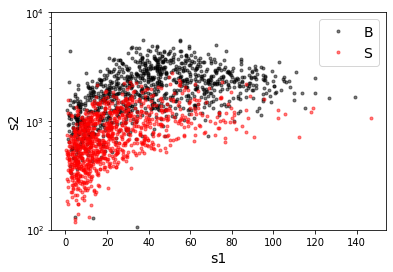

B_pdiffT.shape:  (5000,)
S_pdiffT.shape:  (5000,)


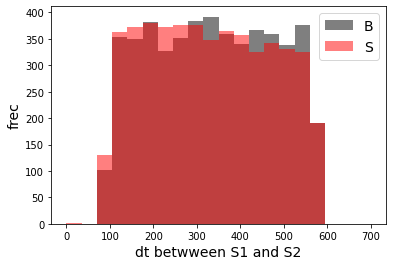

In [16]:

# CONCATENATE THE BACKGROUNDS
B_pbot = np.concatenate([B_pbot_ER[:NUM_DAT_ER], B_pbot_AC[:NUM_DAT_AC], B_pbot_CNNS[:NUM_DAT_CNNS], B_pbot_RN[:NUM_DAT_RN], B_pbot_WALL[:NUM_DAT_WALL]])
B_ptop = np.concatenate([B_ptop_ER[:NUM_DAT_ER], B_ptop_AC[:NUM_DAT_AC], B_ptop_CNNS[:NUM_DAT_CNNS], B_ptop_RN[:NUM_DAT_RN], B_ptop_WALL[:NUM_DAT_WALL]])
B_ppeakS1 = np.concatenate([B_ppeakS1_ER[:NUM_DAT_ER], B_ppeakS1_AC[:NUM_DAT_AC], B_ppeakS1_CNNS[:NUM_DAT_CNNS], B_ppeakS1_RN[:NUM_DAT_RN], B_ppeakS1_WALL[:NUM_DAT_WALL]])
B_ppeakS2 = np.concatenate([B_ppeakS2_ER[:NUM_DAT_ER], B_ppeakS2_AC[:NUM_DAT_AC], B_ppeakS2_CNNS[:NUM_DAT_CNNS], B_ppeakS2_RN[:NUM_DAT_RN], B_ppeakS2_WALL[:NUM_DAT_WALL]])

print('\nB_pbot.shape: ', B_pbot.shape)
print('B_ptop.shape: ', B_ptop.shape)
print('B_ppeakS1.shape :', B_ppeakS1.shape)
print('B_ppeakS2.shape: ', B_ppeakS2.shape)


S_pbot = S_pbot[:num_data]
S_ptop = S_ptop[:num_data]
S_ppeakS1 = S_ppeakS1[:num_data]
S_ppeakS2 = S_ppeakS2[:num_data]

print('\nS_pbot.shape: ', S_pbot.shape)
print('S_ptop.shape: ', S_ptop.shape)
print('S_ppeakS1.shape :', S_ppeakS1.shape)
print('S_ppeakS2.shape: ', S_ppeakS2.shape)


rnd = 100

B_pbot_plot, B_ptop_plot = shuffle(B_pbot, B_ptop, random_state=rnd)
S_pbot_plot, S_ptop_plot = shuffle(S_pbot, S_ptop, random_state=rnd)

plt.plot(B_pbot_plot[:1000], B_ptop_plot[:1000], '.', color='black', alpha=0.5, label='B')
plt.plot(S_pbot_plot[:1000], S_ptop_plot[:1000], '.', color='red', alpha=0.5, label='S')
plt.yscale('log')
# plt.xlim([0,100])
plt.ylim([100,10000])
plt.xlabel('s1',fontsize=14)
plt.ylabel('s2',fontsize=14)
plt.legend(fontsize=14)
plt.show()



# CONSTRUCT THE TIME DIFFERENCE BETWEEN PULSES

B_pdiffT = B_ppeakS2[:,0] - B_ppeakS1[:,0]
S_pdiffT = S_ppeakS2[:,0] - S_ppeakS1[:,0]

print('B_pdiffT.shape: ', B_pdiffT.shape)
print('S_pdiffT.shape: ', S_pdiffT.shape)


plt.hist(B_pdiffT, range=[0,700], bins=20, color='black', alpha=0.5, label='B')
plt.hist(S_pdiffT, range=[0,700], bins=20, color='red', alpha=0.5, label='S')
# plt.yscale('log')
# plt.xlim([0,100])
# plt.ylim([100,10000])
plt.xlabel('dt betwween S1 and S2',fontsize=14)
plt.ylabel('frec',fontsize=14)
plt.legend(fontsize=14)
plt.show()

##### Remove the absolute times of each pulse (we just need the time difference between pulses
other variables also can be removed if you want

In [17]:
remove_col = [0] # index = 0 is pT0

B_pbot = B_pbot
B_ptop = B_ptop
B_ppeakS1 = np.delete(B_ppeakS1, remove_col, axis=1)
B_ppeakS2 = np.delete(B_ppeakS2, remove_col, axis=1)

print('B_pbot.shape: ', B_pbot.shape)
print('B_ptop.shape: ', B_ptop.shape)
print('B_ppeakS1.shape :', B_ppeakS1.shape)
print('B_ppeakS2.shape: ', B_ppeakS2.shape)


S_pbot = S_pbot
S_ptop = S_ptop
S_ppeakS1 = np.delete(S_ppeakS1, remove_col, axis=1)
S_ppeakS2 = np.delete(S_ppeakS2, remove_col, axis=1)

print('S_pbot.shape: ', S_pbot.shape)
print('S_ptop.shape: ', S_ptop.shape)
print('S_ppeakS1.shape :', S_ppeakS1.shape)
print('S_ppeakS2.shape: ', S_ppeakS2.shape)

B_pbot.shape:  (5000,)
B_ptop.shape:  (5000,)
B_ppeakS1.shape : (5000, 7)
B_ppeakS2.shape:  (5000, 7)
S_pbot.shape:  (5000,)
S_ptop.shape:  (5000,)
S_ppeakS1.shape : (5000, 7)
S_ppeakS2.shape:  (5000, 7)


## 1. No compressed features

In [18]:
X_mon_train = np.concatenate([X_mon1_train,X_mon2_train,X_mon3_train,X_mon4_train],axis=1)
X_mon_test = np.concatenate([X_mon1_test,X_mon2_test,X_mon3_test,X_mon4_test],axis=1)
X_mon_val = np.concatenate([X_mon1_val,X_mon2_val,X_mon3_val,X_mon4_val],axis=1)



y_mon_train = y_mon1_train
y_mon_test = y_mon1_test
y_mon_val = y_mon1_val



print('')
print('X_mon_train : ', X_mon_train.shape)
print('y_mon_train : ', y_mon_train.shape)
print('X_mon_val : ', X_mon_val.shape)
print('y_mon_val : ', y_mon_val.shape)
print('X_mon_test : ', X_mon_test.shape)
print('y_mon_test : ', y_mon_test.shape)
print('')


X_mon_train :  (4999, 2724)
y_mon_train :  (4999,)
X_mon_val :  (1667, 2724)
y_mon_val :  (1667,)
X_mon_test :  (3334, 2724)
y_mon_test :  (3334,)



### CLASSIFIER

### XGBoost

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-logloss:0.68739	validation_1-logloss:0.68818
[1]	validation_0-logloss:0.68176	validation_1-logloss:0.68339
[2]	validation_0-logloss:0.67625	validation_1-logloss:0.67869
[3]	validation_0-logloss:0.67085	validation_1-logloss:0.67402
[4]	validation_0-logloss:0.66549	validation_1-logloss:0.66959
[5]	validation_0-logloss:0.66031	validation_1-logloss:0.66507
[6]	validation_0-logloss:0.65514	validation_1-logloss:0.66078
[7]	validation_0-logloss:0.65002	validation_1-logloss:0.65637
[8]	validation_0-logloss:0.64500	validation_1-logloss:0.65200
[9]	validation_0-logloss:0.64013	validation_1-logloss:0.64787
[10]	validation_0-logloss:0.63527	validation_1-logloss:0.64372
[11]	validation_0-logloss:0.63057	validation_1-logloss:0.63987
[12]	validation_0-logloss:0.62585	validation_1-logloss:0.63598
[13]	validation_0-logloss:0.62130	validation_1-logloss:0.63219
[14]	validation_0-logloss:0.61673	validation_1-logloss:0.62833
[15]	validation_0-logloss:0.61233	validation_1-logloss:0.62465
[1

[130]	validation_0-logloss:0.33421	validation_1-logloss:0.41139
[131]	validation_0-logloss:0.33296	validation_1-logloss:0.41054
[132]	validation_0-logloss:0.33158	validation_1-logloss:0.40961
[133]	validation_0-logloss:0.33025	validation_1-logloss:0.40860
[134]	validation_0-logloss:0.32887	validation_1-logloss:0.40764
[135]	validation_0-logloss:0.32751	validation_1-logloss:0.40672
[136]	validation_0-logloss:0.32621	validation_1-logloss:0.40588
[137]	validation_0-logloss:0.32498	validation_1-logloss:0.40503
[138]	validation_0-logloss:0.32365	validation_1-logloss:0.40404
[139]	validation_0-logloss:0.32225	validation_1-logloss:0.40305
[140]	validation_0-logloss:0.32094	validation_1-logloss:0.40217
[141]	validation_0-logloss:0.31971	validation_1-logloss:0.40140
[142]	validation_0-logloss:0.31855	validation_1-logloss:0.40065
[143]	validation_0-logloss:0.31728	validation_1-logloss:0.39982
[144]	validation_0-logloss:0.31606	validation_1-logloss:0.39912
[145]	validation_0-logloss:0.31484	valid

[259]	validation_0-logloss:0.21447	validation_1-logloss:0.33983
[260]	validation_0-logloss:0.21387	validation_1-logloss:0.33950
[261]	validation_0-logloss:0.21320	validation_1-logloss:0.33924
[262]	validation_0-logloss:0.21260	validation_1-logloss:0.33897
[263]	validation_0-logloss:0.21194	validation_1-logloss:0.33852
[264]	validation_0-logloss:0.21130	validation_1-logloss:0.33819
[265]	validation_0-logloss:0.21076	validation_1-logloss:0.33781
[266]	validation_0-logloss:0.21018	validation_1-logloss:0.33753
[267]	validation_0-logloss:0.20964	validation_1-logloss:0.33720
[268]	validation_0-logloss:0.20905	validation_1-logloss:0.33694
[269]	validation_0-logloss:0.20843	validation_1-logloss:0.33653
[270]	validation_0-logloss:0.20786	validation_1-logloss:0.33623
[271]	validation_0-logloss:0.20722	validation_1-logloss:0.33584
[272]	validation_0-logloss:0.20662	validation_1-logloss:0.33539
[273]	validation_0-logloss:0.20612	validation_1-logloss:0.33512
[274]	validation_0-logloss:0.20555	valid

[388]	validation_0-logloss:0.15672	validation_1-logloss:0.31169
[389]	validation_0-logloss:0.15648	validation_1-logloss:0.31162
[390]	validation_0-logloss:0.15623	validation_1-logloss:0.31146
[391]	validation_0-logloss:0.15587	validation_1-logloss:0.31135
[392]	validation_0-logloss:0.15548	validation_1-logloss:0.31115
[393]	validation_0-logloss:0.15512	validation_1-logloss:0.31099
[394]	validation_0-logloss:0.15488	validation_1-logloss:0.31095
[395]	validation_0-logloss:0.15454	validation_1-logloss:0.31077
[396]	validation_0-logloss:0.15415	validation_1-logloss:0.31060
[397]	validation_0-logloss:0.15385	validation_1-logloss:0.31044
[398]	validation_0-logloss:0.15353	validation_1-logloss:0.31025
[399]	validation_0-logloss:0.15322	validation_1-logloss:0.31011
[400]	validation_0-logloss:0.15299	validation_1-logloss:0.30997
[401]	validation_0-logloss:0.15269	validation_1-logloss:0.30983
[402]	validation_0-logloss:0.15247	validation_1-logloss:0.30967
[403]	validation_0-logloss:0.15210	valid

[517]	validation_0-logloss:0.12266	validation_1-logloss:0.29803
[518]	validation_0-logloss:0.12243	validation_1-logloss:0.29796
[519]	validation_0-logloss:0.12216	validation_1-logloss:0.29785
[520]	validation_0-logloss:0.12190	validation_1-logloss:0.29783
[521]	validation_0-logloss:0.12170	validation_1-logloss:0.29771
[522]	validation_0-logloss:0.12151	validation_1-logloss:0.29766
[523]	validation_0-logloss:0.12132	validation_1-logloss:0.29762
[524]	validation_0-logloss:0.12115	validation_1-logloss:0.29761
[525]	validation_0-logloss:0.12093	validation_1-logloss:0.29757
[526]	validation_0-logloss:0.12070	validation_1-logloss:0.29752
[527]	validation_0-logloss:0.12052	validation_1-logloss:0.29751
[528]	validation_0-logloss:0.12033	validation_1-logloss:0.29748
[529]	validation_0-logloss:0.12016	validation_1-logloss:0.29742
[530]	validation_0-logloss:0.11986	validation_1-logloss:0.29733
[531]	validation_0-logloss:0.11963	validation_1-logloss:0.29735
[532]	validation_0-logloss:0.11952	valid

[646]	validation_0-logloss:0.10040	validation_1-logloss:0.29079
[647]	validation_0-logloss:0.10034	validation_1-logloss:0.29075
[648]	validation_0-logloss:0.10014	validation_1-logloss:0.29070
[649]	validation_0-logloss:0.09996	validation_1-logloss:0.29069
[650]	validation_0-logloss:0.09984	validation_1-logloss:0.29067
[651]	validation_0-logloss:0.09971	validation_1-logloss:0.29060
[652]	validation_0-logloss:0.09955	validation_1-logloss:0.29053
[653]	validation_0-logloss:0.09940	validation_1-logloss:0.29050
[654]	validation_0-logloss:0.09929	validation_1-logloss:0.29043
[655]	validation_0-logloss:0.09918	validation_1-logloss:0.29039
[656]	validation_0-logloss:0.09902	validation_1-logloss:0.29033
[657]	validation_0-logloss:0.09892	validation_1-logloss:0.29029
[658]	validation_0-logloss:0.09870	validation_1-logloss:0.29027
[659]	validation_0-logloss:0.09853	validation_1-logloss:0.29021
[660]	validation_0-logloss:0.09839	validation_1-logloss:0.29020
[661]	validation_0-logloss:0.09828	valid

[775]	validation_0-logloss:0.08475	validation_1-logloss:0.28688
[776]	validation_0-logloss:0.08462	validation_1-logloss:0.28688
[777]	validation_0-logloss:0.08456	validation_1-logloss:0.28686
[778]	validation_0-logloss:0.08448	validation_1-logloss:0.28682
[779]	validation_0-logloss:0.08436	validation_1-logloss:0.28674
[780]	validation_0-logloss:0.08432	validation_1-logloss:0.28673
[781]	validation_0-logloss:0.08422	validation_1-logloss:0.28673
[782]	validation_0-logloss:0.08408	validation_1-logloss:0.28669
[783]	validation_0-logloss:0.08400	validation_1-logloss:0.28667
[784]	validation_0-logloss:0.08388	validation_1-logloss:0.28668
[785]	validation_0-logloss:0.08378	validation_1-logloss:0.28670
[786]	validation_0-logloss:0.08368	validation_1-logloss:0.28669
[787]	validation_0-logloss:0.08354	validation_1-logloss:0.28671
[788]	validation_0-logloss:0.08346	validation_1-logloss:0.28669
[789]	validation_0-logloss:0.08342	validation_1-logloss:0.28667
[790]	validation_0-logloss:0.08334	valid

[904]	validation_0-logloss:0.07344	validation_1-logloss:0.28517
[905]	validation_0-logloss:0.07333	validation_1-logloss:0.28519
[906]	validation_0-logloss:0.07325	validation_1-logloss:0.28521
[907]	validation_0-logloss:0.07320	validation_1-logloss:0.28523
[908]	validation_0-logloss:0.07314	validation_1-logloss:0.28522
[909]	validation_0-logloss:0.07304	validation_1-logloss:0.28517
[910]	validation_0-logloss:0.07297	validation_1-logloss:0.28520
[911]	validation_0-logloss:0.07293	validation_1-logloss:0.28520
[912]	validation_0-logloss:0.07284	validation_1-logloss:0.28514
[913]	validation_0-logloss:0.07278	validation_1-logloss:0.28515
[914]	validation_0-logloss:0.07264	validation_1-logloss:0.28509
[915]	validation_0-logloss:0.07254	validation_1-logloss:0.28510
[916]	validation_0-logloss:0.07245	validation_1-logloss:0.28513
[917]	validation_0-logloss:0.07238	validation_1-logloss:0.28506
[918]	validation_0-logloss:0.07230	validation_1-logloss:0.28505
[919]	validation_0-logloss:0.07223	valid

[1032]	validation_0-logloss:0.06462	validation_1-logloss:0.28457
[1033]	validation_0-logloss:0.06458	validation_1-logloss:0.28458
[1034]	validation_0-logloss:0.06451	validation_1-logloss:0.28451
[1035]	validation_0-logloss:0.06443	validation_1-logloss:0.28448
[1036]	validation_0-logloss:0.06440	validation_1-logloss:0.28447
[1037]	validation_0-logloss:0.06433	validation_1-logloss:0.28453
[1038]	validation_0-logloss:0.06427	validation_1-logloss:0.28453
[1039]	validation_0-logloss:0.06420	validation_1-logloss:0.28455
[1040]	validation_0-logloss:0.06411	validation_1-logloss:0.28455
[1041]	validation_0-logloss:0.06404	validation_1-logloss:0.28452
[1042]	validation_0-logloss:0.06398	validation_1-logloss:0.28452
[1043]	validation_0-logloss:0.06393	validation_1-logloss:0.28453
[1044]	validation_0-logloss:0.06386	validation_1-logloss:0.28451
[1045]	validation_0-logloss:0.06380	validation_1-logloss:0.28445
[1046]	validation_0-logloss:0.06368	validation_1-logloss:0.28446
[1047]	validation_0-loglo

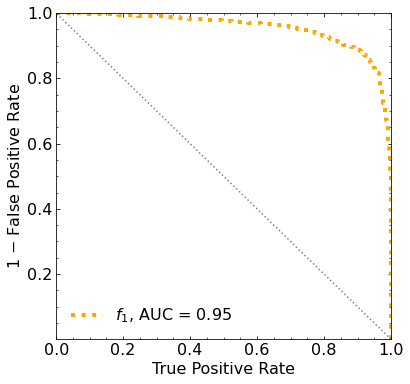

Classification score:


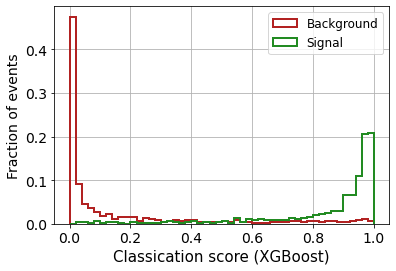


 ROC-AUC =  0.9542019764860358


In [19]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators=2500,
    learning_rate=0.01,
    reg_lambda=0.01,reg_alpha=0.0,
    gamma=0.0,objective='binary:logistic',
    max_depth=5,
    #eval_metric=["error", "logloss", "map"]
    eval_metric='logloss')

# FIT
classifier.fit(X_mon_train,y_mon_train,eval_set=[(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
        early_stopping_rounds=50,#early stopping
        verbose=True)


# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_mon_test).T[1]


# ROC
fpr_mon_xg, tpr_mon_xg, _ = roc_curve(y_mon_test, y_pred_xg)
roc_auc_xg = auc(fpr_mon_xg, tpr_mon_xg)


# PLOT THE ROC WITH AUC
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax0.minorticks_on()


plt.plot(tpr_mon_xg,1-fpr_mon_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()



# XGBoost with the kinematic variables of the leptons

########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()




print('\n ROC-AUC = ', roc_auc_xg)

In [20]:
print('\n ROC-AUC = ', roc_auc_xg)


 ROC-AUC =  0.9542019764860358


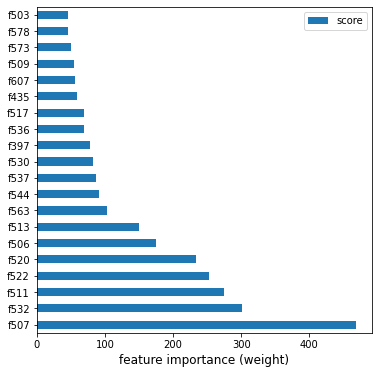

In [21]:
feature_important = classifier.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
#keys = ['pA_S1','pH_S1','pHT_S1','pL_S1','pL90_S1','pRMSW_S1','pHTL_S1','pA_S2','pH_S2','pHT_S2','pL_S2','pL90_S2','pRMSW_S2','pHTL_S2','pbot', 'ptop','pdiffT']
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(20, columns="score").plot(kind='barh', figsize = (6,6)) ## plot top 10 features
plt.xlabel('feature importance (weight)', fontsize = 12)
plt.show()

### DNN
lots of tests, the best is:

Dense layers: 1-4-8-16-32-64-128-256, 

Activation: LeakyReLu

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 21800     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 8)                 0         
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 36        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 4)                 0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5

Epoch 50/500
40/40 [==============================] - 0s 1ms/step - loss: 0.2889 - accuracy: 0.8914 - val_loss: 0.3271 - val_accuracy: 0.8704
Epoch 51/500
40/40 [==============================] - 0s 1ms/step - loss: 0.2898 - accuracy: 0.8991 - val_loss: 0.3247 - val_accuracy: 0.8692
Epoch 52/500
40/40 [==============================] - 0s 1ms/step - loss: 0.2759 - accuracy: 0.9018 - val_loss: 0.3250 - val_accuracy: 0.8698
Epoch 53/500
40/40 [==============================] - 0s 1ms/step - loss: 0.3181 - accuracy: 0.8758 - val_loss: 0.3167 - val_accuracy: 0.8698
Epoch 54/500
40/40 [==============================] - 0s 1ms/step - loss: 0.2896 - accuracy: 0.9023 - val_loss: 0.3351 - val_accuracy: 0.8734
Epoch 55/500
40/40 [==============================] - 0s 1ms/step - loss: 0.2789 - accuracy: 0.9069 - val_loss: 0.3178 - val_accuracy: 0.8692
Epoch 56/500
40/40 [==============================] - 0s 1ms/step - loss: 0.2787 - accuracy: 0.9010 - val_loss: 0.3181 - val_accuracy: 0.8728
Epoch 

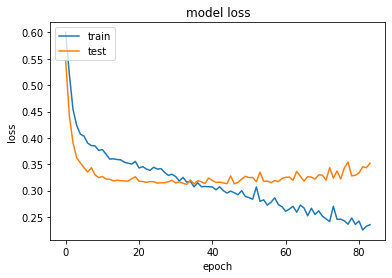

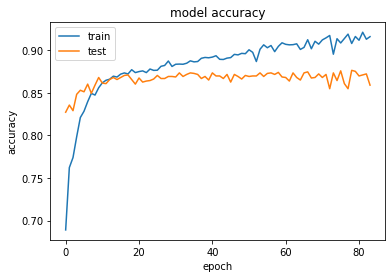

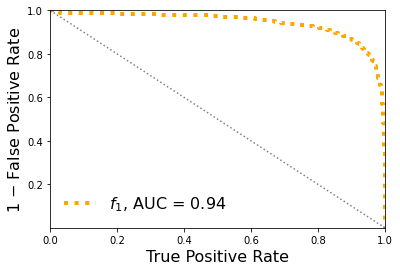

Classification score:


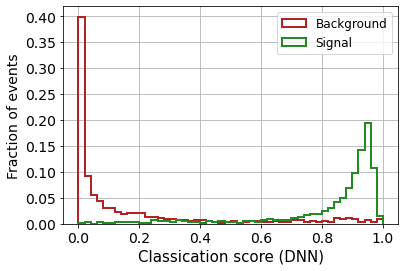


 ROC-AUC =  0.9435107678751912


In [22]:

# define the keras model
model = Sequential()
model.add(Dense(8, input_shape=(X_mon_train.shape[1],)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(4))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_dnn = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_dnn = dict()
tpr_dnn = dict()
roc_auc_dnn = dict()
fpr_dnn, tpr_dnn, _ = roc_curve(y_mon_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)


plt.figure()
plt.plot(tpr_dnn,1-fpr_dnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_dnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_dnn[i,0])
    else:
        pred_XG_NP.append(y_pred_dnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (DNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_dnn)

In [23]:
print('\n ROC-AUC = ', roc_auc_dnn)


 ROC-AUC =  0.9435107678751912


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 16)                43600     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 68        
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 4)                 0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

Epoch 50/500
40/40 [==============================] - 0s 1ms/step - loss: 0.2708 - accuracy: 0.8876 - val_loss: 0.3362 - val_accuracy: 0.8650
Epoch 51/500
40/40 [==============================] - 0s 1ms/step - loss: 0.2561 - accuracy: 0.8966 - val_loss: 0.3196 - val_accuracy: 0.8704
Epoch 52/500
40/40 [==============================] - 0s 1ms/step - loss: 0.2392 - accuracy: 0.9036 - val_loss: 0.3201 - val_accuracy: 0.8710
Epoch 53/500
40/40 [==============================] - 0s 1ms/step - loss: 0.2514 - accuracy: 0.9001 - val_loss: 0.3268 - val_accuracy: 0.8692
Epoch 54/500
40/40 [==============================] - 0s 1ms/step - loss: 0.2450 - accuracy: 0.9043 - val_loss: 0.3321 - val_accuracy: 0.8674
Epoch 55/500
40/40 [==============================] - 0s 1ms/step - loss: 0.2682 - accuracy: 0.8914 - val_loss: 0.3156 - val_accuracy: 0.8728
Epoch 56/500
40/40 [==============================] - 0s 1ms/step - loss: 0.2479 - accuracy: 0.9036 - val_loss: 0.3409 - val_accuracy: 0.8692
Epoch 

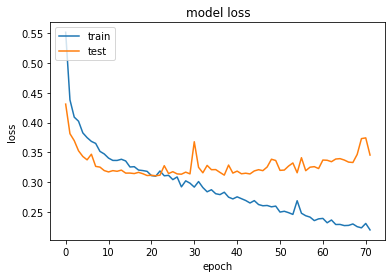

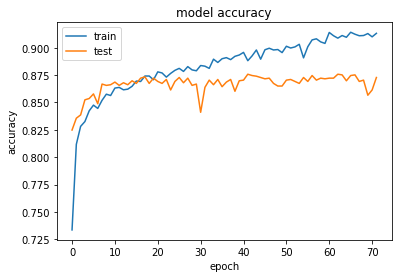

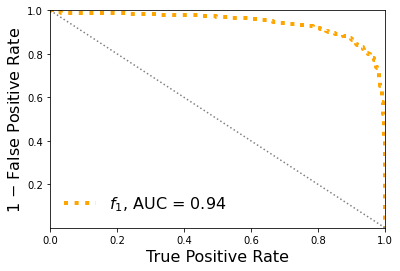

Classification score:


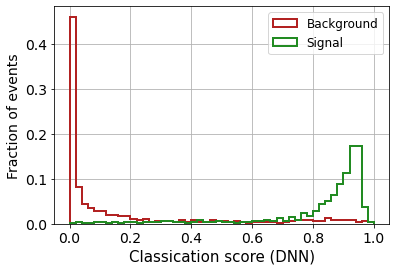


 ROC-AUC =  0.9431205961708463


In [24]:

# define the keras model
model = Sequential()
model.add(Dense(16, input_shape=(X_mon_train.shape[1],)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(4))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_dnn = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_dnn = dict()
tpr_dnn = dict()
roc_auc_dnn = dict()
fpr_dnn, tpr_dnn, _ = roc_curve(y_mon_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)


plt.figure()
plt.plot(tpr_dnn,1-fpr_dnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_dnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_dnn[i,0])
    else:
        pred_XG_NP.append(y_pred_dnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (DNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_dnn)

In [25]:
print('\n ROC-AUC = ', roc_auc_dnn)


 ROC-AUC =  0.9431205961708463


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 32)                87200     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 32)                0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)                528       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16)                0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                

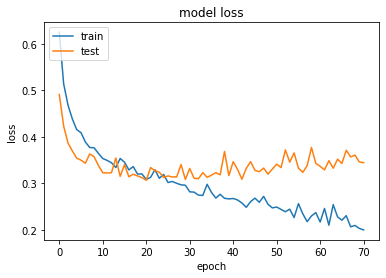

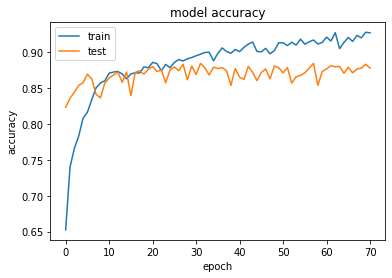

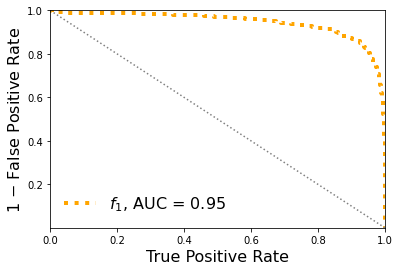

Classification score:


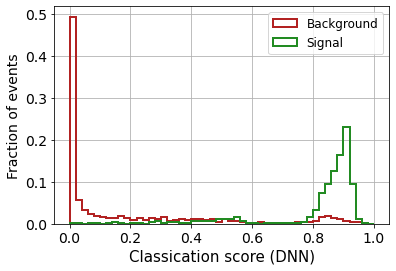


 ROC-AUC =  0.9450520180947526


In [26]:

# define the keras model
model = Sequential()
model.add(Dense(32, input_shape=(X_mon_train.shape[1],)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(16))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(8))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(4))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_dnn = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_dnn = dict()
tpr_dnn = dict()
roc_auc_dnn = dict()
fpr_dnn, tpr_dnn, _ = roc_curve(y_mon_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)


plt.figure()
plt.plot(tpr_dnn,1-fpr_dnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_dnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_dnn[i,0])
    else:
        pred_XG_NP.append(y_pred_dnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (DNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_dnn)

In [27]:
print('\n ROC-AUC = ', roc_auc_dnn)


 ROC-AUC =  0.9450520180947526


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 64)                174400    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 32)                2080      
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 32)                0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 16)               

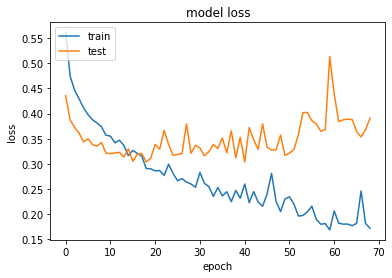

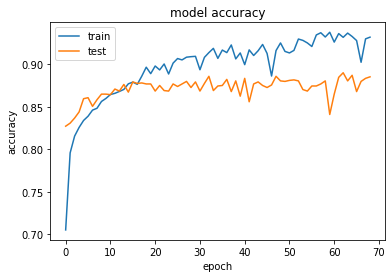

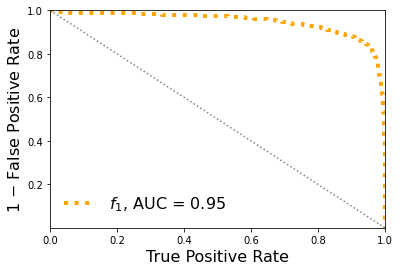

Classification score:


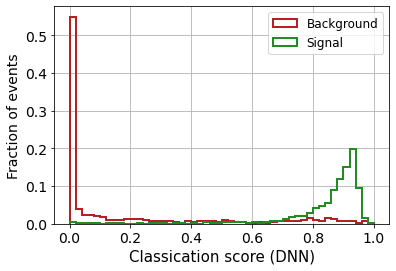


 ROC-AUC =  0.9485146120023151


In [28]:

# define the keras model
model = Sequential()
model.add(Dense(64, input_shape=(X_mon_train.shape[1],)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(32))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(16))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(8))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(4))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_dnn = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_dnn = dict()
tpr_dnn = dict()
roc_auc_dnn = dict()
fpr_dnn, tpr_dnn, _ = roc_curve(y_mon_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)


plt.figure()
plt.plot(tpr_dnn,1-fpr_dnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_dnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_dnn[i,0])
    else:
        pred_XG_NP.append(y_pred_dnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (DNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_dnn)

In [29]:
print('\n ROC-AUC = ', roc_auc_dnn)


 ROC-AUC =  0.9485146120023151


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 128)               348800    
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 128)               0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)                8256      
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 64)                0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 32)               

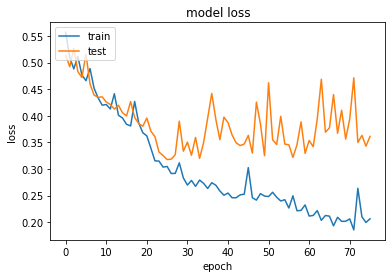

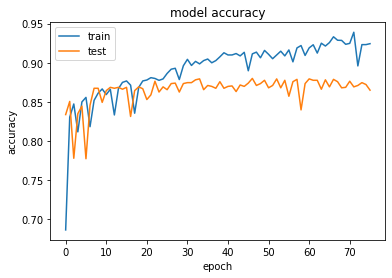

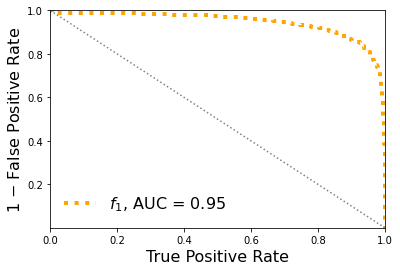

Classification score:


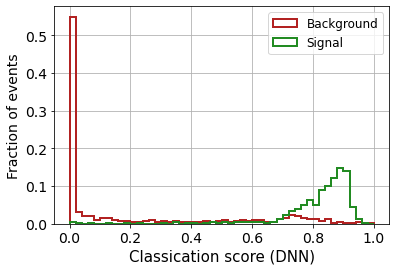


 ROC-AUC =  0.9457002646256799


In [30]:

# define the keras model
model = Sequential()
model.add(Dense(128, input_shape=(X_mon_train.shape[1],)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(64))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(32))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(16))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(8))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(4))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_dnn = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_dnn = dict()
tpr_dnn = dict()
roc_auc_dnn = dict()
fpr_dnn, tpr_dnn, _ = roc_curve(y_mon_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)


plt.figure()
plt.plot(tpr_dnn,1-fpr_dnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_dnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_dnn[i,0])
    else:
        pred_XG_NP.append(y_pred_dnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (DNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_dnn)

In [31]:
print('\n ROC-AUC = ', roc_auc_dnn)


 ROC-AUC =  0.9457002646256799


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 256)               697600    
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 128)               32896     
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 128)               0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 64)               

Epoch 36/500
40/40 [==============================] - 0s 3ms/step - loss: 0.2438 - accuracy: 0.9056 - val_loss: 0.3467 - val_accuracy: 0.8752
Epoch 37/500
40/40 [==============================] - 0s 3ms/step - loss: 0.2329 - accuracy: 0.9101 - val_loss: 0.3174 - val_accuracy: 0.8680
Epoch 38/500
40/40 [==============================] - 0s 3ms/step - loss: 0.2340 - accuracy: 0.9096 - val_loss: 0.3361 - val_accuracy: 0.8818
Epoch 39/500
40/40 [==============================] - 0s 3ms/step - loss: 0.2318 - accuracy: 0.9073 - val_loss: 0.3468 - val_accuracy: 0.8608
Epoch 40/500
40/40 [==============================] - 0s 3ms/step - loss: 0.2332 - accuracy: 0.9047 - val_loss: 0.3604 - val_accuracy: 0.8806
Epoch 41/500
40/40 [==============================] - 0s 3ms/step - loss: 0.2234 - accuracy: 0.9141 - val_loss: 0.4298 - val_accuracy: 0.8752
Epoch 42/500
40/40 [==============================] - 0s 3ms/step - loss: 0.2100 - accuracy: 0.9153 - val_loss: 0.3497 - val_accuracy: 0.8698
Epoch 

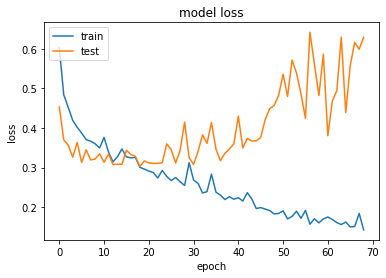

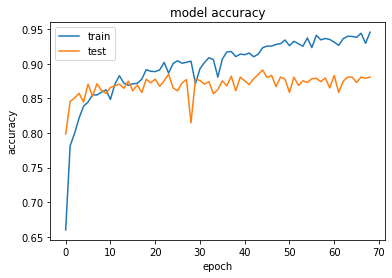

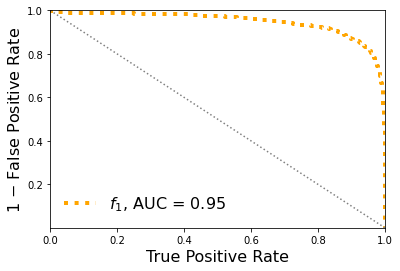

Classification score:


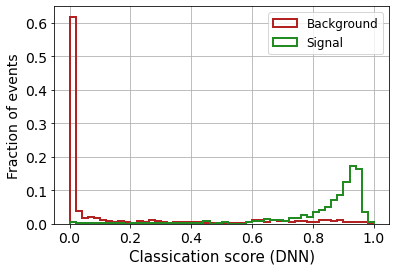


 ROC-AUC =  0.9473682126680546


In [32]:

# define the keras model
model = Sequential()
model.add(Dense(256, input_shape=(X_mon_train.shape[1],)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(128))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(64))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(32))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(16))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(8))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(4))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_dnn = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_dnn = dict()
tpr_dnn = dict()
roc_auc_dnn = dict()
fpr_dnn, tpr_dnn, _ = roc_curve(y_mon_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)


plt.figure()
plt.plot(tpr_dnn,1-fpr_dnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_dnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_dnn[i,0])
    else:
        pred_XG_NP.append(y_pred_dnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (DNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_dnn)

In [33]:
print('\n ROC-AUC = ', roc_auc_dnn)


 ROC-AUC =  0.9473682126680546


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 256)               697600    
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 128)               32896     
_________________________________________________________________
leaky_re_lu_27 (LeakyReLU)   (None, 128)               0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 64)               

Epoch 36/500
40/40 [==============================] - 0s 4ms/step - loss: 0.2079 - accuracy: 0.9262 - val_loss: 0.3246 - val_accuracy: 0.8806
Epoch 37/500
40/40 [==============================] - 0s 4ms/step - loss: 0.2008 - accuracy: 0.9258 - val_loss: 0.3428 - val_accuracy: 0.8800
Epoch 38/500
40/40 [==============================] - 0s 4ms/step - loss: 0.1983 - accuracy: 0.9260 - val_loss: 0.3603 - val_accuracy: 0.8776
Epoch 39/500
40/40 [==============================] - 0s 4ms/step - loss: 0.2138 - accuracy: 0.9135 - val_loss: 0.4600 - val_accuracy: 0.8644
Epoch 40/500
40/40 [==============================] - 0s 4ms/step - loss: 0.2139 - accuracy: 0.9199 - val_loss: 0.3389 - val_accuracy: 0.8668
Epoch 41/500
40/40 [==============================] - 0s 4ms/step - loss: 0.1931 - accuracy: 0.9221 - val_loss: 0.3508 - val_accuracy: 0.8830
Epoch 42/500
40/40 [==============================] - 0s 4ms/step - loss: 0.1813 - accuracy: 0.9256 - val_loss: 0.3675 - val_accuracy: 0.8806
Epoch 

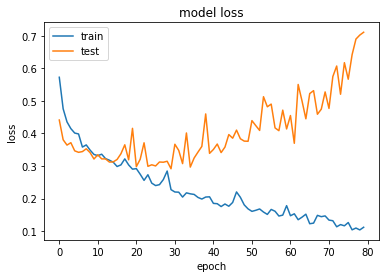

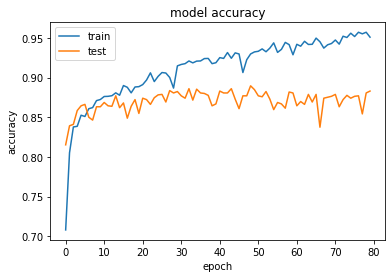

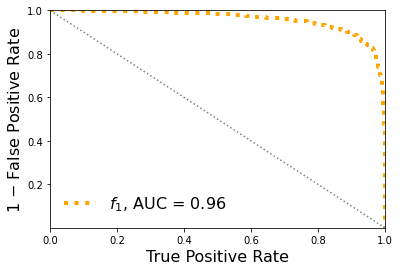

Classification score:


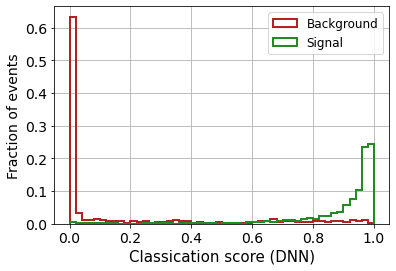


 ROC-AUC =  0.9595686371057611


In [34]:

# define the keras model
model = Sequential()
model.add(Dense(256, input_shape=(X_mon_train.shape[1],)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(128))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(64))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(32))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(16))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(8))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(4))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_dnn = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_dnn = dict()
tpr_dnn = dict()
roc_auc_dnn = dict()
fpr_dnn, tpr_dnn, _ = roc_curve(y_mon_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)


plt.figure()
plt.plot(tpr_dnn,1-fpr_dnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_dnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_dnn[i,0])
    else:
        pred_XG_NP.append(y_pred_dnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (DNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_dnn)

In [35]:
print('\n ROC-AUC = ', roc_auc_dnn)


 ROC-AUC =  0.9595686371057611


### CNN

model = Sequential()
model.add(Conv1D(16, 3, input_shape=(X_mon_train.shape[1],1), strides = (1),kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Conv1D(16, 3, kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Conv1D(16, 3, kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.LeakyReLU(alpha=0.05))  
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))

In [36]:
# prepare the dataset
X_mon_train_cn = X_mon_train.reshape(X_mon_train.shape[0], X_mon_train.shape[1], 1)
X_mon_test_cn = X_mon_test.reshape(X_mon_test.shape[0], X_mon_test.shape[1], 1)
X_mon_val_cn = X_mon_val.reshape(X_mon_val.shape[0], X_mon_val.shape[1], 1)

Epoch 1/500
40/40 [==============================] - 3s 29ms/step - loss: 0.5657 - accuracy: 0.7365 - val_loss: 0.3858 - val_accuracy: 0.8434
Epoch 2/500
40/40 [==============================] - 1s 25ms/step - loss: 0.3859 - accuracy: 0.8466 - val_loss: 0.3611 - val_accuracy: 0.8548
Epoch 3/500
40/40 [==============================] - 1s 25ms/step - loss: 0.3708 - accuracy: 0.8522 - val_loss: 0.3541 - val_accuracy: 0.8692
Epoch 4/500
40/40 [==============================] - 1s 25ms/step - loss: 0.3612 - accuracy: 0.8664 - val_loss: 0.3567 - val_accuracy: 0.8572
Epoch 5/500
40/40 [==============================] - 1s 25ms/step - loss: 0.3583 - accuracy: 0.8653 - val_loss: 0.3712 - val_accuracy: 0.8512
Epoch 6/500
40/40 [==============================] - 1s 25ms/step - loss: 0.3605 - accuracy: 0.8588 - val_loss: 0.3453 - val_accuracy: 0.8698
Epoch 7/500
40/40 [==============================] - 1s 25ms/step - loss: 0.3565 - accuracy: 0.8609 - val_loss: 0.3472 - val_accuracy: 0.8668
Epoch 

40/40 [==============================] - 1s 25ms/step - loss: 0.3201 - accuracy: 0.8859 - val_loss: 0.3519 - val_accuracy: 0.8722
Epoch 116/500
40/40 [==============================] - 1s 25ms/step - loss: 0.3341 - accuracy: 0.8773 - val_loss: 0.3518 - val_accuracy: 0.8692
Epoch 117/500
40/40 [==============================] - 1s 25ms/step - loss: 0.3151 - accuracy: 0.8871 - val_loss: 0.3403 - val_accuracy: 0.8740
Restoring model weights from the end of the best epoch.
Epoch 00117: early stopping


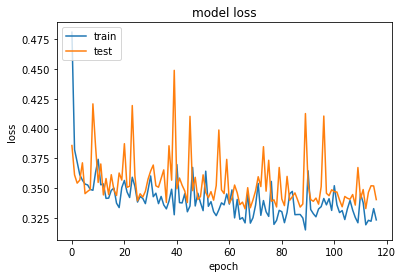

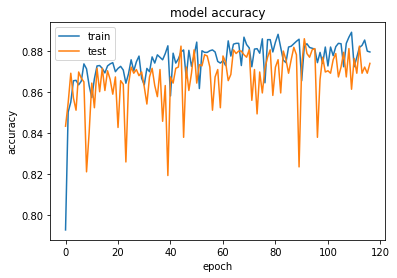

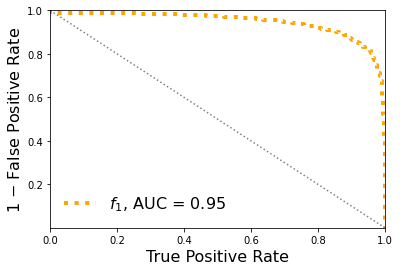

Classification score:


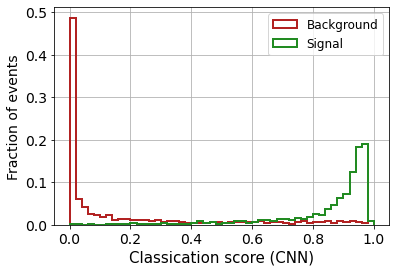


 ROC-AUC =  0.9469024541944178


In [37]:

# define the keras model
model = Sequential()
model.add(Conv1D(8, 2, input_shape=(X_mon_train.shape[1],1), strides = (1),kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.LeakyReLU(alpha=0.05))  
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train_cn,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_cn, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test_cn)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

In [38]:
print('\n ROC-AUC = ', roc_auc_cnn)


 ROC-AUC =  0.9469024541944178


Epoch 1/500
40/40 [==============================] - 3s 56ms/step - loss: 0.6219 - accuracy: 0.6965 - val_loss: 0.4309 - val_accuracy: 0.8254
Epoch 2/500
40/40 [==============================] - 2s 51ms/step - loss: 0.4061 - accuracy: 0.8500 - val_loss: 0.3820 - val_accuracy: 0.8548
Epoch 3/500
40/40 [==============================] - 2s 52ms/step - loss: 0.3845 - accuracy: 0.8546 - val_loss: 0.3645 - val_accuracy: 0.8674
Epoch 4/500
40/40 [==============================] - 2s 52ms/step - loss: 0.3799 - accuracy: 0.8644 - val_loss: 0.3855 - val_accuracy: 0.8506
Epoch 5/500
40/40 [==============================] - 2s 52ms/step - loss: 0.3683 - accuracy: 0.8677 - val_loss: 0.3593 - val_accuracy: 0.8692
Epoch 6/500
40/40 [==============================] - 2s 52ms/step - loss: 0.3598 - accuracy: 0.8731 - val_loss: 0.4195 - val_accuracy: 0.8284
Epoch 7/500
40/40 [==============================] - 2s 52ms/step - loss: 0.3875 - accuracy: 0.8547 - val_loss: 0.3748 - val_accuracy: 0.8530
Epoch 

40/40 [==============================] - 2s 53ms/step - loss: 0.3300 - accuracy: 0.8767 - val_loss: 0.4603 - val_accuracy: 0.8188
Epoch 116/500
40/40 [==============================] - 2s 53ms/step - loss: 0.3596 - accuracy: 0.8670 - val_loss: 0.3674 - val_accuracy: 0.8644
Epoch 117/500
40/40 [==============================] - 2s 52ms/step - loss: 0.3514 - accuracy: 0.8730 - val_loss: 0.3661 - val_accuracy: 0.8722
Epoch 118/500
40/40 [==============================] - 2s 53ms/step - loss: 0.3484 - accuracy: 0.8735 - val_loss: 0.3376 - val_accuracy: 0.8800
Epoch 119/500
40/40 [==============================] - 2s 53ms/step - loss: 0.3338 - accuracy: 0.8793 - val_loss: 0.3430 - val_accuracy: 0.8782
Epoch 120/500
40/40 [==============================] - 2s 53ms/step - loss: 0.3347 - accuracy: 0.8795 - val_loss: 0.3354 - val_accuracy: 0.8782
Epoch 121/500
40/40 [==============================] - 2s 56ms/step - loss: 0.3258 - accuracy: 0.8824 - val_loss: 0.3660 - val_accuracy: 0.8608
Epoch 

Epoch 172/500
40/40 [==============================] - 2s 53ms/step - loss: 0.3002 - accuracy: 0.8959 - val_loss: 0.3544 - val_accuracy: 0.8608
Epoch 173/500
40/40 [==============================] - 2s 52ms/step - loss: 0.3389 - accuracy: 0.8750 - val_loss: 0.3393 - val_accuracy: 0.8800
Epoch 174/500
40/40 [==============================] - 2s 54ms/step - loss: 0.3406 - accuracy: 0.8737 - val_loss: 0.3307 - val_accuracy: 0.8848
Epoch 175/500
40/40 [==============================] - 2s 56ms/step - loss: 0.3172 - accuracy: 0.8868 - val_loss: 0.3378 - val_accuracy: 0.8788
Epoch 176/500
40/40 [==============================] - 2s 55ms/step - loss: 0.3193 - accuracy: 0.8877 - val_loss: 0.3526 - val_accuracy: 0.8704
Epoch 177/500
40/40 [==============================] - 2s 55ms/step - loss: 0.3166 - accuracy: 0.8930 - val_loss: 0.3526 - val_accuracy: 0.8782
Epoch 178/500
40/40 [==============================] - 2s 56ms/step - loss: 0.3267 - accuracy: 0.8835 - val_loss: 0.3754 - val_accuracy:

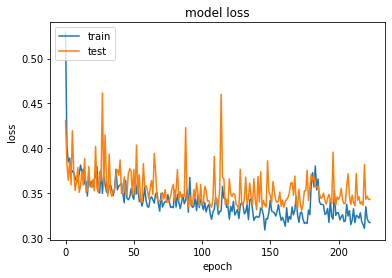

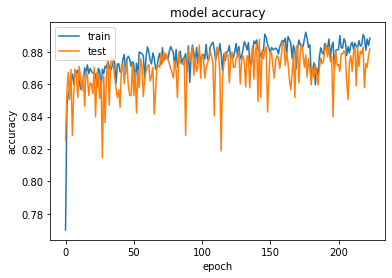

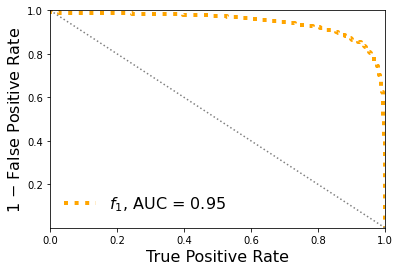

Classification score:


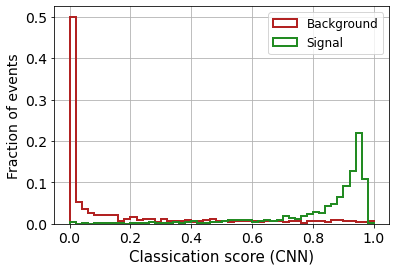


 ROC-AUC =  0.9464982449472042


In [39]:

# define the keras model
model = Sequential()
model.add(Conv1D(16, 2, input_shape=(X_mon_train.shape[1],1), strides = (1),kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.LeakyReLU(alpha=0.05))  
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train_cn,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_cn, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test_cn)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

In [40]:
print('\n ROC-AUC = ', roc_auc_cnn)


 ROC-AUC =  0.9464982449472042


Epoch 1/500
40/40 [==============================] - 5s 113ms/step - loss: 0.5984 - accuracy: 0.7107 - val_loss: 0.4012 - val_accuracy: 0.8344
Epoch 2/500
40/40 [==============================] - 4s 105ms/step - loss: 0.3972 - accuracy: 0.8403 - val_loss: 0.3993 - val_accuracy: 0.8332
Epoch 3/500
40/40 [==============================] - 4s 105ms/step - loss: 0.3972 - accuracy: 0.8440 - val_loss: 0.3845 - val_accuracy: 0.8488
Epoch 4/500
40/40 [==============================] - 4s 105ms/step - loss: 0.3856 - accuracy: 0.8485 - val_loss: 0.3657 - val_accuracy: 0.8518
Epoch 5/500
40/40 [==============================] - 4s 106ms/step - loss: 0.3621 - accuracy: 0.8597 - val_loss: 0.4325 - val_accuracy: 0.8188
Epoch 6/500
40/40 [==============================] - 4s 105ms/step - loss: 0.3992 - accuracy: 0.8447 - val_loss: 0.3574 - val_accuracy: 0.8638
Epoch 7/500
40/40 [==============================] - 4s 105ms/step - loss: 0.3661 - accuracy: 0.8595 - val_loss: 0.3688 - val_accuracy: 0.8518

Epoch 58/500
40/40 [==============================] - 4s 107ms/step - loss: 0.3642 - accuracy: 0.8647 - val_loss: 0.3487 - val_accuracy: 0.8728
Epoch 59/500
40/40 [==============================] - 4s 106ms/step - loss: 0.3473 - accuracy: 0.8791 - val_loss: 0.3495 - val_accuracy: 0.8692
Epoch 60/500
40/40 [==============================] - 4s 106ms/step - loss: 0.3421 - accuracy: 0.8744 - val_loss: 0.3474 - val_accuracy: 0.8692
Epoch 61/500
40/40 [==============================] - 4s 107ms/step - loss: 0.3299 - accuracy: 0.8776 - val_loss: 0.3469 - val_accuracy: 0.8734
Epoch 62/500
40/40 [==============================] - 4s 107ms/step - loss: 0.3379 - accuracy: 0.8820 - val_loss: 0.3423 - val_accuracy: 0.8764
Epoch 63/500
40/40 [==============================] - 4s 106ms/step - loss: 0.3271 - accuracy: 0.8784 - val_loss: 0.3423 - val_accuracy: 0.8824
Epoch 64/500
40/40 [==============================] - 4s 107ms/step - loss: 0.3526 - accuracy: 0.8661 - val_loss: 0.3467 - val_accuracy:

Epoch 115/500
40/40 [==============================] - 4s 106ms/step - loss: 0.3640 - accuracy: 0.8687 - val_loss: 0.3447 - val_accuracy: 0.8734
Epoch 116/500
40/40 [==============================] - 4s 106ms/step - loss: 0.3395 - accuracy: 0.8771 - val_loss: 0.3360 - val_accuracy: 0.8770
Epoch 117/500
40/40 [==============================] - 4s 106ms/step - loss: 0.3461 - accuracy: 0.8677 - val_loss: 0.3505 - val_accuracy: 0.8770
Epoch 118/500
40/40 [==============================] - 4s 106ms/step - loss: 0.3590 - accuracy: 0.8695 - val_loss: 0.3476 - val_accuracy: 0.8674
Epoch 119/500
40/40 [==============================] - 4s 107ms/step - loss: 0.3414 - accuracy: 0.8776 - val_loss: 0.3447 - val_accuracy: 0.8824
Epoch 120/500
40/40 [==============================] - 4s 106ms/step - loss: 0.3365 - accuracy: 0.8771 - val_loss: 0.3424 - val_accuracy: 0.8692
Epoch 121/500
40/40 [==============================] - 4s 107ms/step - loss: 0.3262 - accuracy: 0.8899 - val_loss: 0.3393 - val_ac

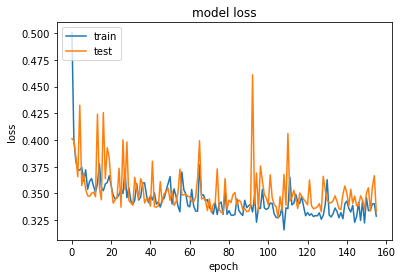

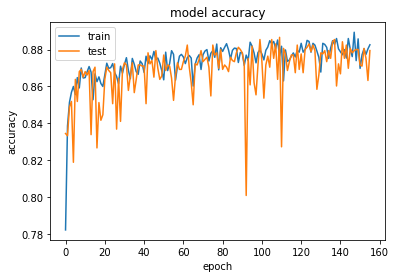

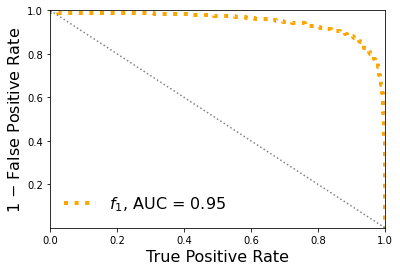

Classification score:


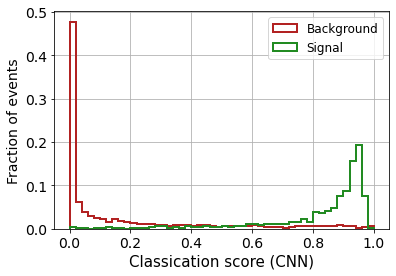


 ROC-AUC =  0.9488155193314962


In [41]:

# define the keras model
model = Sequential()
model.add(Conv1D(32, 2, input_shape=(X_mon_train.shape[1],1), strides = (1),kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.LeakyReLU(alpha=0.05))  
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train_cn,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_cn, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test_cn)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

In [42]:
print('\n ROC-AUC = ', roc_auc_cnn)


 ROC-AUC =  0.9488155193314962


Epoch 1/500
40/40 [==============================] - 2s 33ms/step - loss: 0.5710 - accuracy: 0.7398 - val_loss: 0.4656 - val_accuracy: 0.7990
Epoch 2/500
40/40 [==============================] - 1s 28ms/step - loss: 0.4095 - accuracy: 0.8395 - val_loss: 0.3715 - val_accuracy: 0.8482
Epoch 3/500
40/40 [==============================] - 1s 28ms/step - loss: 0.3758 - accuracy: 0.8520 - val_loss: 0.3796 - val_accuracy: 0.8440
Epoch 4/500
40/40 [==============================] - 1s 28ms/step - loss: 0.3739 - accuracy: 0.8569 - val_loss: 0.3572 - val_accuracy: 0.8584
Epoch 5/500
40/40 [==============================] - 1s 28ms/step - loss: 0.3675 - accuracy: 0.8605 - val_loss: 0.3803 - val_accuracy: 0.8452
Epoch 6/500
40/40 [==============================] - 1s 28ms/step - loss: 0.3889 - accuracy: 0.8519 - val_loss: 0.3727 - val_accuracy: 0.8488
Epoch 7/500
40/40 [==============================] - 1s 28ms/step - loss: 0.3608 - accuracy: 0.8617 - val_loss: 0.3611 - val_accuracy: 0.8572
Epoch 

40/40 [==============================] - 1s 27ms/step - loss: 0.3157 - accuracy: 0.8833 - val_loss: 0.3853 - val_accuracy: 0.8620
Epoch 116/500
40/40 [==============================] - 1s 27ms/step - loss: 0.3448 - accuracy: 0.8754 - val_loss: 0.3270 - val_accuracy: 0.8824
Epoch 117/500
40/40 [==============================] - 1s 27ms/step - loss: 0.3233 - accuracy: 0.8847 - val_loss: 0.3305 - val_accuracy: 0.8794
Epoch 118/500
40/40 [==============================] - 1s 28ms/step - loss: 0.3146 - accuracy: 0.8917 - val_loss: 0.3313 - val_accuracy: 0.8836
Epoch 119/500
40/40 [==============================] - 1s 28ms/step - loss: 0.3305 - accuracy: 0.8800 - val_loss: 0.3312 - val_accuracy: 0.8776
Epoch 120/500
40/40 [==============================] - 1s 28ms/step - loss: 0.3314 - accuracy: 0.8786 - val_loss: 0.3273 - val_accuracy: 0.8818
Epoch 121/500
40/40 [==============================] - 1s 28ms/step - loss: 0.3152 - accuracy: 0.8868 - val_loss: 0.3424 - val_accuracy: 0.8812
Epoch 

Epoch 172/500
40/40 [==============================] - 1s 28ms/step - loss: 0.3144 - accuracy: 0.8917 - val_loss: 0.3576 - val_accuracy: 0.8638
Epoch 173/500
40/40 [==============================] - 1s 27ms/step - loss: 0.3145 - accuracy: 0.8882 - val_loss: 0.3491 - val_accuracy: 0.8662
Epoch 174/500
40/40 [==============================] - 1s 27ms/step - loss: 0.3128 - accuracy: 0.8867 - val_loss: 0.3387 - val_accuracy: 0.8818
Epoch 175/500
40/40 [==============================] - 1s 27ms/step - loss: 0.3027 - accuracy: 0.8986 - val_loss: 0.3234 - val_accuracy: 0.8848
Epoch 176/500
40/40 [==============================] - 1s 27ms/step - loss: 0.3040 - accuracy: 0.8942 - val_loss: 0.3319 - val_accuracy: 0.8764
Epoch 177/500
40/40 [==============================] - 1s 27ms/step - loss: 0.2954 - accuracy: 0.8939 - val_loss: 0.3241 - val_accuracy: 0.8908
Epoch 178/500
40/40 [==============================] - 1s 28ms/step - loss: 0.3257 - accuracy: 0.8826 - val_loss: 0.3422 - val_accuracy:

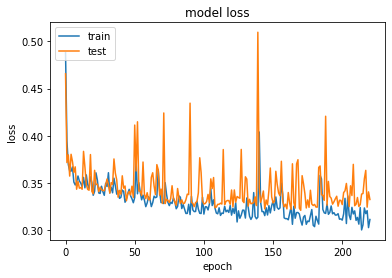

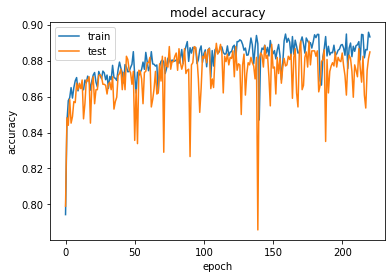

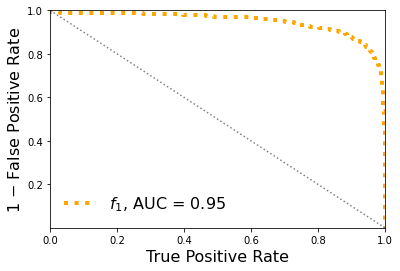

Classification score:


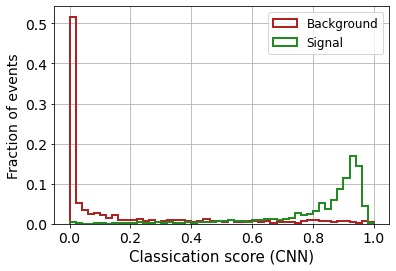


 ROC-AUC =  0.9484505432169152


In [43]:

# define the keras model
model = Sequential()
model.add(Conv1D(8, 3, input_shape=(X_mon_train.shape[1],1), strides = (1),kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.LeakyReLU(alpha=0.05))  
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train_cn,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_cn, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test_cn)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

In [44]:
print('\n ROC-AUC = ', roc_auc_cnn)


 ROC-AUC =  0.9484505432169152


Epoch 1/500
40/40 [==============================] - 3s 60ms/step - loss: 0.5397 - accuracy: 0.7617 - val_loss: 0.3952 - val_accuracy: 0.8440
Epoch 2/500
40/40 [==============================] - 2s 55ms/step - loss: 0.3851 - accuracy: 0.8505 - val_loss: 0.3734 - val_accuracy: 0.8542
Epoch 3/500
40/40 [==============================] - 2s 55ms/step - loss: 0.4031 - accuracy: 0.8531 - val_loss: 0.3695 - val_accuracy: 0.8560
Epoch 4/500
40/40 [==============================] - 2s 55ms/step - loss: 0.3785 - accuracy: 0.8592 - val_loss: 0.3590 - val_accuracy: 0.8620
Epoch 5/500
40/40 [==============================] - 2s 55ms/step - loss: 0.3613 - accuracy: 0.8674 - val_loss: 0.4648 - val_accuracy: 0.8116
Epoch 6/500
40/40 [==============================] - 2s 55ms/step - loss: 0.4008 - accuracy: 0.8423 - val_loss: 0.3555 - val_accuracy: 0.8662
Epoch 7/500
40/40 [==============================] - 2s 55ms/step - loss: 0.3649 - accuracy: 0.8622 - val_loss: 0.3511 - val_accuracy: 0.8686
Epoch 

40/40 [==============================] - 2s 53ms/step - loss: 0.3260 - accuracy: 0.8792 - val_loss: 0.3420 - val_accuracy: 0.8686
Epoch 116/500
40/40 [==============================] - 2s 52ms/step - loss: 0.3290 - accuracy: 0.8852 - val_loss: 0.3232 - val_accuracy: 0.8878
Epoch 117/500
40/40 [==============================] - 2s 52ms/step - loss: 0.3160 - accuracy: 0.8806 - val_loss: 0.3312 - val_accuracy: 0.8788
Epoch 118/500
40/40 [==============================] - 2s 52ms/step - loss: 0.3263 - accuracy: 0.8836 - val_loss: 0.3549 - val_accuracy: 0.8614
Epoch 119/500
40/40 [==============================] - 2s 53ms/step - loss: 0.3676 - accuracy: 0.8639 - val_loss: 0.3717 - val_accuracy: 0.8590
Epoch 120/500
40/40 [==============================] - 2s 52ms/step - loss: 0.3545 - accuracy: 0.8747 - val_loss: 0.3317 - val_accuracy: 0.8794
Epoch 121/500
40/40 [==============================] - 2s 52ms/step - loss: 0.3310 - accuracy: 0.8771 - val_loss: 0.3286 - val_accuracy: 0.8812
Epoch 

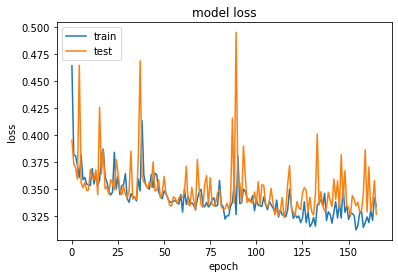

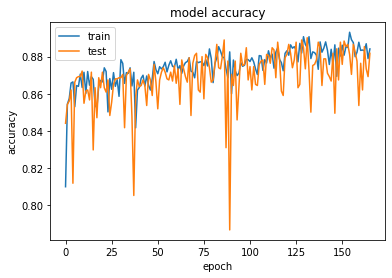

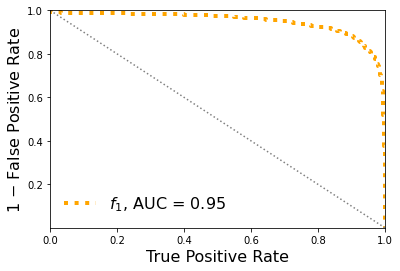

Classification score:


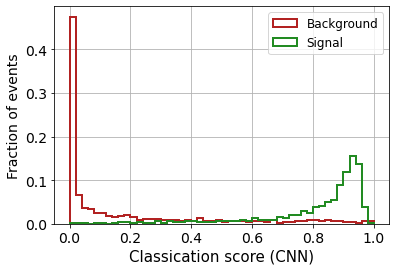


 ROC-AUC =  0.9492506831604197


In [45]:

# define the keras model
model = Sequential()
model.add(Conv1D(16, 3, input_shape=(X_mon_train.shape[1],1), strides = (1),kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.LeakyReLU(alpha=0.05))  
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train_cn,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_cn, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test_cn)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

In [46]:
print('\n ROC-AUC = ', roc_auc_cnn)


 ROC-AUC =  0.9492506831604197


Epoch 1/500
40/40 [==============================] - 5s 116ms/step - loss: 0.5707 - accuracy: 0.7093 - val_loss: 0.3892 - val_accuracy: 0.8416
Epoch 2/500
40/40 [==============================] - 4s 110ms/step - loss: 0.3902 - accuracy: 0.8498 - val_loss: 0.3660 - val_accuracy: 0.8548
Epoch 3/500
40/40 [==============================] - 4s 110ms/step - loss: 0.3722 - accuracy: 0.8550 - val_loss: 0.4043 - val_accuracy: 0.8338
Epoch 4/500
40/40 [==============================] - 4s 110ms/step - loss: 0.3867 - accuracy: 0.8508 - val_loss: 0.3770 - val_accuracy: 0.8536
Epoch 5/500
40/40 [==============================] - 4s 110ms/step - loss: 0.3845 - accuracy: 0.8507 - val_loss: 0.3817 - val_accuracy: 0.8482
Epoch 6/500
40/40 [==============================] - 4s 110ms/step - loss: 0.3846 - accuracy: 0.8534 - val_loss: 0.3897 - val_accuracy: 0.8410
Epoch 7/500
40/40 [==============================] - 4s 110ms/step - loss: 0.3551 - accuracy: 0.8607 - val_loss: 0.3508 - val_accuracy: 0.8650

Epoch 58/500
40/40 [==============================] - 4s 109ms/step - loss: 0.3534 - accuracy: 0.8766 - val_loss: 0.3558 - val_accuracy: 0.8680
Epoch 59/500
40/40 [==============================] - 4s 110ms/step - loss: 0.3716 - accuracy: 0.8613 - val_loss: 0.3613 - val_accuracy: 0.8596
Epoch 60/500
40/40 [==============================] - 4s 109ms/step - loss: 0.3510 - accuracy: 0.8732 - val_loss: 0.3497 - val_accuracy: 0.8698
Epoch 61/500
40/40 [==============================] - 4s 109ms/step - loss: 0.3452 - accuracy: 0.8716 - val_loss: 0.3405 - val_accuracy: 0.8752
Epoch 62/500
40/40 [==============================] - 4s 110ms/step - loss: 0.3442 - accuracy: 0.8736 - val_loss: 0.3931 - val_accuracy: 0.8428
Epoch 63/500
40/40 [==============================] - 4s 110ms/step - loss: 0.3672 - accuracy: 0.8643 - val_loss: 0.3481 - val_accuracy: 0.8710
Epoch 64/500
40/40 [==============================] - 4s 109ms/step - loss: 0.3486 - accuracy: 0.8644 - val_loss: 0.3405 - val_accuracy:

Epoch 115/500
40/40 [==============================] - 4s 109ms/step - loss: 0.3153 - accuracy: 0.8851 - val_loss: 0.3446 - val_accuracy: 0.8638
Epoch 116/500
40/40 [==============================] - 4s 110ms/step - loss: 0.3587 - accuracy: 0.8635 - val_loss: 0.3331 - val_accuracy: 0.8788
Epoch 117/500
40/40 [==============================] - 4s 109ms/step - loss: 0.3478 - accuracy: 0.8756 - val_loss: 0.3420 - val_accuracy: 0.8680
Epoch 118/500
40/40 [==============================] - 4s 109ms/step - loss: 0.3556 - accuracy: 0.8734 - val_loss: 0.3297 - val_accuracy: 0.8776
Epoch 119/500
40/40 [==============================] - 4s 109ms/step - loss: 0.3443 - accuracy: 0.8703 - val_loss: 0.3293 - val_accuracy: 0.8746
Epoch 120/500
40/40 [==============================] - 4s 109ms/step - loss: 0.3335 - accuracy: 0.8839 - val_loss: 0.3634 - val_accuracy: 0.8518
Epoch 121/500
40/40 [==============================] - 4s 109ms/step - loss: 0.3435 - accuracy: 0.8693 - val_loss: 0.3285 - val_ac

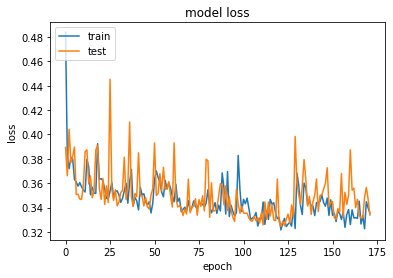

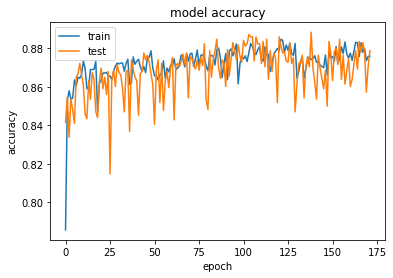

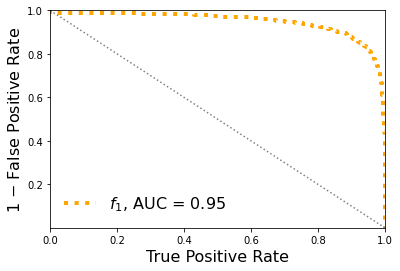

Classification score:


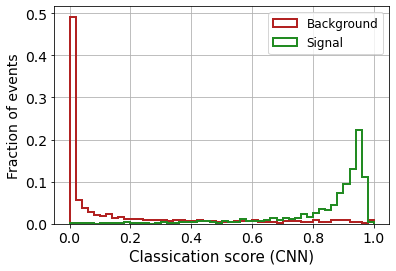


 ROC-AUC =  0.948951215579225


In [47]:

# define the keras model
model = Sequential()
model.add(Conv1D(32, 3, input_shape=(X_mon_train.shape[1],1), strides = (1),kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.LeakyReLU(alpha=0.05))  
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train_cn,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_cn, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test_cn)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

In [48]:
print('\n ROC-AUC = ', roc_auc_cnn)


 ROC-AUC =  0.948951215579225


##### 2 conv layers

Epoch 1/500
40/40 [==============================] - 2s 44ms/step - loss: 0.6019 - accuracy: 0.7286 - val_loss: 0.4274 - val_accuracy: 0.8392
Epoch 2/500
40/40 [==============================] - 2s 39ms/step - loss: 0.4320 - accuracy: 0.8403 - val_loss: 0.3856 - val_accuracy: 0.8632
Epoch 3/500
40/40 [==============================] - 2s 39ms/step - loss: 0.4063 - accuracy: 0.8529 - val_loss: 0.3794 - val_accuracy: 0.8650
Epoch 4/500
40/40 [==============================] - 2s 39ms/step - loss: 0.3833 - accuracy: 0.8669 - val_loss: 0.4437 - val_accuracy: 0.8308
Epoch 5/500
40/40 [==============================] - 2s 39ms/step - loss: 0.4150 - accuracy: 0.8477 - val_loss: 0.3756 - val_accuracy: 0.8626
Epoch 6/500
40/40 [==============================] - 2s 39ms/step - loss: 0.3819 - accuracy: 0.8641 - val_loss: 0.3633 - val_accuracy: 0.8698
Epoch 7/500
40/40 [==============================] - 2s 39ms/step - loss: 0.3691 - accuracy: 0.8630 - val_loss: 0.3597 - val_accuracy: 0.8656
Epoch 

40/40 [==============================] - 2s 38ms/step - loss: 0.3641 - accuracy: 0.8742 - val_loss: 0.3385 - val_accuracy: 0.8854
Epoch 116/500
40/40 [==============================] - 2s 38ms/step - loss: 0.3135 - accuracy: 0.8901 - val_loss: 0.3364 - val_accuracy: 0.8794
Epoch 117/500
40/40 [==============================] - 2s 38ms/step - loss: 0.3222 - accuracy: 0.8856 - val_loss: 0.3442 - val_accuracy: 0.8830
Epoch 118/500
40/40 [==============================] - 2s 38ms/step - loss: 0.3377 - accuracy: 0.8767 - val_loss: 0.3424 - val_accuracy: 0.8764
Epoch 119/500
40/40 [==============================] - 2s 38ms/step - loss: 0.3291 - accuracy: 0.8855 - val_loss: 0.3367 - val_accuracy: 0.8812
Epoch 120/500
40/40 [==============================] - 2s 38ms/step - loss: 0.3268 - accuracy: 0.8843 - val_loss: 0.3620 - val_accuracy: 0.8662
Epoch 121/500
40/40 [==============================] - 2s 38ms/step - loss: 0.3829 - accuracy: 0.8535 - val_loss: 0.3508 - val_accuracy: 0.8674
Epoch 

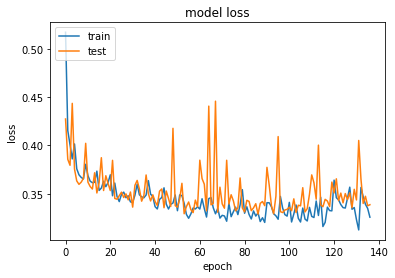

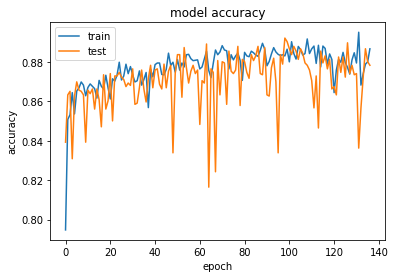

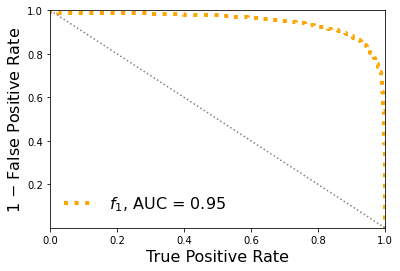

Classification score:


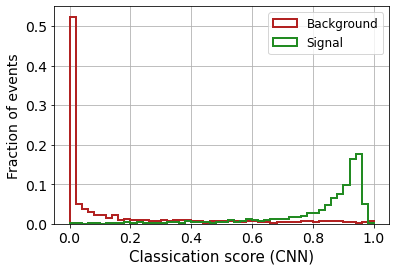


 ROC-AUC =  0.9499183662891648


In [49]:

# define the keras model
model = Sequential()
model.add(Conv1D(8, 2, input_shape=(X_mon_train.shape[1],1), strides = (1),kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Conv1D(8, 2, kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.LeakyReLU(alpha=0.05))  
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train_cn,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_cn, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test_cn)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

In [50]:
print('\n ROC-AUC = ', roc_auc_cnn)


 ROC-AUC =  0.9499183662891648


Epoch 1/500
40/40 [==============================] - 4s 82ms/step - loss: 0.6604 - accuracy: 0.7109 - val_loss: 0.4639 - val_accuracy: 0.8302
Epoch 2/500
40/40 [==============================] - 3s 77ms/step - loss: 0.4559 - accuracy: 0.8455 - val_loss: 0.4120 - val_accuracy: 0.8608
Epoch 3/500
40/40 [==============================] - 3s 76ms/step - loss: 0.4243 - accuracy: 0.8509 - val_loss: 0.3991 - val_accuracy: 0.8572
Epoch 4/500
40/40 [==============================] - 3s 77ms/step - loss: 0.3933 - accuracy: 0.8650 - val_loss: 0.3848 - val_accuracy: 0.8710
Epoch 5/500
40/40 [==============================] - 3s 76ms/step - loss: 0.3890 - accuracy: 0.8627 - val_loss: 0.3898 - val_accuracy: 0.8704
Epoch 6/500
40/40 [==============================] - 3s 77ms/step - loss: 0.3962 - accuracy: 0.8657 - val_loss: 0.3729 - val_accuracy: 0.8668
Epoch 7/500
40/40 [==============================] - 3s 77ms/step - loss: 0.3732 - accuracy: 0.8714 - val_loss: 0.3953 - val_accuracy: 0.8464
Epoch 

40/40 [==============================] - 3s 76ms/step - loss: 0.3310 - accuracy: 0.8789 - val_loss: 0.3302 - val_accuracy: 0.8782
Epoch 116/500
40/40 [==============================] - 3s 76ms/step - loss: 0.3345 - accuracy: 0.8792 - val_loss: 0.3256 - val_accuracy: 0.8848
Epoch 117/500
40/40 [==============================] - 3s 76ms/step - loss: 0.3178 - accuracy: 0.8902 - val_loss: 0.3300 - val_accuracy: 0.8860
Epoch 118/500
40/40 [==============================] - 3s 76ms/step - loss: 0.3180 - accuracy: 0.8923 - val_loss: 0.3301 - val_accuracy: 0.8794
Epoch 119/500
40/40 [==============================] - 3s 76ms/step - loss: 0.3240 - accuracy: 0.8855 - val_loss: 0.3320 - val_accuracy: 0.8878
Epoch 120/500
40/40 [==============================] - 3s 76ms/step - loss: 0.3307 - accuracy: 0.8863 - val_loss: 0.3713 - val_accuracy: 0.8650
Epoch 121/500
40/40 [==============================] - 3s 76ms/step - loss: 0.3465 - accuracy: 0.8757 - val_loss: 0.3455 - val_accuracy: 0.8698
Epoch 

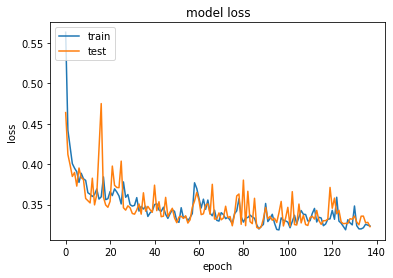

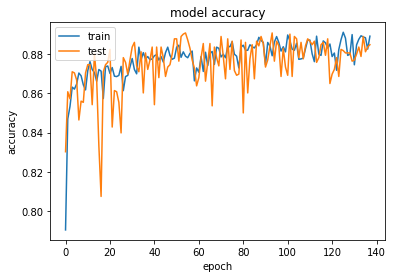

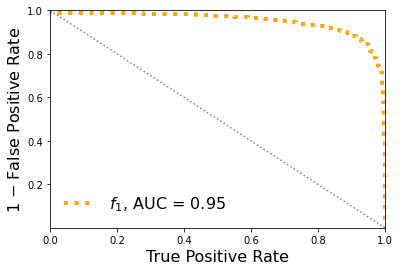

Classification score:


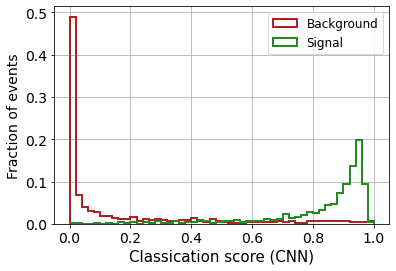


 ROC-AUC =  0.951465735437669


In [51]:

# define the keras model
model = Sequential()
model.add(Conv1D(16, 2, input_shape=(X_mon_train.shape[1],1), strides = (1),kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Conv1D(16, 2, kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.LeakyReLU(alpha=0.05))  
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train_cn,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_cn, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test_cn)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

In [52]:
print('\n ROC-AUC = ', roc_auc_cnn)


 ROC-AUC =  0.951465735437669


Epoch 1/500
40/40 [==============================] - 7s 164ms/step - loss: 0.7426 - accuracy: 0.7258 - val_loss: 0.5123 - val_accuracy: 0.8386
Epoch 2/500
40/40 [==============================] - 6s 159ms/step - loss: 0.4904 - accuracy: 0.8526 - val_loss: 0.4732 - val_accuracy: 0.8434
Epoch 3/500
40/40 [==============================] - 6s 158ms/step - loss: 0.4811 - accuracy: 0.8501 - val_loss: 0.4256 - val_accuracy: 0.8590
Epoch 4/500
40/40 [==============================] - 6s 158ms/step - loss: 0.4300 - accuracy: 0.8594 - val_loss: 0.3956 - val_accuracy: 0.8680
Epoch 5/500
40/40 [==============================] - 6s 158ms/step - loss: 0.4075 - accuracy: 0.8660 - val_loss: 0.4203 - val_accuracy: 0.8494
Epoch 6/500
40/40 [==============================] - 6s 158ms/step - loss: 0.3966 - accuracy: 0.8634 - val_loss: 0.3766 - val_accuracy: 0.8692
Epoch 7/500
40/40 [==============================] - 6s 158ms/step - loss: 0.3940 - accuracy: 0.8610 - val_loss: 0.3808 - val_accuracy: 0.8662

Epoch 58/500
40/40 [==============================] - 6s 161ms/step - loss: 0.3488 - accuracy: 0.8795 - val_loss: 0.3275 - val_accuracy: 0.8908
Epoch 59/500
40/40 [==============================] - 6s 160ms/step - loss: 0.3300 - accuracy: 0.8829 - val_loss: 0.3381 - val_accuracy: 0.8758
Epoch 60/500
40/40 [==============================] - 6s 160ms/step - loss: 0.3325 - accuracy: 0.8815 - val_loss: 0.3328 - val_accuracy: 0.8842
Epoch 61/500
40/40 [==============================] - 6s 160ms/step - loss: 0.3359 - accuracy: 0.8865 - val_loss: 0.3246 - val_accuracy: 0.8836
Epoch 62/500
40/40 [==============================] - 6s 161ms/step - loss: 0.3338 - accuracy: 0.8845 - val_loss: 0.3253 - val_accuracy: 0.8848
Epoch 63/500
40/40 [==============================] - 6s 161ms/step - loss: 0.3328 - accuracy: 0.8792 - val_loss: 0.3257 - val_accuracy: 0.8842
Epoch 64/500
40/40 [==============================] - 6s 160ms/step - loss: 0.3395 - accuracy: 0.8840 - val_loss: 0.3605 - val_accuracy:

Epoch 115/500
40/40 [==============================] - 6s 159ms/step - loss: 0.3237 - accuracy: 0.8842 - val_loss: 0.3315 - val_accuracy: 0.8914
Epoch 116/500
40/40 [==============================] - 6s 158ms/step - loss: 0.3157 - accuracy: 0.8883 - val_loss: 0.3231 - val_accuracy: 0.8866
Epoch 117/500
40/40 [==============================] - 6s 158ms/step - loss: 0.3192 - accuracy: 0.8948 - val_loss: 0.3202 - val_accuracy: 0.8914
Epoch 118/500
40/40 [==============================] - 6s 159ms/step - loss: 0.3250 - accuracy: 0.8890 - val_loss: 0.3222 - val_accuracy: 0.8914
Epoch 119/500
40/40 [==============================] - 6s 158ms/step - loss: 0.3184 - accuracy: 0.8891 - val_loss: 0.3298 - val_accuracy: 0.8806
Epoch 120/500
40/40 [==============================] - 6s 158ms/step - loss: 0.3247 - accuracy: 0.8900 - val_loss: 0.3387 - val_accuracy: 0.8848
Epoch 121/500
40/40 [==============================] - 6s 158ms/step - loss: 0.3203 - accuracy: 0.8816 - val_loss: 0.3213 - val_ac

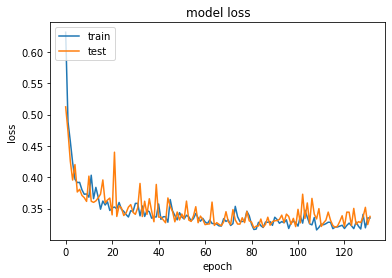

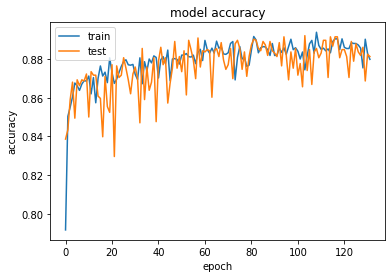

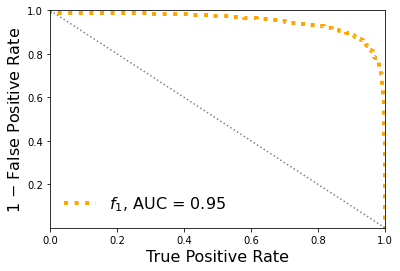

Classification score:


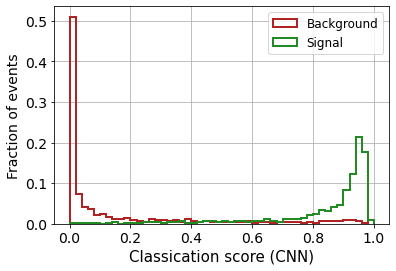


 ROC-AUC =  0.9510446091516142


In [53]:

# define the keras model
model = Sequential()
model.add(Conv1D(32, 2, input_shape=(X_mon_train.shape[1],1), strides = (1),kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Conv1D(32, 2, kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.LeakyReLU(alpha=0.05))  
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train_cn,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_cn, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test_cn)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

In [54]:
print('\n ROC-AUC = ', roc_auc_cnn)


 ROC-AUC =  0.9510446091516142


Epoch 1/500
40/40 [==============================] - 3s 46ms/step - loss: 0.6258 - accuracy: 0.6924 - val_loss: 0.4202 - val_accuracy: 0.8416
Epoch 2/500
40/40 [==============================] - 2s 41ms/step - loss: 0.4230 - accuracy: 0.8481 - val_loss: 0.3836 - val_accuracy: 0.8608
Epoch 3/500
40/40 [==============================] - 2s 41ms/step - loss: 0.3924 - accuracy: 0.8572 - val_loss: 0.4529 - val_accuracy: 0.8182
Epoch 4/500
40/40 [==============================] - 2s 41ms/step - loss: 0.4184 - accuracy: 0.8444 - val_loss: 0.3730 - val_accuracy: 0.8590
Epoch 5/500
40/40 [==============================] - 2s 41ms/step - loss: 0.3848 - accuracy: 0.8586 - val_loss: 0.3683 - val_accuracy: 0.8656
Epoch 6/500
40/40 [==============================] - 2s 41ms/step - loss: 0.3811 - accuracy: 0.8583 - val_loss: 0.3910 - val_accuracy: 0.8470
Epoch 7/500
40/40 [==============================] - 2s 41ms/step - loss: 0.3872 - accuracy: 0.8604 - val_loss: 0.3623 - val_accuracy: 0.8626
Epoch 

40/40 [==============================] - 2s 40ms/step - loss: 0.3268 - accuracy: 0.8843 - val_loss: 0.3301 - val_accuracy: 0.8878
Epoch 116/500
40/40 [==============================] - 2s 40ms/step - loss: 0.3269 - accuracy: 0.8808 - val_loss: 0.3300 - val_accuracy: 0.8884
Epoch 117/500
40/40 [==============================] - 2s 40ms/step - loss: 0.3440 - accuracy: 0.8739 - val_loss: 0.3297 - val_accuracy: 0.8758
Epoch 118/500
40/40 [==============================] - 2s 40ms/step - loss: 0.3307 - accuracy: 0.8819 - val_loss: 0.3254 - val_accuracy: 0.8908
Epoch 119/500
40/40 [==============================] - 2s 40ms/step - loss: 0.3286 - accuracy: 0.8866 - val_loss: 0.3419 - val_accuracy: 0.8704
Epoch 120/500
40/40 [==============================] - 2s 40ms/step - loss: 0.3166 - accuracy: 0.8824 - val_loss: 0.3145 - val_accuracy: 0.8902
Epoch 121/500
40/40 [==============================] - 2s 40ms/step - loss: 0.3166 - accuracy: 0.8846 - val_loss: 0.3393 - val_accuracy: 0.8848
Epoch 

Epoch 172/500
40/40 [==============================] - 2s 40ms/step - loss: 0.3173 - accuracy: 0.8894 - val_loss: 0.3186 - val_accuracy: 0.8914
Epoch 173/500
40/40 [==============================] - 2s 40ms/step - loss: 0.3143 - accuracy: 0.8894 - val_loss: 0.3228 - val_accuracy: 0.8842
Epoch 174/500
40/40 [==============================] - 2s 40ms/step - loss: 0.3121 - accuracy: 0.8883 - val_loss: 0.3318 - val_accuracy: 0.8800
Epoch 175/500
40/40 [==============================] - 2s 40ms/step - loss: 0.3253 - accuracy: 0.8834 - val_loss: 0.3124 - val_accuracy: 0.8926
Epoch 176/500
40/40 [==============================] - 2s 40ms/step - loss: 0.3082 - accuracy: 0.8879 - val_loss: 0.3154 - val_accuracy: 0.8860
Epoch 177/500
40/40 [==============================] - 2s 40ms/step - loss: 0.3208 - accuracy: 0.8829 - val_loss: 0.3108 - val_accuracy: 0.8908
Epoch 178/500
40/40 [==============================] - 2s 40ms/step - loss: 0.3021 - accuracy: 0.8982 - val_loss: 0.3152 - val_accuracy:

Epoch 229/500
40/40 [==============================] - 2s 40ms/step - loss: 0.3140 - accuracy: 0.8870 - val_loss: 0.3168 - val_accuracy: 0.8878
Epoch 230/500
40/40 [==============================] - 2s 40ms/step - loss: 0.3077 - accuracy: 0.8885 - val_loss: 0.3390 - val_accuracy: 0.8710
Epoch 231/500
40/40 [==============================] - 2s 40ms/step - loss: 0.3415 - accuracy: 0.8730 - val_loss: 0.3210 - val_accuracy: 0.8788
Epoch 232/500
40/40 [==============================] - 2s 40ms/step - loss: 0.3062 - accuracy: 0.8996 - val_loss: 0.3197 - val_accuracy: 0.8848
Epoch 233/500
40/40 [==============================] - 2s 40ms/step - loss: 0.3134 - accuracy: 0.8887 - val_loss: 0.3211 - val_accuracy: 0.8866
Epoch 234/500
40/40 [==============================] - 2s 40ms/step - loss: 0.3134 - accuracy: 0.8890 - val_loss: 0.3243 - val_accuracy: 0.8956
Epoch 235/500
40/40 [==============================] - 2s 40ms/step - loss: 0.3225 - accuracy: 0.8826 - val_loss: 0.3143 - val_accuracy:

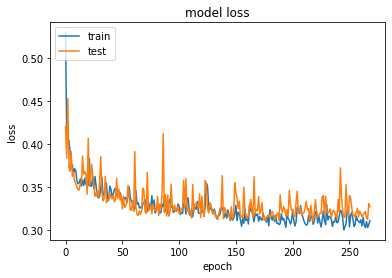

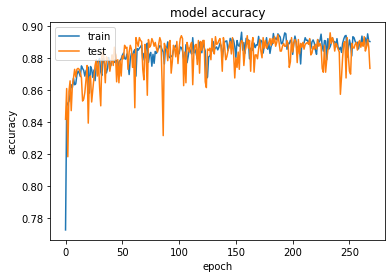

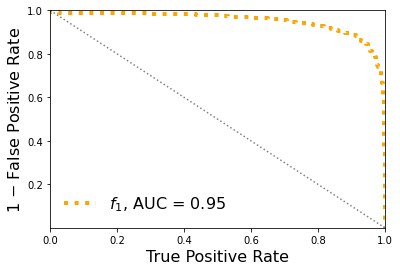

Classification score:


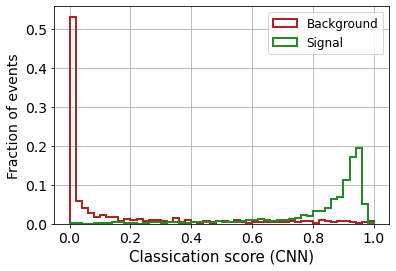


 ROC-AUC =  0.9520823075128929


In [55]:

# define the keras model
model = Sequential()
model.add(Conv1D(8, 3, input_shape=(X_mon_train.shape[1],1), strides = (1),kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Conv1D(8, 3, kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.LeakyReLU(alpha=0.05))  
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train_cn,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_cn, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test_cn)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

In [56]:
print('\n ROC-AUC = ', roc_auc_cnn)


 ROC-AUC =  0.9520823075128929


Epoch 1/500
40/40 [==============================] - 4s 87ms/step - loss: 0.6438 - accuracy: 0.7391 - val_loss: 0.4931 - val_accuracy: 0.8230
Epoch 2/500
40/40 [==============================] - 3s 81ms/step - loss: 0.4618 - accuracy: 0.8370 - val_loss: 0.4115 - val_accuracy: 0.8542
Epoch 3/500
40/40 [==============================] - 3s 81ms/step - loss: 0.4126 - accuracy: 0.8660 - val_loss: 0.3936 - val_accuracy: 0.8614
Epoch 4/500
40/40 [==============================] - 3s 81ms/step - loss: 0.3981 - accuracy: 0.8649 - val_loss: 0.3850 - val_accuracy: 0.8686
Epoch 5/500
40/40 [==============================] - 3s 81ms/step - loss: 0.4414 - accuracy: 0.8389 - val_loss: 0.3844 - val_accuracy: 0.8602
Epoch 6/500
40/40 [==============================] - 3s 81ms/step - loss: 0.3799 - accuracy: 0.8705 - val_loss: 0.3645 - val_accuracy: 0.8716
Epoch 7/500
40/40 [==============================] - 3s 81ms/step - loss: 0.3513 - accuracy: 0.8836 - val_loss: 0.3662 - val_accuracy: 0.8734
Epoch 

40/40 [==============================] - 3s 81ms/step - loss: 0.3147 - accuracy: 0.8873 - val_loss: 0.3118 - val_accuracy: 0.8872
Epoch 116/500
40/40 [==============================] - 3s 81ms/step - loss: 0.3315 - accuracy: 0.8769 - val_loss: 0.3331 - val_accuracy: 0.8818
Epoch 117/500
40/40 [==============================] - 3s 81ms/step - loss: 0.3299 - accuracy: 0.8804 - val_loss: 0.3391 - val_accuracy: 0.8698
Epoch 118/500
40/40 [==============================] - 3s 81ms/step - loss: 0.3588 - accuracy: 0.8703 - val_loss: 0.3265 - val_accuracy: 0.8806
Epoch 119/500
40/40 [==============================] - 3s 81ms/step - loss: 0.3230 - accuracy: 0.8907 - val_loss: 0.3168 - val_accuracy: 0.8860
Epoch 120/500
40/40 [==============================] - 3s 81ms/step - loss: 0.3152 - accuracy: 0.8879 - val_loss: 0.3385 - val_accuracy: 0.8770
Epoch 121/500
40/40 [==============================] - 3s 81ms/step - loss: 0.3244 - accuracy: 0.8774 - val_loss: 0.3194 - val_accuracy: 0.8920
Epoch 

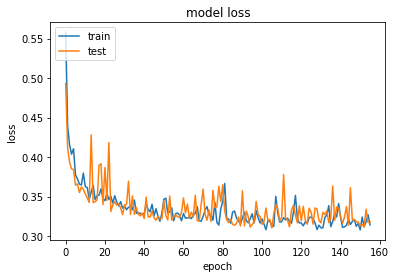

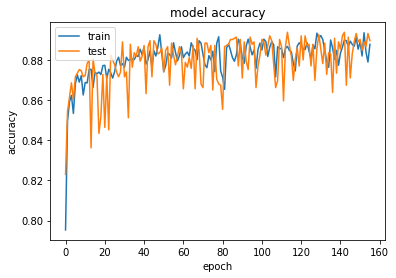

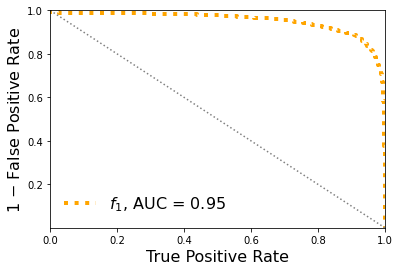

Classification score:


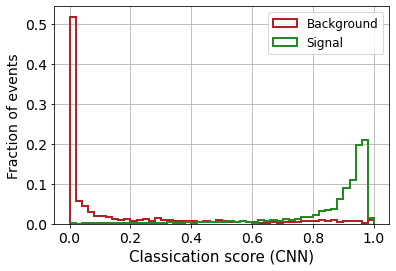


 ROC-AUC =  0.9527525102006145


In [57]:

# define the keras model
model = Sequential()
model.add(Conv1D(16, 3, input_shape=(X_mon_train.shape[1],1), strides = (1),kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Conv1D(16, 3, kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.LeakyReLU(alpha=0.05))  
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train_cn,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_cn, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test_cn)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

In [58]:
print('\n ROC-AUC = ', roc_auc_cnn)


 ROC-AUC =  0.9527525102006145


Epoch 1/500
40/40 [==============================] - 8s 174ms/step - loss: 0.7083 - accuracy: 0.7451 - val_loss: 0.5178 - val_accuracy: 0.8308
Epoch 2/500
40/40 [==============================] - 7s 168ms/step - loss: 0.5119 - accuracy: 0.8403 - val_loss: 0.4319 - val_accuracy: 0.8602
Epoch 3/500
40/40 [==============================] - 7s 169ms/step - loss: 0.4299 - accuracy: 0.8672 - val_loss: 0.4150 - val_accuracy: 0.8560
Epoch 4/500
40/40 [==============================] - 7s 170ms/step - loss: 0.4088 - accuracy: 0.8664 - val_loss: 0.4357 - val_accuracy: 0.8428
Epoch 5/500
40/40 [==============================] - 7s 170ms/step - loss: 0.4114 - accuracy: 0.8528 - val_loss: 0.3777 - val_accuracy: 0.8734
Epoch 6/500
40/40 [==============================] - 7s 168ms/step - loss: 0.4065 - accuracy: 0.8606 - val_loss: 0.3796 - val_accuracy: 0.8590
Epoch 7/500
40/40 [==============================] - 7s 168ms/step - loss: 0.3875 - accuracy: 0.8619 - val_loss: 0.5336 - val_accuracy: 0.7858

Epoch 58/500
40/40 [==============================] - 7s 168ms/step - loss: 0.3139 - accuracy: 0.8848 - val_loss: 0.3375 - val_accuracy: 0.8716
Epoch 59/500
40/40 [==============================] - 7s 169ms/step - loss: 0.3357 - accuracy: 0.8765 - val_loss: 0.3235 - val_accuracy: 0.8860
Epoch 60/500
40/40 [==============================] - 7s 168ms/step - loss: 0.3210 - accuracy: 0.8815 - val_loss: 0.3229 - val_accuracy: 0.8842
Epoch 61/500
40/40 [==============================] - 7s 168ms/step - loss: 0.3243 - accuracy: 0.8865 - val_loss: 0.3179 - val_accuracy: 0.8908
Epoch 62/500
40/40 [==============================] - 7s 169ms/step - loss: 0.3127 - accuracy: 0.8938 - val_loss: 0.3229 - val_accuracy: 0.8788
Epoch 63/500
40/40 [==============================] - 7s 169ms/step - loss: 0.3205 - accuracy: 0.8868 - val_loss: 0.3268 - val_accuracy: 0.8920
Epoch 64/500
40/40 [==============================] - 7s 168ms/step - loss: 0.3169 - accuracy: 0.8904 - val_loss: 0.3239 - val_accuracy:

Epoch 115/500
40/40 [==============================] - 7s 168ms/step - loss: 0.3225 - accuracy: 0.8844 - val_loss: 0.3256 - val_accuracy: 0.8752
Epoch 116/500
40/40 [==============================] - 7s 168ms/step - loss: 0.3367 - accuracy: 0.8786 - val_loss: 0.3200 - val_accuracy: 0.8848
Epoch 117/500
40/40 [==============================] - 7s 168ms/step - loss: 0.3218 - accuracy: 0.8864 - val_loss: 0.3674 - val_accuracy: 0.8626
Epoch 118/500
40/40 [==============================] - 7s 168ms/step - loss: 0.3585 - accuracy: 0.8658 - val_loss: 0.3384 - val_accuracy: 0.8878
Epoch 119/500
40/40 [==============================] - 7s 168ms/step - loss: 0.3154 - accuracy: 0.8852 - val_loss: 0.3165 - val_accuracy: 0.8884
Epoch 120/500
40/40 [==============================] - 7s 168ms/step - loss: 0.3117 - accuracy: 0.8866 - val_loss: 0.3175 - val_accuracy: 0.8878
Epoch 121/500
40/40 [==============================] - 7s 168ms/step - loss: 0.3113 - accuracy: 0.8910 - val_loss: 0.3129 - val_ac

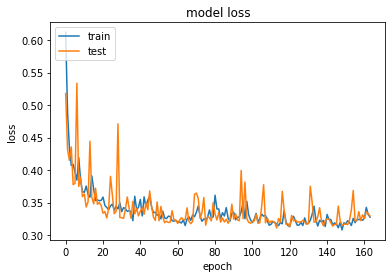

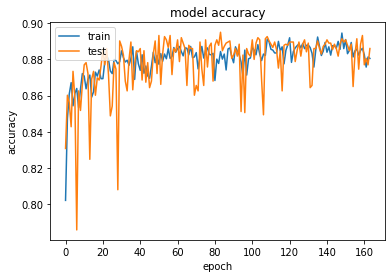

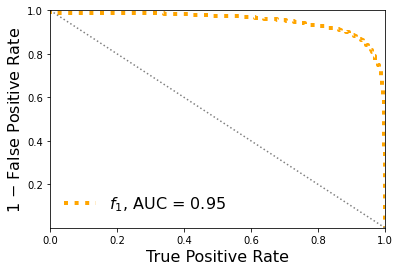

Classification score:


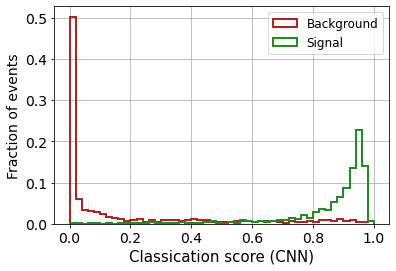


 ROC-AUC =  0.952405530935865


In [59]:

# define the keras model
model = Sequential()
model.add(Conv1D(32, 3, input_shape=(X_mon_train.shape[1],1), strides = (1),kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Conv1D(32, 3, kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.LeakyReLU(alpha=0.05))  
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train_cn,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_cn, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test_cn)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

In [60]:
print('\n ROC-AUC = ', roc_auc_cnn)


 ROC-AUC =  0.952405530935865


##### 3 conv layers

Epoch 1/500
40/40 [==============================] - 3s 62ms/step - loss: 0.6700 - accuracy: 0.7190 - val_loss: 0.4715 - val_accuracy: 0.8422
Epoch 2/500
40/40 [==============================] - 2s 56ms/step - loss: 0.4493 - accuracy: 0.8523 - val_loss: 0.4436 - val_accuracy: 0.8452
Epoch 3/500
40/40 [==============================] - 2s 56ms/step - loss: 0.4209 - accuracy: 0.8641 - val_loss: 0.4161 - val_accuracy: 0.8548
Epoch 4/500
40/40 [==============================] - 2s 56ms/step - loss: 0.4155 - accuracy: 0.8545 - val_loss: 0.4007 - val_accuracy: 0.8650
Epoch 5/500
40/40 [==============================] - 2s 56ms/step - loss: 0.4143 - accuracy: 0.8608 - val_loss: 0.4163 - val_accuracy: 0.8494
Epoch 6/500
40/40 [==============================] - 2s 55ms/step - loss: 0.3891 - accuracy: 0.8702 - val_loss: 0.3734 - val_accuracy: 0.8722
Epoch 7/500
40/40 [==============================] - 2s 56ms/step - loss: 0.3935 - accuracy: 0.8652 - val_loss: 0.3723 - val_accuracy: 0.8746
Epoch 

40/40 [==============================] - 2s 55ms/step - loss: 0.3363 - accuracy: 0.8811 - val_loss: 0.3149 - val_accuracy: 0.8860
Epoch 116/500
40/40 [==============================] - 2s 55ms/step - loss: 0.3227 - accuracy: 0.8884 - val_loss: 0.3347 - val_accuracy: 0.8848
Epoch 117/500
40/40 [==============================] - 2s 55ms/step - loss: 0.3392 - accuracy: 0.8762 - val_loss: 0.3346 - val_accuracy: 0.8818
Epoch 118/500
40/40 [==============================] - 2s 55ms/step - loss: 0.3387 - accuracy: 0.8755 - val_loss: 0.3332 - val_accuracy: 0.8746
Epoch 119/500
40/40 [==============================] - 2s 54ms/step - loss: 0.3253 - accuracy: 0.8814 - val_loss: 0.3198 - val_accuracy: 0.8878
Epoch 120/500
40/40 [==============================] - 2s 55ms/step - loss: 0.3259 - accuracy: 0.8831 - val_loss: 0.3259 - val_accuracy: 0.8758
Epoch 121/500
40/40 [==============================] - 2s 55ms/step - loss: 0.3183 - accuracy: 0.8895 - val_loss: 0.3572 - val_accuracy: 0.8686
Epoch 

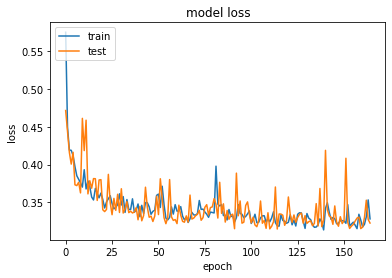

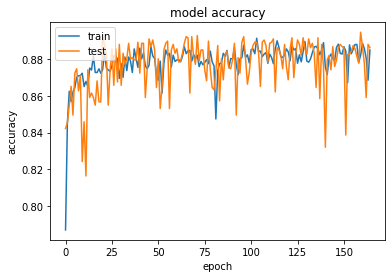

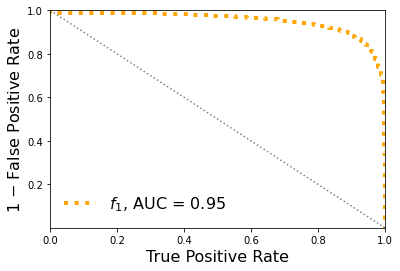

Classification score:


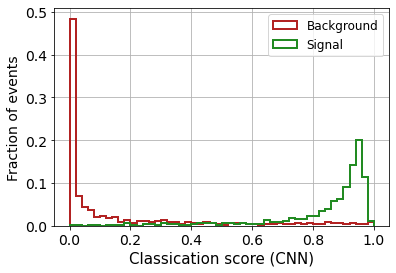


 ROC-AUC =  0.9519782857208674


In [61]:

# define the keras model
model = Sequential()
model.add(Conv1D(8, 3, input_shape=(X_mon_train.shape[1],1), strides = (1),kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Conv1D(8, 3, kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Conv1D(8, 3, kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.LeakyReLU(alpha=0.05))  
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train_cn,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_cn, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test_cn)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

In [62]:
print('\n ROC-AUC = ', roc_auc_cnn)


 ROC-AUC =  0.9519782857208674


Epoch 1/500
40/40 [==============================] - 5s 115ms/step - loss: 0.7192 - accuracy: 0.7420 - val_loss: 0.5038 - val_accuracy: 0.8464
Epoch 2/500
40/40 [==============================] - 4s 109ms/step - loss: 0.5056 - accuracy: 0.8482 - val_loss: 0.4463 - val_accuracy: 0.8656
Epoch 3/500
40/40 [==============================] - 4s 109ms/step - loss: 0.4547 - accuracy: 0.8605 - val_loss: 0.4398 - val_accuracy: 0.8554
Epoch 4/500
40/40 [==============================] - 4s 109ms/step - loss: 0.4501 - accuracy: 0.8619 - val_loss: 0.4545 - val_accuracy: 0.8428
Epoch 5/500
40/40 [==============================] - 4s 108ms/step - loss: 0.4535 - accuracy: 0.8486 - val_loss: 0.4159 - val_accuracy: 0.8614
Epoch 6/500
40/40 [==============================] - 4s 109ms/step - loss: 0.4148 - accuracy: 0.8635 - val_loss: 0.4030 - val_accuracy: 0.8566
Epoch 7/500
40/40 [==============================] - 4s 109ms/step - loss: 0.4151 - accuracy: 0.8587 - val_loss: 0.4078 - val_accuracy: 0.8482

Epoch 58/500
40/40 [==============================] - 4s 108ms/step - loss: 0.3410 - accuracy: 0.8789 - val_loss: 0.3424 - val_accuracy: 0.8818
Epoch 59/500
40/40 [==============================] - 4s 107ms/step - loss: 0.3335 - accuracy: 0.8880 - val_loss: 0.3698 - val_accuracy: 0.8716
Epoch 60/500
40/40 [==============================] - 4s 107ms/step - loss: 0.3538 - accuracy: 0.8767 - val_loss: 0.3239 - val_accuracy: 0.8872
Epoch 61/500
40/40 [==============================] - 4s 107ms/step - loss: 0.3355 - accuracy: 0.8792 - val_loss: 0.3350 - val_accuracy: 0.8830
Epoch 62/500
40/40 [==============================] - 4s 108ms/step - loss: 0.3169 - accuracy: 0.8912 - val_loss: 0.3295 - val_accuracy: 0.8908
Epoch 63/500
40/40 [==============================] - 4s 108ms/step - loss: 0.3471 - accuracy: 0.8781 - val_loss: 0.3240 - val_accuracy: 0.8902
Epoch 64/500
40/40 [==============================] - 4s 108ms/step - loss: 0.3202 - accuracy: 0.8848 - val_loss: 0.3185 - val_accuracy:

Epoch 115/500
40/40 [==============================] - 4s 108ms/step - loss: 0.3069 - accuracy: 0.8991 - val_loss: 0.3394 - val_accuracy: 0.8830
Epoch 116/500
40/40 [==============================] - 4s 108ms/step - loss: 0.3240 - accuracy: 0.8883 - val_loss: 0.3170 - val_accuracy: 0.8908
Epoch 117/500
40/40 [==============================] - 4s 107ms/step - loss: 0.3122 - accuracy: 0.8873 - val_loss: 0.3346 - val_accuracy: 0.8914
Epoch 118/500
40/40 [==============================] - 4s 107ms/step - loss: 0.3264 - accuracy: 0.8859 - val_loss: 0.4432 - val_accuracy: 0.8428
Epoch 119/500
40/40 [==============================] - 4s 108ms/step - loss: 0.3597 - accuracy: 0.8677 - val_loss: 0.3168 - val_accuracy: 0.8872
Epoch 120/500
40/40 [==============================] - 4s 107ms/step - loss: 0.3103 - accuracy: 0.8953 - val_loss: 0.3861 - val_accuracy: 0.8602
Epoch 121/500
40/40 [==============================] - 4s 107ms/step - loss: 0.3462 - accuracy: 0.8825 - val_loss: 0.3190 - val_ac

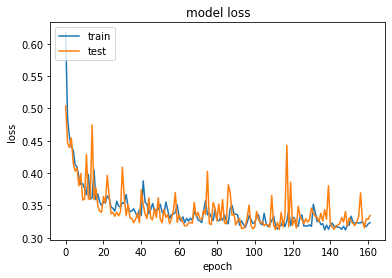

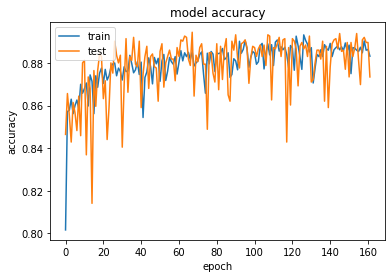

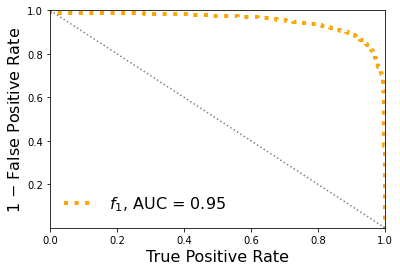

Classification score:


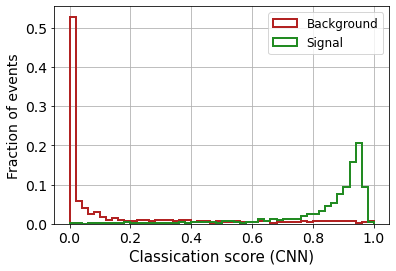


 ROC-AUC =  0.9529508354857565


In [63]:

# define the keras model
model = Sequential()
model.add(Conv1D(16, 3, input_shape=(X_mon_train.shape[1],1), strides = (1),kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Conv1D(16, 3, kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Conv1D(16, 3, kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.LeakyReLU(alpha=0.05))  
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train_cn,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_cn, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test_cn)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

In [64]:
print('\n ROC-AUC = ', roc_auc_cnn)


 ROC-AUC =  0.9529508354857565


Epoch 1/500
40/40 [==============================] - 10s 230ms/step - loss: 0.8116 - accuracy: 0.7568 - val_loss: 0.6158 - val_accuracy: 0.8230
Epoch 2/500
40/40 [==============================] - 9s 225ms/step - loss: 0.5822 - accuracy: 0.8415 - val_loss: 0.5235 - val_accuracy: 0.8386
Epoch 3/500
40/40 [==============================] - 9s 223ms/step - loss: 0.4874 - accuracy: 0.8593 - val_loss: 0.4333 - val_accuracy: 0.8710
Epoch 4/500
40/40 [==============================] - 9s 223ms/step - loss: 0.4422 - accuracy: 0.8618 - val_loss: 0.4554 - val_accuracy: 0.8344
Epoch 5/500
40/40 [==============================] - 9s 223ms/step - loss: 0.4358 - accuracy: 0.8589 - val_loss: 0.4031 - val_accuracy: 0.8626
Epoch 6/500
40/40 [==============================] - 9s 223ms/step - loss: 0.4127 - accuracy: 0.8569 - val_loss: 0.5025 - val_accuracy: 0.8038
Epoch 7/500
40/40 [==============================] - 9s 223ms/step - loss: 0.4734 - accuracy: 0.8221 - val_loss: 0.4265 - val_accuracy: 0.847

Epoch 58/500
40/40 [==============================] - 9s 222ms/step - loss: 0.3276 - accuracy: 0.8850 - val_loss: 0.3451 - val_accuracy: 0.8746
Epoch 59/500
40/40 [==============================] - 9s 223ms/step - loss: 0.3277 - accuracy: 0.8810 - val_loss: 0.3288 - val_accuracy: 0.8884
Epoch 60/500
40/40 [==============================] - 9s 223ms/step - loss: 0.3391 - accuracy: 0.8788 - val_loss: 0.3236 - val_accuracy: 0.8884
Epoch 61/500
40/40 [==============================] - 9s 223ms/step - loss: 0.3429 - accuracy: 0.8725 - val_loss: 0.3239 - val_accuracy: 0.8860
Epoch 62/500
40/40 [==============================] - 9s 223ms/step - loss: 0.3198 - accuracy: 0.8897 - val_loss: 0.3270 - val_accuracy: 0.8848
Epoch 63/500
40/40 [==============================] - 9s 222ms/step - loss: 0.3387 - accuracy: 0.8804 - val_loss: 0.3165 - val_accuracy: 0.8842
Epoch 64/500
40/40 [==============================] - 9s 222ms/step - loss: 0.3277 - accuracy: 0.8833 - val_loss: 0.3301 - val_accuracy:

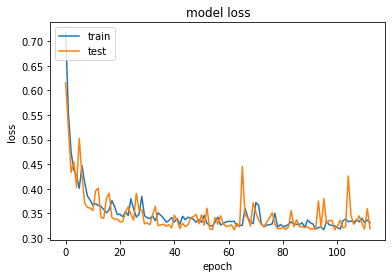

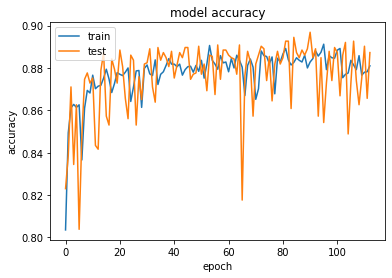

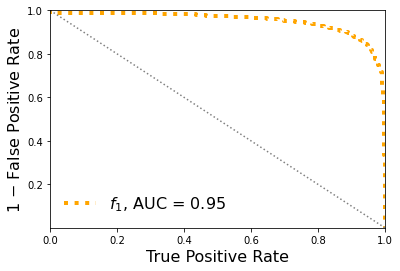

Classification score:


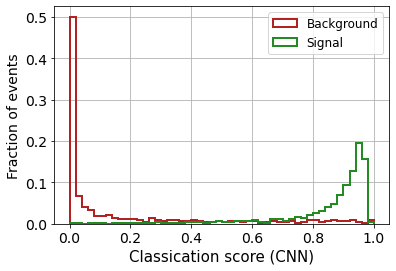


 ROC-AUC =  0.952363778244256


In [65]:

# define the keras model
model = Sequential()
model.add(Conv1D(32, 3, input_shape=(X_mon_train.shape[1],1), strides = (1),kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Conv1D(32, 3, kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Conv1D(32, 3, kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.LeakyReLU(alpha=0.05))  
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train_cn,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_cn, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test_cn)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

In [66]:
print('\n ROC-AUC = ', roc_auc_cnn)


 ROC-AUC =  0.952363778244256


## 2. only time diff

In [67]:
# concatenate the data

# all the background features
X_mon_B = np.reshape(B_pdiffT,(len(B_pdiffT),1))

# all the signal features
X_mon_S = np.reshape(S_pdiffT,(len(S_pdiffT),1))

print('X_mon_B.shape: ', X_mon_B.shape)
print('X_mon_S.shape: ', X_mon_S.shape)
print('')



X_mon5 = np.concatenate([X_mon_B, X_mon_S])

print('X_mon5.shape: ', X_mon5.shape)



# labels
y_mon5 = np.concatenate([np.zeros(num_data),np.ones(num_data)])




# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.25


X_mon5_aux, X_mon5_test, y_mon5_aux, y_mon5_test = train_test_split(X_mon5,
                                                                y_mon5,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon5,
                                                                shuffle=True)



X_mon5_train, X_mon5_val, y_mon5_train, y_mon5_val = train_test_split(X_mon5_aux,
                                                                  y_mon5_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon5_aux,
                                                                  shuffle=True)



print('')
print('X_mon5_train : ', X_mon5_train.shape)
print('y_mon5_train : ', y_mon5_train.shape)
print('X_mon5_val : ', X_mon5_val.shape)
print('y_mon5_val : ', y_mon5_val.shape)
print('X_mon5_test : ', X_mon5_test.shape)
print('y_mon5_test : ', y_mon5_test.shape)
print('')

X_mon_B.shape:  (5000, 1)
X_mon_S.shape:  (5000, 1)

X_mon5.shape:  (10000, 1)

X_mon5_train :  (4999, 1)
y_mon5_train :  (4999,)
X_mon5_val :  (1667, 1)
y_mon5_val :  (1667,)
X_mon5_test :  (3334, 1)
y_mon5_test :  (3334,)



In [68]:
X_mon_train = np.concatenate([X_mon1_train,X_mon2_train,X_mon3_train,X_mon4_train,X_mon5_train],axis=1)
X_mon_test = np.concatenate([X_mon1_test,X_mon2_test,X_mon3_test,X_mon4_test,X_mon5_test],axis=1)
X_mon_val = np.concatenate([X_mon1_val,X_mon2_val,X_mon3_val,X_mon4_val,X_mon5_val],axis=1)



y_mon_train = y_mon1_train
y_mon_test = y_mon1_test
y_mon_val = y_mon1_val



print('')
print('X_mon_train : ', X_mon_train.shape)
print('y_mon_train : ', y_mon_train.shape)
print('X_mon_val : ', X_mon_val.shape)
print('y_mon_val : ', y_mon_val.shape)
print('X_mon_test : ', X_mon_test.shape)
print('y_mon_test : ', y_mon_test.shape)
print('')


X_mon_train :  (4999, 2725)
y_mon_train :  (4999,)
X_mon_val :  (1667, 2725)
y_mon_val :  (1667,)
X_mon_test :  (3334, 2725)
y_mon_test :  (3334,)



### CLASSIFIER

### XGBoost

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-logloss:0.68738	validation_1-logloss:0.68824
[1]	validation_0-logloss:0.68175	validation_1-logloss:0.68344
[2]	validation_0-logloss:0.67623	validation_1-logloss:0.67870
[3]	validation_0-logloss:0.67082	validation_1-logloss:0.67410
[4]	validation_0-logloss:0.66548	validation_1-logloss:0.66966
[5]	validation_0-logloss:0.66023	validation_1-logloss:0.66517
[6]	validation_0-logloss:0.65509	validation_1-logloss:0.66090
[7]	validation_0-logloss:0.65001	validation_1-logloss:0.65648
[8]	validation_0-logloss:0.64496	validation_1-logloss:0.65214
[9]	validation_0-logloss:0.64010	validation_1-logloss:0.64801
[10]	validation_0-logloss:0.63522	validation_1-logloss:0.64389
[11]	validation_0-logloss:0.63054	validation_1-logloss:0.63999
[12]	validation_0-logloss:0.62581	validation_1-logloss:0.63605
[13]	validation_0-logloss:0.62124	validation_1-logloss:0.63231
[14]	validation_0-logloss:0.61664	validation_1-logloss:0.62833
[15]	validation_0-logloss:0.61224	validation_1-logloss:0.62468
[1

[130]	validation_0-logloss:0.33222	validation_1-logloss:0.40777
[131]	validation_0-logloss:0.33094	validation_1-logloss:0.40677
[132]	validation_0-logloss:0.32957	validation_1-logloss:0.40590
[133]	validation_0-logloss:0.32823	validation_1-logloss:0.40497
[134]	validation_0-logloss:0.32682	validation_1-logloss:0.40399
[135]	validation_0-logloss:0.32555	validation_1-logloss:0.40321
[136]	validation_0-logloss:0.32420	validation_1-logloss:0.40226
[137]	validation_0-logloss:0.32291	validation_1-logloss:0.40147
[138]	validation_0-logloss:0.32153	validation_1-logloss:0.40048
[139]	validation_0-logloss:0.32016	validation_1-logloss:0.39965
[140]	validation_0-logloss:0.31889	validation_1-logloss:0.39884
[141]	validation_0-logloss:0.31765	validation_1-logloss:0.39808
[142]	validation_0-logloss:0.31631	validation_1-logloss:0.39719
[143]	validation_0-logloss:0.31507	validation_1-logloss:0.39636
[144]	validation_0-logloss:0.31382	validation_1-logloss:0.39536
[145]	validation_0-logloss:0.31252	valid

[259]	validation_0-logloss:0.20842	validation_1-logloss:0.32725
[260]	validation_0-logloss:0.20774	validation_1-logloss:0.32688
[261]	validation_0-logloss:0.20702	validation_1-logloss:0.32642
[262]	validation_0-logloss:0.20633	validation_1-logloss:0.32605
[263]	validation_0-logloss:0.20566	validation_1-logloss:0.32573
[264]	validation_0-logloss:0.20500	validation_1-logloss:0.32534
[265]	validation_0-logloss:0.20431	validation_1-logloss:0.32494
[266]	validation_0-logloss:0.20364	validation_1-logloss:0.32459
[267]	validation_0-logloss:0.20294	validation_1-logloss:0.32419
[268]	validation_0-logloss:0.20227	validation_1-logloss:0.32376
[269]	validation_0-logloss:0.20165	validation_1-logloss:0.32334
[270]	validation_0-logloss:0.20100	validation_1-logloss:0.32306
[271]	validation_0-logloss:0.20036	validation_1-logloss:0.32272
[272]	validation_0-logloss:0.19972	validation_1-logloss:0.32232
[273]	validation_0-logloss:0.19906	validation_1-logloss:0.32195
[274]	validation_0-logloss:0.19837	valid

[388]	validation_0-logloss:0.14408	validation_1-logloss:0.29017
[389]	validation_0-logloss:0.14376	validation_1-logloss:0.28992
[390]	validation_0-logloss:0.14342	validation_1-logloss:0.28972
[391]	validation_0-logloss:0.14306	validation_1-logloss:0.28952
[392]	validation_0-logloss:0.14265	validation_1-logloss:0.28933
[393]	validation_0-logloss:0.14233	validation_1-logloss:0.28919
[394]	validation_0-logloss:0.14201	validation_1-logloss:0.28895
[395]	validation_0-logloss:0.14164	validation_1-logloss:0.28877
[396]	validation_0-logloss:0.14126	validation_1-logloss:0.28859
[397]	validation_0-logloss:0.14095	validation_1-logloss:0.28835
[398]	validation_0-logloss:0.14055	validation_1-logloss:0.28809
[399]	validation_0-logloss:0.14017	validation_1-logloss:0.28786
[400]	validation_0-logloss:0.13979	validation_1-logloss:0.28762
[401]	validation_0-logloss:0.13948	validation_1-logloss:0.28750
[402]	validation_0-logloss:0.13916	validation_1-logloss:0.28735
[403]	validation_0-logloss:0.13883	valid

[517]	validation_0-logloss:0.10613	validation_1-logloss:0.26941
[518]	validation_0-logloss:0.10585	validation_1-logloss:0.26926
[519]	validation_0-logloss:0.10564	validation_1-logloss:0.26919
[520]	validation_0-logloss:0.10545	validation_1-logloss:0.26902
[521]	validation_0-logloss:0.10529	validation_1-logloss:0.26891
[522]	validation_0-logloss:0.10510	validation_1-logloss:0.26882
[523]	validation_0-logloss:0.10490	validation_1-logloss:0.26880
[524]	validation_0-logloss:0.10463	validation_1-logloss:0.26865
[525]	validation_0-logloss:0.10434	validation_1-logloss:0.26851
[526]	validation_0-logloss:0.10410	validation_1-logloss:0.26835
[527]	validation_0-logloss:0.10391	validation_1-logloss:0.26823
[528]	validation_0-logloss:0.10366	validation_1-logloss:0.26820
[529]	validation_0-logloss:0.10348	validation_1-logloss:0.26806
[530]	validation_0-logloss:0.10320	validation_1-logloss:0.26792
[531]	validation_0-logloss:0.10299	validation_1-logloss:0.26779
[532]	validation_0-logloss:0.10283	valid

[646]	validation_0-logloss:0.08030	validation_1-logloss:0.25578
[647]	validation_0-logloss:0.08008	validation_1-logloss:0.25566
[648]	validation_0-logloss:0.07993	validation_1-logloss:0.25559
[649]	validation_0-logloss:0.07984	validation_1-logloss:0.25551
[650]	validation_0-logloss:0.07967	validation_1-logloss:0.25542
[651]	validation_0-logloss:0.07949	validation_1-logloss:0.25534
[652]	validation_0-logloss:0.07931	validation_1-logloss:0.25521
[653]	validation_0-logloss:0.07914	validation_1-logloss:0.25514
[654]	validation_0-logloss:0.07898	validation_1-logloss:0.25507
[655]	validation_0-logloss:0.07881	validation_1-logloss:0.25504
[656]	validation_0-logloss:0.07866	validation_1-logloss:0.25502
[657]	validation_0-logloss:0.07855	validation_1-logloss:0.25498
[658]	validation_0-logloss:0.07835	validation_1-logloss:0.25485
[659]	validation_0-logloss:0.07816	validation_1-logloss:0.25476
[660]	validation_0-logloss:0.07801	validation_1-logloss:0.25481
[661]	validation_0-logloss:0.07781	valid

[775]	validation_0-logloss:0.06270	validation_1-logloss:0.24883
[776]	validation_0-logloss:0.06259	validation_1-logloss:0.24880
[777]	validation_0-logloss:0.06247	validation_1-logloss:0.24879
[778]	validation_0-logloss:0.06237	validation_1-logloss:0.24871
[779]	validation_0-logloss:0.06224	validation_1-logloss:0.24864
[780]	validation_0-logloss:0.06211	validation_1-logloss:0.24858
[781]	validation_0-logloss:0.06200	validation_1-logloss:0.24863
[782]	validation_0-logloss:0.06184	validation_1-logloss:0.24856
[783]	validation_0-logloss:0.06171	validation_1-logloss:0.24848
[784]	validation_0-logloss:0.06158	validation_1-logloss:0.24846
[785]	validation_0-logloss:0.06145	validation_1-logloss:0.24843
[786]	validation_0-logloss:0.06135	validation_1-logloss:0.24833
[787]	validation_0-logloss:0.06128	validation_1-logloss:0.24827
[788]	validation_0-logloss:0.06116	validation_1-logloss:0.24826
[789]	validation_0-logloss:0.06106	validation_1-logloss:0.24823
[790]	validation_0-logloss:0.06094	valid

[904]	validation_0-logloss:0.05004	validation_1-logloss:0.24309
[905]	validation_0-logloss:0.04996	validation_1-logloss:0.24306
[906]	validation_0-logloss:0.04987	validation_1-logloss:0.24302
[907]	validation_0-logloss:0.04981	validation_1-logloss:0.24301
[908]	validation_0-logloss:0.04974	validation_1-logloss:0.24296
[909]	validation_0-logloss:0.04968	validation_1-logloss:0.24291
[910]	validation_0-logloss:0.04957	validation_1-logloss:0.24289
[911]	validation_0-logloss:0.04950	validation_1-logloss:0.24290
[912]	validation_0-logloss:0.04942	validation_1-logloss:0.24286
[913]	validation_0-logloss:0.04936	validation_1-logloss:0.24280
[914]	validation_0-logloss:0.04929	validation_1-logloss:0.24278
[915]	validation_0-logloss:0.04922	validation_1-logloss:0.24274
[916]	validation_0-logloss:0.04915	validation_1-logloss:0.24266
[917]	validation_0-logloss:0.04904	validation_1-logloss:0.24265
[918]	validation_0-logloss:0.04897	validation_1-logloss:0.24262
[919]	validation_0-logloss:0.04891	valid

[1032]	validation_0-logloss:0.04129	validation_1-logloss:0.23980
[1033]	validation_0-logloss:0.04121	validation_1-logloss:0.23977
[1034]	validation_0-logloss:0.04114	validation_1-logloss:0.23979
[1035]	validation_0-logloss:0.04106	validation_1-logloss:0.23978
[1036]	validation_0-logloss:0.04100	validation_1-logloss:0.23974
[1037]	validation_0-logloss:0.04092	validation_1-logloss:0.23970
[1038]	validation_0-logloss:0.04088	validation_1-logloss:0.23967
[1039]	validation_0-logloss:0.04080	validation_1-logloss:0.23969
[1040]	validation_0-logloss:0.04071	validation_1-logloss:0.23966
[1041]	validation_0-logloss:0.04066	validation_1-logloss:0.23961
[1042]	validation_0-logloss:0.04060	validation_1-logloss:0.23957
[1043]	validation_0-logloss:0.04057	validation_1-logloss:0.23952
[1044]	validation_0-logloss:0.04049	validation_1-logloss:0.23949
[1045]	validation_0-logloss:0.04044	validation_1-logloss:0.23944
[1046]	validation_0-logloss:0.04036	validation_1-logloss:0.23941
[1047]	validation_0-loglo

[1159]	validation_0-logloss:0.03421	validation_1-logloss:0.23731
[1160]	validation_0-logloss:0.03417	validation_1-logloss:0.23730
[1161]	validation_0-logloss:0.03411	validation_1-logloss:0.23727
[1162]	validation_0-logloss:0.03407	validation_1-logloss:0.23723
[1163]	validation_0-logloss:0.03401	validation_1-logloss:0.23722
[1164]	validation_0-logloss:0.03396	validation_1-logloss:0.23721
[1165]	validation_0-logloss:0.03391	validation_1-logloss:0.23722
[1166]	validation_0-logloss:0.03387	validation_1-logloss:0.23725
[1167]	validation_0-logloss:0.03382	validation_1-logloss:0.23728
[1168]	validation_0-logloss:0.03378	validation_1-logloss:0.23722
[1169]	validation_0-logloss:0.03374	validation_1-logloss:0.23717
[1170]	validation_0-logloss:0.03368	validation_1-logloss:0.23706
[1171]	validation_0-logloss:0.03364	validation_1-logloss:0.23705
[1172]	validation_0-logloss:0.03358	validation_1-logloss:0.23703
[1173]	validation_0-logloss:0.03353	validation_1-logloss:0.23699
[1174]	validation_0-loglo

[1286]	validation_0-logloss:0.02900	validation_1-logloss:0.23552
[1287]	validation_0-logloss:0.02896	validation_1-logloss:0.23549
[1288]	validation_0-logloss:0.02890	validation_1-logloss:0.23551
[1289]	validation_0-logloss:0.02886	validation_1-logloss:0.23551
[1290]	validation_0-logloss:0.02882	validation_1-logloss:0.23551
[1291]	validation_0-logloss:0.02878	validation_1-logloss:0.23550
[1292]	validation_0-logloss:0.02876	validation_1-logloss:0.23549
[1293]	validation_0-logloss:0.02871	validation_1-logloss:0.23547
[1294]	validation_0-logloss:0.02868	validation_1-logloss:0.23547
[1295]	validation_0-logloss:0.02865	validation_1-logloss:0.23548
[1296]	validation_0-logloss:0.02861	validation_1-logloss:0.23549
[1297]	validation_0-logloss:0.02859	validation_1-logloss:0.23550
[1298]	validation_0-logloss:0.02855	validation_1-logloss:0.23550
[1299]	validation_0-logloss:0.02852	validation_1-logloss:0.23552
[1300]	validation_0-logloss:0.02849	validation_1-logloss:0.23552
[1301]	validation_0-loglo

[1413]	validation_0-logloss:0.02448	validation_1-logloss:0.23517
[1414]	validation_0-logloss:0.02445	validation_1-logloss:0.23517
[1415]	validation_0-logloss:0.02442	validation_1-logloss:0.23512
[1416]	validation_0-logloss:0.02440	validation_1-logloss:0.23511
[1417]	validation_0-logloss:0.02437	validation_1-logloss:0.23512
[1418]	validation_0-logloss:0.02434	validation_1-logloss:0.23508
[1419]	validation_0-logloss:0.02430	validation_1-logloss:0.23510
[1420]	validation_0-logloss:0.02427	validation_1-logloss:0.23511
[1421]	validation_0-logloss:0.02425	validation_1-logloss:0.23512
[1422]	validation_0-logloss:0.02422	validation_1-logloss:0.23513
[1423]	validation_0-logloss:0.02418	validation_1-logloss:0.23511
[1424]	validation_0-logloss:0.02414	validation_1-logloss:0.23508
[1425]	validation_0-logloss:0.02411	validation_1-logloss:0.23515
[1426]	validation_0-logloss:0.02408	validation_1-logloss:0.23511
[1427]	validation_0-logloss:0.02405	validation_1-logloss:0.23511
[1428]	validation_0-loglo

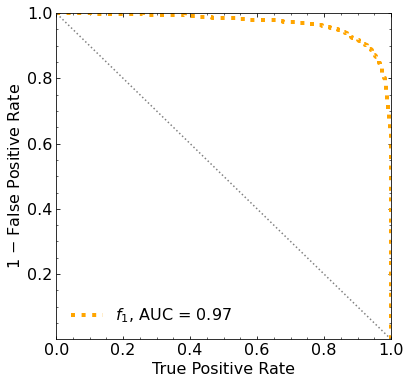

Classification score:


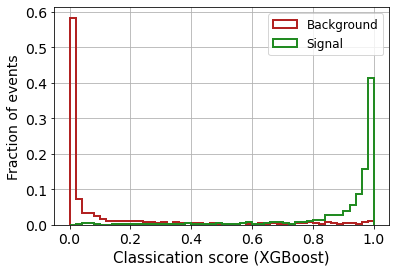


 ROC-AUC =  0.969241583953145


In [69]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators=2500,
    learning_rate=0.01,
    reg_lambda=0.01,reg_alpha=0.0,
    gamma=0.0,objective='binary:logistic',
    max_depth=5,
    #eval_metric=["error", "logloss", "map"]
    eval_metric='logloss')

# FIT
classifier.fit(X_mon_train,y_mon_train,eval_set=[(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
        early_stopping_rounds=50,#early stopping
        verbose=True)


# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_mon_test).T[1]


# ROC
fpr_mon_xg, tpr_mon_xg, _ = roc_curve(y_mon_test, y_pred_xg)
roc_auc_xg = auc(fpr_mon_xg, tpr_mon_xg)


# PLOT THE ROC WITH AUC
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax0.minorticks_on()


plt.plot(tpr_mon_xg,1-fpr_mon_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()



# XGBoost with the kinematic variables of the leptons

########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()




print('\n ROC-AUC = ', roc_auc_xg)

In [70]:
print('\n ROC-AUC = ', roc_auc_xg)


 ROC-AUC =  0.969241583953145


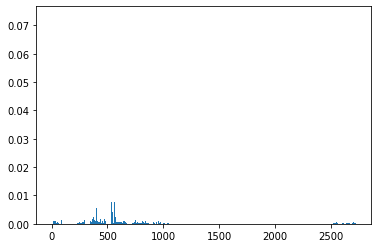

In [71]:
plt.bar(range(len(classifier.feature_importances_)), classifier.feature_importances_)
plt.show()

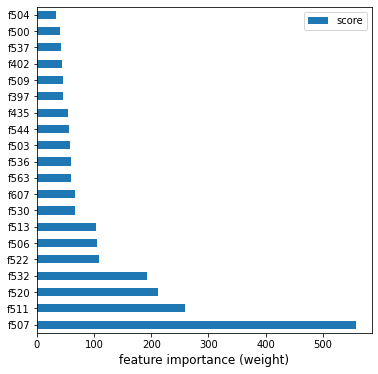


f2725: pdiffT


In [72]:
feature_important = classifier.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
#keys = ['pA_S1','pH_S1','pHT_S1','pL_S1','pL90_S1','pRMSW_S1','pHTL_S1','pA_S2','pH_S2','pHT_S2','pL_S2','pL90_S2','pRMSW_S2','pHTL_S2','pbot', 'ptop','pdiffT']
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(20, columns="score").plot(kind='barh', figsize = (6,6)) ## plot top 10 features
plt.xlabel('feature importance (weight)', fontsize = 12)
plt.show()



print('\nf'+ str(len(classifier.feature_importances_)) + ': pdiffT')

### DNN

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_70 (Dense)             (None, 256)               697856    
_________________________________________________________________
leaky_re_lu_75 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dropout_63 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_71 (Dense)             (None, 128)               32896     
_________________________________________________________________
leaky_re_lu_76 (LeakyReLU)   (None, 128)               0         
_________________________________________________________________
dropout_64 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_72 (Dense)             (None, 64)              

Epoch 36/500
40/40 [==============================] - 0s 4ms/step - loss: 0.2453 - accuracy: 0.9150 - val_loss: 0.2360 - val_accuracy: 0.9154
Epoch 37/500
40/40 [==============================] - 0s 3ms/step - loss: 0.2328 - accuracy: 0.9172 - val_loss: 0.2361 - val_accuracy: 0.8902
Epoch 38/500
40/40 [==============================] - 0s 3ms/step - loss: 0.2740 - accuracy: 0.8939 - val_loss: 0.2376 - val_accuracy: 0.9082
Epoch 39/500
40/40 [==============================] - 0s 3ms/step - loss: 0.2289 - accuracy: 0.9153 - val_loss: 0.2336 - val_accuracy: 0.9106
Epoch 40/500
40/40 [==============================] - 0s 4ms/step - loss: 0.2220 - accuracy: 0.9242 - val_loss: 0.3134 - val_accuracy: 0.8848
Epoch 41/500
40/40 [==============================] - 0s 4ms/step - loss: 0.2429 - accuracy: 0.9114 - val_loss: 0.2307 - val_accuracy: 0.9070
Epoch 42/500
40/40 [==============================] - 0s 4ms/step - loss: 0.2041 - accuracy: 0.9296 - val_loss: 0.2812 - val_accuracy: 0.9022
Epoch 

Epoch 94/500
40/40 [==============================] - 0s 4ms/step - loss: 0.2032 - accuracy: 0.9219 - val_loss: 0.2647 - val_accuracy: 0.9136
Epoch 95/500
40/40 [==============================] - 0s 4ms/step - loss: 0.1633 - accuracy: 0.9362 - val_loss: 0.2623 - val_accuracy: 0.8962
Epoch 96/500
40/40 [==============================] - 0s 4ms/step - loss: 0.2709 - accuracy: 0.8937 - val_loss: 0.2173 - val_accuracy: 0.9160
Epoch 97/500
40/40 [==============================] - 0s 4ms/step - loss: 0.1705 - accuracy: 0.9392 - val_loss: 0.2218 - val_accuracy: 0.9148
Epoch 98/500
40/40 [==============================] - 0s 4ms/step - loss: 0.1857 - accuracy: 0.9296 - val_loss: 0.2091 - val_accuracy: 0.9184
Epoch 99/500
40/40 [==============================] - 0s 4ms/step - loss: 0.1540 - accuracy: 0.9464 - val_loss: 0.2114 - val_accuracy: 0.9232
Restoring model weights from the end of the best epoch.
Epoch 00099: early stopping


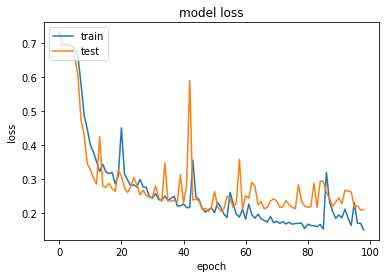

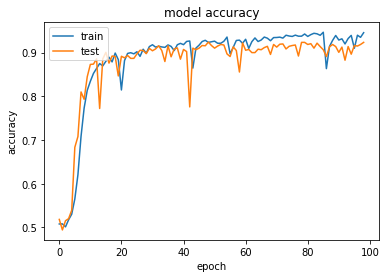

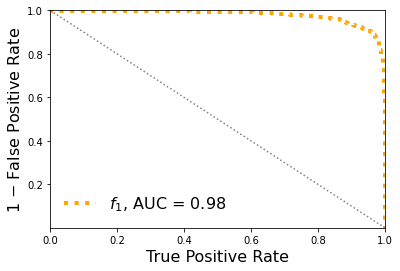

Classification score:


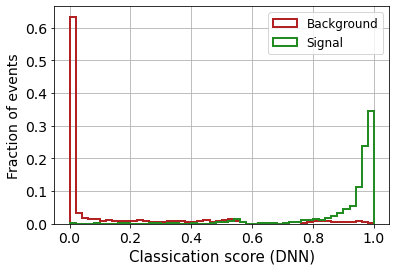


 ROC-AUC =  0.9782990385362945


In [73]:

# define the keras model
model = Sequential()
model.add(Dense(256, input_shape=(X_mon_train.shape[1],)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(128))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(64))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(32))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(16))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(8))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(4))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_dnn = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_dnn = dict()
tpr_dnn = dict()
roc_auc_dnn = dict()
fpr_dnn, tpr_dnn, _ = roc_curve(y_mon_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)


plt.figure()
plt.plot(tpr_dnn,1-fpr_dnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_dnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_dnn[i,0])
    else:
        pred_XG_NP.append(y_pred_dnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (DNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_dnn)

In [74]:
print('\n ROC-AUC = ', roc_auc_dnn)


 ROC-AUC =  0.9782990385362945


### CNN

In [75]:
# prepare the dataset
X_mon_train_cn = X_mon_train.reshape(X_mon_train.shape[0], X_mon_train.shape[1], 1)
X_mon_test_cn = X_mon_test.reshape(X_mon_test.shape[0], X_mon_test.shape[1], 1)
X_mon_val_cn = X_mon_val.reshape(X_mon_val.shape[0], X_mon_val.shape[1], 1)

Epoch 1/500
40/40 [==============================] - 6s 117ms/step - loss: 0.7334 - accuracy: 0.7007 - val_loss: 0.5034 - val_accuracy: 0.8464
Epoch 2/500
40/40 [==============================] - 4s 111ms/step - loss: 0.4840 - accuracy: 0.8542 - val_loss: 0.5130 - val_accuracy: 0.8194
Epoch 3/500
40/40 [==============================] - 4s 112ms/step - loss: 0.4617 - accuracy: 0.8504 - val_loss: 0.4095 - val_accuracy: 0.8740
Epoch 4/500
40/40 [==============================] - 4s 112ms/step - loss: 0.3950 - accuracy: 0.8809 - val_loss: 0.4027 - val_accuracy: 0.8698
Epoch 5/500
40/40 [==============================] - 5s 113ms/step - loss: 0.4044 - accuracy: 0.8733 - val_loss: 0.3993 - val_accuracy: 0.8686
Epoch 6/500
40/40 [==============================] - 4s 112ms/step - loss: 0.3788 - accuracy: 0.8810 - val_loss: 0.3366 - val_accuracy: 0.8980
Epoch 7/500
40/40 [==============================] - 5s 113ms/step - loss: 0.3712 - accuracy: 0.8831 - val_loss: 0.3349 - val_accuracy: 0.8926

Epoch 58/500
40/40 [==============================] - 4s 110ms/step - loss: 0.2914 - accuracy: 0.9110 - val_loss: 0.2812 - val_accuracy: 0.9148
Epoch 59/500
40/40 [==============================] - 5s 113ms/step - loss: 0.2817 - accuracy: 0.9118 - val_loss: 0.3042 - val_accuracy: 0.8992
Epoch 60/500
40/40 [==============================] - 4s 112ms/step - loss: 0.3720 - accuracy: 0.8657 - val_loss: 0.2923 - val_accuracy: 0.8998
Epoch 61/500
40/40 [==============================] - 4s 112ms/step - loss: 0.2979 - accuracy: 0.8968 - val_loss: 0.2972 - val_accuracy: 0.9034
Epoch 62/500
40/40 [==============================] - 4s 113ms/step - loss: 0.2895 - accuracy: 0.9084 - val_loss: 0.2791 - val_accuracy: 0.9040
Epoch 63/500
40/40 [==============================] - 4s 112ms/step - loss: 0.2917 - accuracy: 0.9059 - val_loss: 0.2683 - val_accuracy: 0.9184
Epoch 64/500
40/40 [==============================] - 5s 114ms/step - loss: 0.2954 - accuracy: 0.9015 - val_loss: 0.2898 - val_accuracy:

Epoch 115/500
40/40 [==============================] - 4s 109ms/step - loss: 0.2786 - accuracy: 0.9164 - val_loss: 0.2724 - val_accuracy: 0.9172
Epoch 116/500
40/40 [==============================] - 4s 109ms/step - loss: 0.2843 - accuracy: 0.9095 - val_loss: 0.2779 - val_accuracy: 0.9190
Epoch 117/500
40/40 [==============================] - 4s 109ms/step - loss: 0.2907 - accuracy: 0.9035 - val_loss: 0.2802 - val_accuracy: 0.9058
Epoch 118/500
40/40 [==============================] - 4s 109ms/step - loss: 0.2719 - accuracy: 0.9178 - val_loss: 0.3131 - val_accuracy: 0.8890
Epoch 119/500
40/40 [==============================] - 4s 110ms/step - loss: 0.2790 - accuracy: 0.9111 - val_loss: 0.3690 - val_accuracy: 0.8614
Epoch 120/500
40/40 [==============================] - 4s 110ms/step - loss: 0.3143 - accuracy: 0.9007 - val_loss: 0.2816 - val_accuracy: 0.9052
Epoch 121/500
40/40 [==============================] - 4s 110ms/step - loss: 0.2922 - accuracy: 0.9051 - val_loss: 0.2739 - val_ac

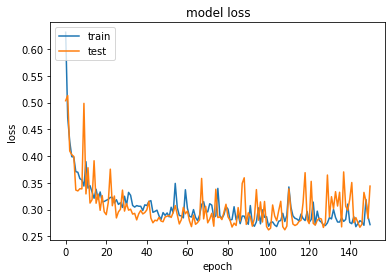

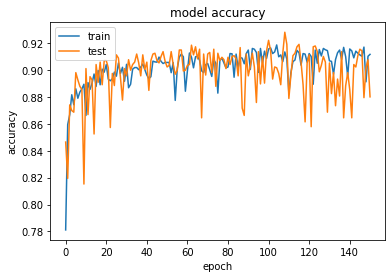

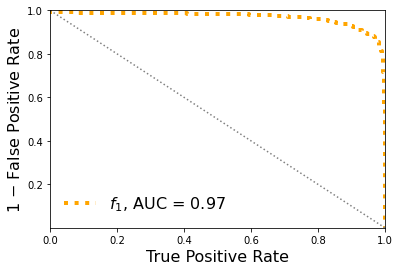

Classification score:


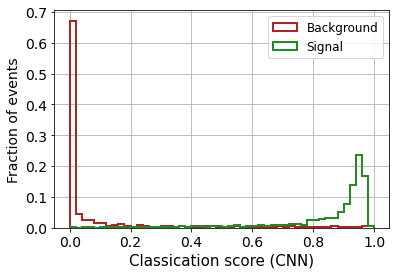


 ROC-AUC =  0.9683924925780991


In [76]:

# define the keras model
model = Sequential()
model.add(Conv1D(16, 3, input_shape=(X_mon_train.shape[1],1), strides = (1),kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Conv1D(16, 3, kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Conv1D(16, 3, kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.LeakyReLU(alpha=0.05))  
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train_cn,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_cn, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test_cn)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

In [77]:
print('\n ROC-AUC = ', roc_auc_cnn)


 ROC-AUC =  0.9683924925780991


## 3. All compressed features

In [78]:
# concatenate the data

# all the background features
X_mon_B = np.concatenate([B_ppeakS1, B_ppeakS2, np.reshape(B_pbot,(len(B_pbot),1)), np.reshape(B_ptop,(len(B_ptop),1)), np.reshape(B_pdiffT,(len(B_pdiffT),1)) ],axis=1)

# all the signal features
X_mon_S = np.concatenate([S_ppeakS1, S_ppeakS2, np.reshape(S_pbot,(len(S_pbot),1)), np.reshape(S_ptop,(len(S_ptop),1)), np.reshape(S_pdiffT,(len(S_pdiffT),1)) ],axis=1)

print('X_mon_B.shape: ', X_mon_B.shape)
print('X_mon_S.shape: ', X_mon_S.shape)
print('')

del B_ppeakS1
del B_ppeakS2
del B_pbot
del B_ptop

del S_ppeakS1
del S_ppeakS2
del S_pbot
del S_ptop


X_mon5 = np.concatenate([X_mon_B, X_mon_S])

print('X_mon5.shape: ', X_mon5.shape)
del X_mon_B
del X_mon_S


# labels
y_mon5 = np.concatenate([np.zeros(num_data),np.ones(num_data)])




# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.25


X_mon5_aux, X_mon5_test, y_mon5_aux, y_mon5_test = train_test_split(X_mon5,
                                                                y_mon5,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_mon5,
                                                                shuffle=True)

del X_mon5
del y_mon5

X_mon5_train, X_mon5_val, y_mon5_train, y_mon5_val = train_test_split(X_mon5_aux,
                                                                  y_mon5_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_mon5_aux,
                                                                  shuffle=True)

del X_mon5_aux
del y_mon5_aux

print('')
print('X_mon5_train : ', X_mon5_train.shape)
print('y_mon5_train : ', y_mon5_train.shape)
print('X_mon5_val : ', X_mon5_val.shape)
print('y_mon5_val : ', y_mon5_val.shape)
print('X_mon5_test : ', X_mon5_test.shape)
print('y_mon5_test : ', y_mon5_test.shape)
print('')

X_mon_B.shape:  (5000, 17)
X_mon_S.shape:  (5000, 17)

X_mon5.shape:  (10000, 17)

X_mon5_train :  (4999, 17)
y_mon5_train :  (4999,)
X_mon5_val :  (1667, 17)
y_mon5_val :  (1667,)
X_mon5_test :  (3334, 17)
y_mon5_test :  (3334,)



##### Concatenate into one single big dataset

In [79]:
X_mon_train = np.concatenate([X_mon1_train,X_mon2_train,X_mon3_train,X_mon4_train,X_mon5_train],axis=1)
X_mon_test = np.concatenate([X_mon1_test,X_mon2_test,X_mon3_test,X_mon4_test,X_mon5_test],axis=1)
X_mon_val = np.concatenate([X_mon1_val,X_mon2_val,X_mon3_val,X_mon4_val,X_mon5_val],axis=1)

del X_mon1_train
del X_mon2_train
del X_mon3_train
del X_mon4_train
del X_mon5_train

del X_mon1_test
del X_mon2_test
del X_mon3_test
del X_mon4_test
del X_mon5_test

del X_mon1_val
del X_mon2_val
del X_mon3_val
del X_mon4_val
del X_mon5_val



y_mon_train = y_mon1_train
y_mon_test = y_mon1_test
y_mon_val = y_mon1_val

del y_mon1_train
del y_mon2_train
del y_mon3_train
del y_mon4_train
del y_mon5_train

del y_mon1_test
del y_mon2_test
del y_mon3_test
del y_mon4_test
del y_mon5_test

del y_mon1_val
del y_mon2_val
del y_mon3_val
del y_mon4_val
del y_mon5_val


In [80]:
print('')
print('X_mon_train : ', X_mon_train.shape)
print('y_mon_train : ', y_mon_train.shape)
print('X_mon_val : ', X_mon_val.shape)
print('y_mon_val : ', y_mon_val.shape)
print('X_mon_test : ', X_mon_test.shape)
print('y_mon_test : ', y_mon_test.shape)
print('')


X_mon_train :  (4999, 2741)
y_mon_train :  (4999,)
X_mon_val :  (1667, 2741)
y_mon_val :  (1667,)
X_mon_test :  (3334, 2741)
y_mon_test :  (3334,)



### CLASSIFIER

### XGBoost

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-logloss:0.68637	validation_1-logloss:0.68703
[1]	validation_0-logloss:0.67967	validation_1-logloss:0.68102
[2]	validation_0-logloss:0.67316	validation_1-logloss:0.67515
[3]	validation_0-logloss:0.66673	validation_1-logloss:0.66944
[4]	validation_0-logloss:0.66043	validation_1-logloss:0.66384
[5]	validation_0-logloss:0.65427	validation_1-logloss:0.65833
[6]	validation_0-logloss:0.64822	validation_1-logloss:0.65290
[7]	validation_0-logloss:0.64222	validation_1-logloss:0.64749
[8]	validation_0-logloss:0.63635	validation_1-logloss:0.64226
[9]	validation_0-logloss:0.63062	validation_1-logloss:0.63716
[10]	validation_0-logloss:0.62495	validation_1-logloss:0.63206
[11]	validation_0-logloss:0.61939	validation_1-logloss:0.62713
[12]	validation_0-logloss:0.61383	validation_1-logloss:0.62211
[13]	validation_0-logloss:0.60847	validation_1-logloss:0.61743
[14]	validation_0-logloss:0.60312	validation_1-logloss:0.61258
[15]	validation_0-logloss:0.59794	validation_1-logloss:0.60799
[1

[130]	validation_0-logloss:0.28569	validation_1-logloss:0.34041
[131]	validation_0-logloss:0.28435	validation_1-logloss:0.33927
[132]	validation_0-logloss:0.28301	validation_1-logloss:0.33823
[133]	validation_0-logloss:0.28167	validation_1-logloss:0.33721
[134]	validation_0-logloss:0.28036	validation_1-logloss:0.33613
[135]	validation_0-logloss:0.27907	validation_1-logloss:0.33507
[136]	validation_0-logloss:0.27776	validation_1-logloss:0.33409
[137]	validation_0-logloss:0.27650	validation_1-logloss:0.33304
[138]	validation_0-logloss:0.27523	validation_1-logloss:0.33214
[139]	validation_0-logloss:0.27400	validation_1-logloss:0.33118
[140]	validation_0-logloss:0.27279	validation_1-logloss:0.33020
[141]	validation_0-logloss:0.27156	validation_1-logloss:0.32930
[142]	validation_0-logloss:0.27029	validation_1-logloss:0.32826
[143]	validation_0-logloss:0.26897	validation_1-logloss:0.32722
[144]	validation_0-logloss:0.26774	validation_1-logloss:0.32632
[145]	validation_0-logloss:0.26660	valid

[259]	validation_0-logloss:0.17300	validation_1-logloss:0.25872
[260]	validation_0-logloss:0.17256	validation_1-logloss:0.25848
[261]	validation_0-logloss:0.17202	validation_1-logloss:0.25814
[262]	validation_0-logloss:0.17141	validation_1-logloss:0.25782
[263]	validation_0-logloss:0.17101	validation_1-logloss:0.25765
[264]	validation_0-logloss:0.17045	validation_1-logloss:0.25729
[265]	validation_0-logloss:0.16990	validation_1-logloss:0.25695
[266]	validation_0-logloss:0.16935	validation_1-logloss:0.25672
[267]	validation_0-logloss:0.16885	validation_1-logloss:0.25630
[268]	validation_0-logloss:0.16825	validation_1-logloss:0.25597
[269]	validation_0-logloss:0.16783	validation_1-logloss:0.25577
[270]	validation_0-logloss:0.16732	validation_1-logloss:0.25545
[271]	validation_0-logloss:0.16674	validation_1-logloss:0.25515
[272]	validation_0-logloss:0.16625	validation_1-logloss:0.25487
[273]	validation_0-logloss:0.16572	validation_1-logloss:0.25456
[274]	validation_0-logloss:0.16519	valid

[388]	validation_0-logloss:0.12240	validation_1-logloss:0.23369
[389]	validation_0-logloss:0.12209	validation_1-logloss:0.23358
[390]	validation_0-logloss:0.12187	validation_1-logloss:0.23349
[391]	validation_0-logloss:0.12154	validation_1-logloss:0.23337
[392]	validation_0-logloss:0.12125	validation_1-logloss:0.23336
[393]	validation_0-logloss:0.12094	validation_1-logloss:0.23329
[394]	validation_0-logloss:0.12071	validation_1-logloss:0.23315
[395]	validation_0-logloss:0.12049	validation_1-logloss:0.23304
[396]	validation_0-logloss:0.12018	validation_1-logloss:0.23290
[397]	validation_0-logloss:0.11986	validation_1-logloss:0.23279
[398]	validation_0-logloss:0.11956	validation_1-logloss:0.23270
[399]	validation_0-logloss:0.11934	validation_1-logloss:0.23256
[400]	validation_0-logloss:0.11898	validation_1-logloss:0.23244
[401]	validation_0-logloss:0.11877	validation_1-logloss:0.23231
[402]	validation_0-logloss:0.11847	validation_1-logloss:0.23225
[403]	validation_0-logloss:0.11825	valid

[517]	validation_0-logloss:0.09297	validation_1-logloss:0.22400
[518]	validation_0-logloss:0.09277	validation_1-logloss:0.22395
[519]	validation_0-logloss:0.09255	validation_1-logloss:0.22396
[520]	validation_0-logloss:0.09235	validation_1-logloss:0.22390
[521]	validation_0-logloss:0.09220	validation_1-logloss:0.22384
[522]	validation_0-logloss:0.09201	validation_1-logloss:0.22383
[523]	validation_0-logloss:0.09178	validation_1-logloss:0.22375
[524]	validation_0-logloss:0.09164	validation_1-logloss:0.22369
[525]	validation_0-logloss:0.09143	validation_1-logloss:0.22358
[526]	validation_0-logloss:0.09128	validation_1-logloss:0.22352
[527]	validation_0-logloss:0.09107	validation_1-logloss:0.22347
[528]	validation_0-logloss:0.09090	validation_1-logloss:0.22343
[529]	validation_0-logloss:0.09076	validation_1-logloss:0.22341
[530]	validation_0-logloss:0.09054	validation_1-logloss:0.22342
[531]	validation_0-logloss:0.09040	validation_1-logloss:0.22338
[532]	validation_0-logloss:0.09025	valid

[646]	validation_0-logloss:0.07239	validation_1-logloss:0.21897
[647]	validation_0-logloss:0.07228	validation_1-logloss:0.21890
[648]	validation_0-logloss:0.07211	validation_1-logloss:0.21889
[649]	validation_0-logloss:0.07199	validation_1-logloss:0.21884
[650]	validation_0-logloss:0.07185	validation_1-logloss:0.21885
[651]	validation_0-logloss:0.07169	validation_1-logloss:0.21876
[652]	validation_0-logloss:0.07161	validation_1-logloss:0.21871
[653]	validation_0-logloss:0.07151	validation_1-logloss:0.21873
[654]	validation_0-logloss:0.07141	validation_1-logloss:0.21867
[655]	validation_0-logloss:0.07129	validation_1-logloss:0.21863
[656]	validation_0-logloss:0.07119	validation_1-logloss:0.21861
[657]	validation_0-logloss:0.07104	validation_1-logloss:0.21857
[658]	validation_0-logloss:0.07096	validation_1-logloss:0.21855
[659]	validation_0-logloss:0.07079	validation_1-logloss:0.21852
[660]	validation_0-logloss:0.07065	validation_1-logloss:0.21845
[661]	validation_0-logloss:0.07055	valid

[775]	validation_0-logloss:0.05851	validation_1-logloss:0.21648
[776]	validation_0-logloss:0.05841	validation_1-logloss:0.21649
[777]	validation_0-logloss:0.05829	validation_1-logloss:0.21645
[778]	validation_0-logloss:0.05821	validation_1-logloss:0.21643
[779]	validation_0-logloss:0.05813	validation_1-logloss:0.21643
[780]	validation_0-logloss:0.05798	validation_1-logloss:0.21638
[781]	validation_0-logloss:0.05793	validation_1-logloss:0.21638
[782]	validation_0-logloss:0.05786	validation_1-logloss:0.21630
[783]	validation_0-logloss:0.05779	validation_1-logloss:0.21634
[784]	validation_0-logloss:0.05771	validation_1-logloss:0.21636
[785]	validation_0-logloss:0.05761	validation_1-logloss:0.21633
[786]	validation_0-logloss:0.05753	validation_1-logloss:0.21628
[787]	validation_0-logloss:0.05740	validation_1-logloss:0.21627
[788]	validation_0-logloss:0.05727	validation_1-logloss:0.21625
[789]	validation_0-logloss:0.05720	validation_1-logloss:0.21621
[790]	validation_0-logloss:0.05710	valid

[904]	validation_0-logloss:0.04865	validation_1-logloss:0.21521
[905]	validation_0-logloss:0.04860	validation_1-logloss:0.21524
[906]	validation_0-logloss:0.04852	validation_1-logloss:0.21521
[907]	validation_0-logloss:0.04846	validation_1-logloss:0.21521
[908]	validation_0-logloss:0.04835	validation_1-logloss:0.21524
[909]	validation_0-logloss:0.04831	validation_1-logloss:0.21524
[910]	validation_0-logloss:0.04823	validation_1-logloss:0.21528
[911]	validation_0-logloss:0.04816	validation_1-logloss:0.21530
[912]	validation_0-logloss:0.04809	validation_1-logloss:0.21526
[913]	validation_0-logloss:0.04805	validation_1-logloss:0.21527
[914]	validation_0-logloss:0.04797	validation_1-logloss:0.21527
[915]	validation_0-logloss:0.04786	validation_1-logloss:0.21526
[916]	validation_0-logloss:0.04780	validation_1-logloss:0.21523
[917]	validation_0-logloss:0.04773	validation_1-logloss:0.21519
[918]	validation_0-logloss:0.04766	validation_1-logloss:0.21521
[919]	validation_0-logloss:0.04760	valid

[1032]	validation_0-logloss:0.04065	validation_1-logloss:0.21502
[1033]	validation_0-logloss:0.04061	validation_1-logloss:0.21502
[1034]	validation_0-logloss:0.04057	validation_1-logloss:0.21503
[1035]	validation_0-logloss:0.04053	validation_1-logloss:0.21504
[1036]	validation_0-logloss:0.04049	validation_1-logloss:0.21503
[1037]	validation_0-logloss:0.04043	validation_1-logloss:0.21504
[1038]	validation_0-logloss:0.04037	validation_1-logloss:0.21505
[1039]	validation_0-logloss:0.04032	validation_1-logloss:0.21507
[1040]	validation_0-logloss:0.04022	validation_1-logloss:0.21511
[1041]	validation_0-logloss:0.04014	validation_1-logloss:0.21505
[1042]	validation_0-logloss:0.04009	validation_1-logloss:0.21505
[1043]	validation_0-logloss:0.04004	validation_1-logloss:0.21510
[1044]	validation_0-logloss:0.03997	validation_1-logloss:0.21512
[1045]	validation_0-logloss:0.03993	validation_1-logloss:0.21510
[1046]	validation_0-logloss:0.03988	validation_1-logloss:0.21507
[1047]	validation_0-loglo

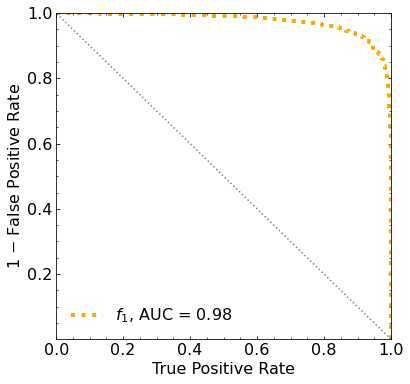

Classification score:


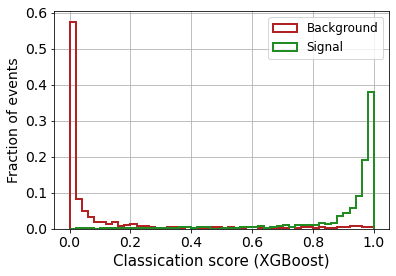


 ROC-AUC =  0.9751963816253605


In [81]:
# XGBoost with only the kinematic variables of the leptons

# CLASSIFIER
classifier = XGBClassifier(
    n_estimators=2500,
    learning_rate=0.01,
    reg_lambda=0.01,reg_alpha=0.0,
    gamma=0.0,objective='binary:logistic',
    max_depth=5,
    #eval_metric=["error", "logloss", "map"]
    eval_metric='logloss')

# FIT
classifier.fit(X_mon_train,y_mon_train,eval_set=[(X_mon_train, y_mon_train), (X_mon_val, y_mon_val)],
        early_stopping_rounds=50,#early stopping
        verbose=True)


# PREDICTIONS
y_pred_xg = classifier.predict_proba(X_mon_test).T[1]


# ROC
fpr_mon_xg, tpr_mon_xg, _ = roc_curve(y_mon_test, y_pred_xg)
roc_auc_xg = auc(fpr_mon_xg, tpr_mon_xg)


# PLOT THE ROC WITH AUC
fig = plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax0.minorticks_on()


plt.plot(tpr_mon_xg,1-fpr_mon_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()



# XGBoost with the kinematic variables of the leptons

########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()




print('\n ROC-AUC = ', roc_auc_xg)

In [82]:
print('\n ROC-AUC = ', roc_auc_xg)


 ROC-AUC =  0.9751963816253605


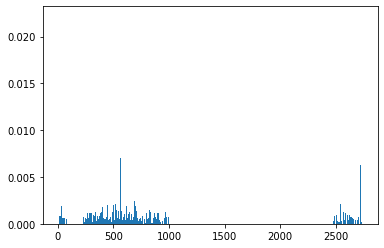

In [83]:
plt.bar(range(len(classifier.feature_importances_)), classifier.feature_importances_)
plt.show()

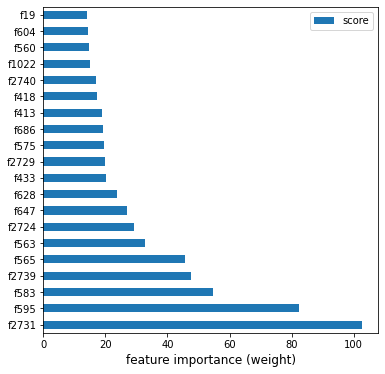


peakS1:     147 features  --> f0 to f146
peakS2:    2298 features  --> f147 to f2444
hits bot: 16384 features  --> f2445 to f18828
hits top: 16384 features  --> f18829 to f35212
resumed:     17 features  --> f35213 to f35229

f35213: pA_S1 
f35214: pH_S1 
f35215: pHT_S1 
f35216: pL_S1 
f35217: pL90_S1 
f35218: pRMSW_S1 
f35219: pHTL_S1 
f35220: pA_S2 
f35221: pH_S2 
f35222: pHT_S2 
f35223: pL_S2 
f35224: pL90_S2 
f35225: pRMSW_S2 
f35226: pHTL_S2 
f35227: pbot 
f35228: ptop 
f35229: pdiffT


In [84]:
feature_important = classifier.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
#keys = ['pA_S1','pH_S1','pHT_S1','pL_S1','pL90_S1','pRMSW_S1','pHTL_S1','pA_S2','pH_S2','pHT_S2','pL_S2','pL90_S2','pRMSW_S2','pHTL_S2','pbot', 'ptop','pdiffT']
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(20, columns="score").plot(kind='barh', figsize = (6,6)) ## plot top 10 features
plt.xlabel('feature importance (weight)', fontsize = 12)
plt.show()

print('\npeakS1:     147 features  --> f0 to f146')
print('peakS2:    2298 features  --> f147 to f2444')
print('hits bot: 16384 features  --> f2445 to f18828')
print('hits top: 16384 features  --> f18829 to f35212')
print('resumed:     17 features  --> f35213 to f35229')

print('\nf35213: pA_S1',
      '\nf35214: pH_S1',
      '\nf35215: pHT_S1',
      '\nf35216: pL_S1',
      '\nf35217: pL90_S1',
      '\nf35218: pRMSW_S1',
      '\nf35219: pHTL_S1',
      '\nf35220: pA_S2',
      '\nf35221: pH_S2',
      '\nf35222: pHT_S2',
      '\nf35223: pL_S2',
      '\nf35224: pL90_S2',
      '\nf35225: pRMSW_S2',
      '\nf35226: pHTL_S2',
      '\nf35227: pbot', 
      '\nf35228: ptop',
      '\nf35229: pdiffT')

In [85]:
MIN_EVS = 5 # min number of background events that we allow per bin
range_dat = [[0,1]] # range of our data (between 0 and 1 if its the ML output)

bins_to_test=range(1,500) # number of bins we are testing to see if condition holds

# FIND THE NUMBER OF BINS:
num_bins = max_num_bins(pred_XG_SM, B_expected, range_dat, MIN_EVS, bins_to_test)

print('\n FOR BIN LIKELIHOOD WE ARE SETTING:')
print('min number of Background events allowed per bin: ', MIN_EVS)
print('number of bins we are going to use: ', num_bins)
print('range of our data: ', range_dat)

At least 5 B events per bin, range = [[0, 1]]:
# bins:  17 OK

 FOR BIN LIKELIHOOD WE ARE SETTING:
min number of Background events allowed per bin:  5
number of bins we are going to use:  17
range of our data:  [[0, 1]]


In [86]:
num_bins = 10

B_expected:  643
S_expected:  1

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.016


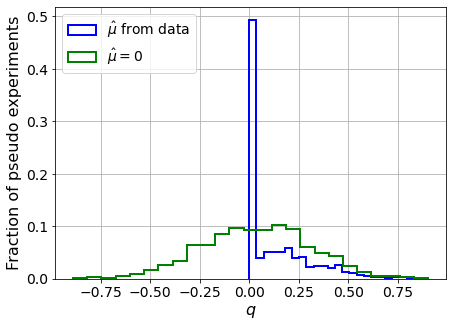

muhat mean:  -0.11667177651154928
Z_bins:  0.20581796035282407
std Z_bins:  0.4182156961758528
Z_bins mu=0:  0.20581796035282407
std Z_bins mu=0:  0.6734614143334734

--------

B_expected:  643
S_expected:  1

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.021


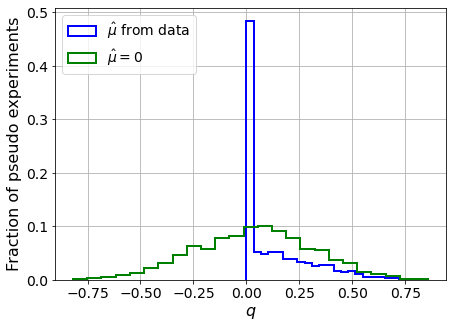

muhat mean:  -0.0974708425934405
Z_bins:  0.2134273294596991
std Z_bins:  0.3994334647204353
Z_bins mu=0:  0.2134273294596991
std Z_bins mu=0:  0.6505121755698969

--------

B_expected:  643
S_expected:  2

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.016


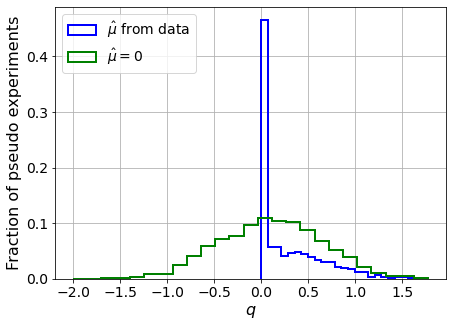

muhat mean:  0.0818576260727036
Z_bins:  0.33116975928537173
std Z_bins:  0.5261599500717021
Z_bins mu=0:  0.33083605961306006
std Z_bins mu=0:  0.8337026410729106

--------

B_expected:  643
S_expected:  3

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0235


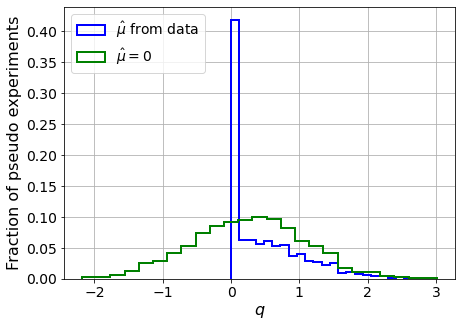

muhat mean:  0.017279962109811794
Z_bins:  0.5234712945467256
std Z_bins:  0.5321128400078599
Z_bins mu=0:  0.5234712945467256
std Z_bins mu=0:  0.7879269278021968

--------

B_expected:  643
S_expected:  7

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.015


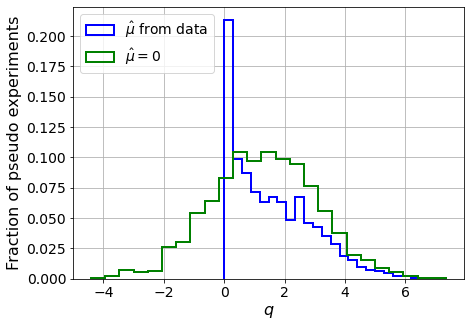

muhat mean:  0.0013758280670971028
Z_bins:  1.1492373282230013
std Z_bins:  0.5903502049108519
Z_bins mu=0:  1.1492186324759566
std Z_bins mu=0:  0.7570608530607377

--------

B_expected:  643
S_expected:  15

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0205


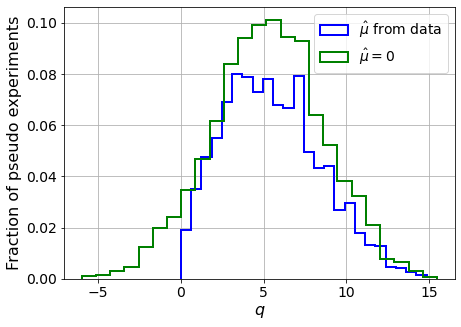

muhat mean:  -0.010336005908187033
Z_bins:  2.2980515721155355
std Z_bins:  0.6375634099838577
Z_bins mu=0:  2.2980515721155355
std Z_bins mu=0:  0.7310947135018193

--------

B_expected:  643
S_expected:  33

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.018


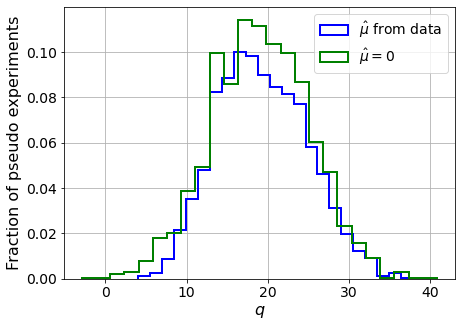

muhat mean:  0.0012089298714638096
Z_bins:  4.360546047654656
std Z_bins:  0.6402796529780067
Z_bins mu=0:  4.3598912917652095
std Z_bins mu=0:  0.6912158832796897

--------

B_expected:  643
S_expected:  72

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.02


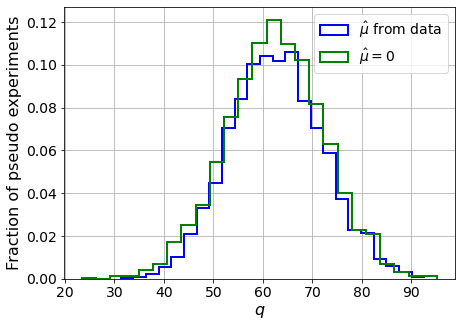

muhat mean:  -0.002310309446152046
Z_bins:  7.907292225433122
std Z_bins:  0.5972864650614237
Z_bins mu=0:  7.907292225433122
std Z_bins mu=0:  0.6255931624942818

--------

B_expected:  643
S_expected:  154

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.0215


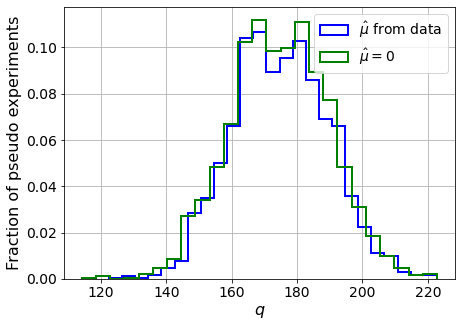

muhat mean:  0.0003466883177253814
Z_bins:  13.221197678121628
std Z_bins:  0.547641455027007
Z_bins mu=0:  13.221197678121628
std Z_bins mu=0:  0.5648472873405935

--------

B_expected:  643
S_expected:  332

Ratio of pseudo experiments that do not satisfied the MIN_EVS condition:  0.02


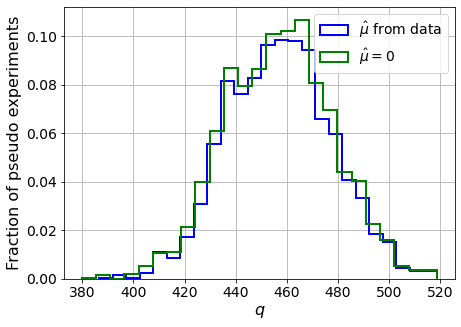

muhat mean:  0.0002163634272340799
Z_bins:  21.38282404119114
std Z_bins:  0.4781472344895801
Z_bins mu=0:  21.38185865577109
std Z_bins mu=0:  0.4885968554019716

--------


 FINAL RESULT:

[[0.20581796035282407, 0.4182156961758528, -0.11667177651154928, 0.20581796035282407, 0.6734614143334734], [0.2134273294596991, 0.3994334647204353, -0.0974708425934405, 0.2134273294596991, 0.6505121755698969], [0.33116975928537173, 0.5261599500717021, 0.0818576260727036, 0.33083605961306006, 0.8337026410729106], [0.5234712945467256, 0.5321128400078599, 0.017279962109811794, 0.5234712945467256, 0.7879269278021968], [1.1492373282230013, 0.5903502049108519, 0.0013758280670971028, 1.1492186324759566, 0.7570608530607377], [2.2980515721155355, 0.6375634099838577, -0.010336005908187033, 2.2980515721155355, 0.7310947135018193], [4.360546047654656, 0.6402796529780067, 0.0012089298714638096, 4.3598912917652095, 0.6912158832796897], [7.907292225433122, 0.5972864650614237, -0.002310309446152046, 7.907292225433

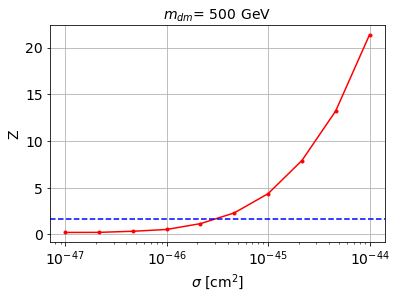


cross_BL_164:  2.990406358249036e-46
cross_BL_164_up:  1.9266447272048535e-46
cross_BL_164_down:  4.575801285881734e-46


In [87]:
# OPTION 2 (mu_hat with more precision) (slower, not so bad for bin likelihood)
store_Z_BL = []


for s_it in range(len(S_expected)):
    
    print('B_expected: ', B_expected)
    print('S_expected: ', S_expected[s_it])
    print('')

    Z_BL = BL_test_fsolve(D_or_E, pred_XG_SM, pred_XG_NP, B_expected, S_expected[s_it], num_pseudo, num_bins, range_dat, MIN_EVS, linear_bins=True) 
    
    store_Z_BL.append( list(Z_BL) )
    
    print('muhat mean: ', Z_BL[2])
    print('Z_bins: ', Z_BL[0])
    print('std Z_bins: ', Z_BL[1])
    print('Z_bins mu=0: ', Z_BL[3])
    print('std Z_bins mu=0: ', Z_BL[4])
    print('')
    print('--------\n')
    
    
    
print('\n FINAL RESULT:\n')
print(store_Z_BL)


# plot
plt.plot(cross_factor*1e-45, np.array(store_Z_BL)[:,0], '.-', c='red')

plt.axhline(y=1.64, c='blue', linestyle='--')
plt.title('$m_{dm}$= %0.2d GeV' % mDM, fontsize=14)
plt.xscale('log')
plt.xlabel(r'$\sigma$ [cm$^2$]', fontsize=14)
plt.ylabel(r'Z', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.show()


# interpolate
f_Z = interp1d(np.log10(cross_factor*1e-45), np.array(store_Z_BL)[:,0], kind='linear')
f_Z_up = interp1d(np.log10(cross_factor*1e-45), np.array(store_Z_BL)[:,0] + np.array(store_Z_BL)[:,1], kind='linear')
f_Z_down = interp1d(np.log10(cross_factor*1e-45), np.array(store_Z_BL)[:,0] - np.array(store_Z_BL)[:,1], kind='linear')

# compute the cross section with Z=1.64
cross_BL_164 = 10**solvecross(f_Z, 1.64)
cross_BL_164_up = 10**solvecross(f_Z_up, 1.64)
cross_BL_164_down = 10**solvecross(f_Z_down, 1.64)

print('\ncross_BL_164: ', cross_BL_164)
print('cross_BL_164_up: ', cross_BL_164_up)
print('cross_BL_164_down: ', cross_BL_164_down)

### DNN

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_80 (Dense)             (None, 256)               701952    
_________________________________________________________________
leaky_re_lu_86 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dropout_72 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_81 (Dense)             (None, 128)               32896     
_________________________________________________________________
leaky_re_lu_87 (LeakyReLU)   (None, 128)               0         
_________________________________________________________________
dropout_73 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_82 (Dense)             (None, 64)              

Epoch 36/500
40/40 [==============================] - 0s 4ms/step - loss: 0.3079 - accuracy: 0.8754 - val_loss: 0.2349 - val_accuracy: 0.9052
Epoch 37/500
40/40 [==============================] - 0s 3ms/step - loss: 0.3105 - accuracy: 0.8767 - val_loss: 0.2476 - val_accuracy: 0.8866
Epoch 38/500
40/40 [==============================] - 0s 3ms/step - loss: 0.3069 - accuracy: 0.8819 - val_loss: 0.2299 - val_accuracy: 0.9088
Epoch 39/500
40/40 [==============================] - 0s 3ms/step - loss: 0.3116 - accuracy: 0.8788 - val_loss: 0.2312 - val_accuracy: 0.9004
Epoch 40/500
40/40 [==============================] - 0s 4ms/step - loss: 0.2927 - accuracy: 0.8829 - val_loss: 0.2349 - val_accuracy: 0.9142
Epoch 41/500
40/40 [==============================] - 0s 3ms/step - loss: 0.3458 - accuracy: 0.8619 - val_loss: 0.2485 - val_accuracy: 0.9052
Epoch 42/500
40/40 [==============================] - 0s 3ms/step - loss: 0.3016 - accuracy: 0.8855 - val_loss: 0.2387 - val_accuracy: 0.9070
Epoch 

Epoch 94/500
40/40 [==============================] - 0s 4ms/step - loss: 0.2250 - accuracy: 0.9156 - val_loss: 0.1972 - val_accuracy: 0.9250
Epoch 95/500
40/40 [==============================] - 0s 4ms/step - loss: 0.2313 - accuracy: 0.9114 - val_loss: 0.2043 - val_accuracy: 0.9214
Epoch 96/500
40/40 [==============================] - 0s 3ms/step - loss: 0.2093 - accuracy: 0.9262 - val_loss: 0.2160 - val_accuracy: 0.9100
Epoch 97/500
40/40 [==============================] - 0s 4ms/step - loss: 0.2283 - accuracy: 0.9225 - val_loss: 0.1952 - val_accuracy: 0.9256
Epoch 98/500
40/40 [==============================] - 0s 3ms/step - loss: 0.2143 - accuracy: 0.9177 - val_loss: 0.2325 - val_accuracy: 0.9112
Epoch 99/500
40/40 [==============================] - 0s 4ms/step - loss: 0.2252 - accuracy: 0.9136 - val_loss: 0.2082 - val_accuracy: 0.9184
Epoch 100/500
40/40 [==============================] - 0s 3ms/step - loss: 0.2278 - accuracy: 0.9175 - val_loss: 0.2491 - val_accuracy: 0.8998
Epoch

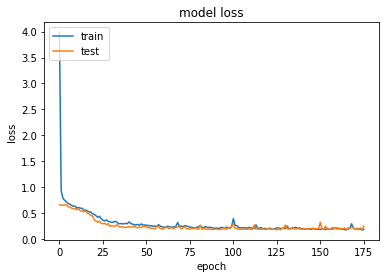

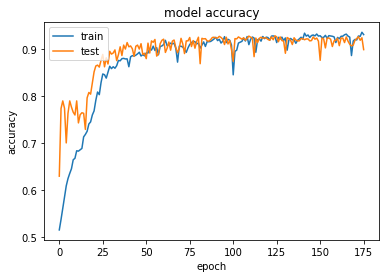

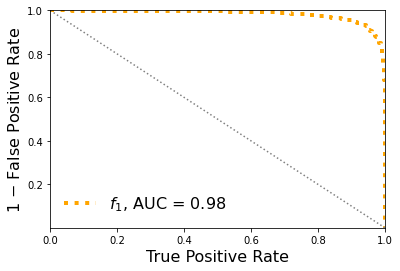

Classification score:


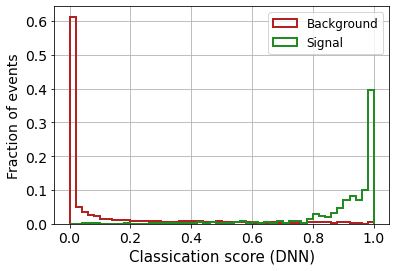


 ROC-AUC =  0.9820729779459404


In [88]:

# define the keras model
model = Sequential()
model.add(Dense(256, input_shape=(X_mon_train.shape[1],)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(128))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(64))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(32))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(16))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(8))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(4))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_dnn = model.predict(X_mon_test)

# Compute ROC curve and ROC area for each class
fpr_dnn = dict()
tpr_dnn = dict()
roc_auc_dnn = dict()
fpr_dnn, tpr_dnn, _ = roc_curve(y_mon_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)


plt.figure()
plt.plot(tpr_dnn,1-fpr_dnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_dnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_dnn[i,0])
    else:
        pred_XG_NP.append(y_pred_dnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (DNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_dnn)

In [89]:
print('\n ROC-AUC = ', roc_auc_dnn)


 ROC-AUC =  0.9820729779459404


### CNN

In [90]:
# prepare the dataset
X_mon_train_cn = X_mon_train.reshape(X_mon_train.shape[0], X_mon_train.shape[1], 1)
X_mon_test_cn = X_mon_test.reshape(X_mon_test.shape[0], X_mon_test.shape[1], 1)
X_mon_val_cn = X_mon_val.reshape(X_mon_val.shape[0], X_mon_val.shape[1], 1)

Epoch 1/500
40/40 [==============================] - 5s 116ms/step - loss: 3.0489 - accuracy: 0.5324 - val_loss: 0.6262 - val_accuracy: 0.8026
Epoch 2/500
40/40 [==============================] - 4s 110ms/step - loss: 0.6886 - accuracy: 0.7714 - val_loss: 0.6182 - val_accuracy: 0.7768
Epoch 3/500
40/40 [==============================] - 4s 110ms/step - loss: 0.6370 - accuracy: 0.7887 - val_loss: 0.5673 - val_accuracy: 0.8194
Epoch 4/500
40/40 [==============================] - 4s 110ms/step - loss: 0.6014 - accuracy: 0.8002 - val_loss: 0.5284 - val_accuracy: 0.8386
Epoch 5/500
40/40 [==============================] - 4s 110ms/step - loss: 0.5882 - accuracy: 0.8062 - val_loss: 0.5365 - val_accuracy: 0.8380
Epoch 6/500
40/40 [==============================] - 4s 109ms/step - loss: 0.5637 - accuracy: 0.8264 - val_loss: 0.5024 - val_accuracy: 0.8536
Epoch 7/500
40/40 [==============================] - 4s 109ms/step - loss: 0.5428 - accuracy: 0.8386 - val_loss: 0.5272 - val_accuracy: 0.8326

Epoch 58/500
40/40 [==============================] - 4s 109ms/step - loss: 0.3771 - accuracy: 0.8818 - val_loss: 0.3627 - val_accuracy: 0.8824
Epoch 59/500
40/40 [==============================] - 4s 109ms/step - loss: 0.4018 - accuracy: 0.8641 - val_loss: 0.4002 - val_accuracy: 0.8602
Epoch 60/500
40/40 [==============================] - 4s 109ms/step - loss: 0.4334 - accuracy: 0.8544 - val_loss: 0.3926 - val_accuracy: 0.8674
Epoch 61/500
40/40 [==============================] - 4s 109ms/step - loss: 0.3626 - accuracy: 0.8867 - val_loss: 0.3220 - val_accuracy: 0.9082
Epoch 62/500
40/40 [==============================] - 4s 109ms/step - loss: 0.3724 - accuracy: 0.8830 - val_loss: 0.3771 - val_accuracy: 0.8758
Epoch 63/500
40/40 [==============================] - 4s 109ms/step - loss: 0.4228 - accuracy: 0.8524 - val_loss: 0.3528 - val_accuracy: 0.8842
Epoch 64/500
40/40 [==============================] - 4s 109ms/step - loss: 0.3671 - accuracy: 0.8815 - val_loss: 0.3311 - val_accuracy:

Epoch 115/500
40/40 [==============================] - 4s 109ms/step - loss: 0.3246 - accuracy: 0.8964 - val_loss: 0.2859 - val_accuracy: 0.9184
Epoch 116/500
40/40 [==============================] - 4s 109ms/step - loss: 0.3045 - accuracy: 0.9085 - val_loss: 0.4054 - val_accuracy: 0.8434
Epoch 117/500
40/40 [==============================] - 4s 109ms/step - loss: 0.3651 - accuracy: 0.8740 - val_loss: 0.3270 - val_accuracy: 0.8878
Epoch 118/500
40/40 [==============================] - 4s 109ms/step - loss: 0.3195 - accuracy: 0.8990 - val_loss: 0.3122 - val_accuracy: 0.9058
Epoch 119/500
40/40 [==============================] - 4s 108ms/step - loss: 0.3731 - accuracy: 0.8825 - val_loss: 0.2968 - val_accuracy: 0.9082
Epoch 120/500
40/40 [==============================] - 4s 108ms/step - loss: 0.3111 - accuracy: 0.9061 - val_loss: 0.2928 - val_accuracy: 0.9034
Epoch 121/500
40/40 [==============================] - 4s 109ms/step - loss: 0.3149 - accuracy: 0.8987 - val_loss: 0.2737 - val_ac

40/40 [==============================] - 5s 113ms/step - loss: 0.2644 - accuracy: 0.9161 - val_loss: 0.2715 - val_accuracy: 0.9112
Epoch 228/500
40/40 [==============================] - 4s 112ms/step - loss: 0.2594 - accuracy: 0.9196 - val_loss: 0.3434 - val_accuracy: 0.8728
Epoch 229/500
40/40 [==============================] - 5s 113ms/step - loss: 0.2941 - accuracy: 0.8984 - val_loss: 0.2672 - val_accuracy: 0.9154
Epoch 230/500
40/40 [==============================] - 5s 113ms/step - loss: 0.2855 - accuracy: 0.9099 - val_loss: 0.2755 - val_accuracy: 0.9088
Epoch 231/500
40/40 [==============================] - 5s 113ms/step - loss: 0.2804 - accuracy: 0.9109 - val_loss: 0.2586 - val_accuracy: 0.9178
Epoch 232/500
40/40 [==============================] - 5s 113ms/step - loss: 0.2613 - accuracy: 0.9161 - val_loss: 0.2646 - val_accuracy: 0.9172
Epoch 233/500
40/40 [==============================] - 5s 113ms/step - loss: 0.2610 - accuracy: 0.9136 - val_loss: 0.2978 - val_accuracy: 0.8938

40/40 [==============================] - 5s 123ms/step - loss: 0.2658 - accuracy: 0.9131 - val_loss: 0.2569 - val_accuracy: 0.9178
Epoch 340/500
40/40 [==============================] - 5s 123ms/step - loss: 0.2423 - accuracy: 0.9234 - val_loss: 0.2620 - val_accuracy: 0.9166
Epoch 341/500
40/40 [==============================] - 5s 123ms/step - loss: 0.2711 - accuracy: 0.9104 - val_loss: 0.2829 - val_accuracy: 0.9058
Epoch 342/500
40/40 [==============================] - 5s 124ms/step - loss: 0.2510 - accuracy: 0.9234 - val_loss: 0.3060 - val_accuracy: 0.8944
Epoch 343/500
40/40 [==============================] - 5s 124ms/step - loss: 0.2537 - accuracy: 0.9196 - val_loss: 0.2803 - val_accuracy: 0.9016
Epoch 344/500
40/40 [==============================] - 5s 123ms/step - loss: 0.2610 - accuracy: 0.9150 - val_loss: 0.2746 - val_accuracy: 0.9082
Epoch 345/500
40/40 [==============================] - 5s 123ms/step - loss: 0.2430 - accuracy: 0.9244 - val_loss: 0.2569 - val_accuracy: 0.9172

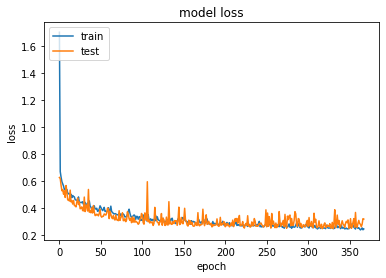

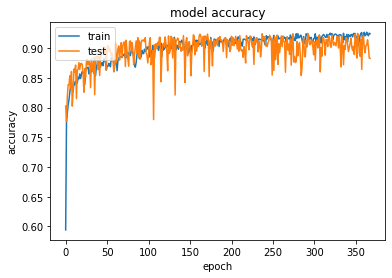

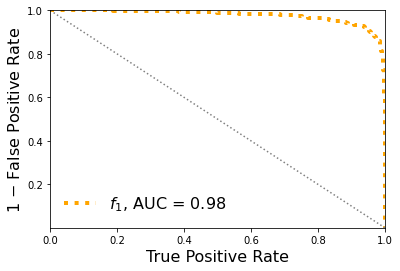

Classification score:


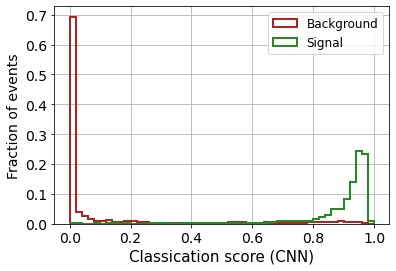


 ROC-AUC =  0.9766379292968559


In [91]:

# define the keras model
model = Sequential()
model.add(Conv1D(16, 3, input_shape=(X_mon_train.shape[1],1), strides = (1),kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Conv1D(16, 3, kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(Conv1D(16, 3, kernel_regularizer=l2(0.005)))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(MaxPooling1D(2, strides = (1)))
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(32, bias_regularizer=regularizers.l2(0.001),kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.LeakyReLU(alpha=0.05))  
model.add(Dropout(0.20))
model.add(Dense(1, activation='sigmoid'))


# Print the model summary
#model.summary()

# to stop the training if validation loss does not improve after patience number of epochs
stop_training = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50, restore_best_weights=True)

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


batch_size = 128
tot_epochs = 500


# Entrenamos el modelo
history = model.fit(X_mon_train_cn,
                    y_mon_train,
                    batch_size=batch_size,
                    epochs=tot_epochs,
                    callbacks=[stop_training],
                    verbose=1,
                    validation_data=(X_mon_val_cn, y_mon_val),
                    shuffle=True)


# Plot de la cost function para la train y test data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# Plot de la accuracy function para la train y test data
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#model.save(root_dir + 'CNN-histo-mix-v2/saved-models/' + 'conv-' + nameMIX_linear +'.h5') # Guardar el modelo.  # Predicción de la red entrenada
y_pred_cnn = model.predict(X_mon_test_cn)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()
fpr_cnn, tpr_cnn, _ = roc_curve(y_mon_test, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)


plt.figure()
plt.plot(tpr_cnn,1-fpr_cnn,label="$f_{1}$, AUC = %0.2f" % roc_auc_cnn,color="orange",ls=":",lw=4)
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=16)
plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
plt.legend()
plt.xlim([0,1])
plt.ylim([0,1])
plt.yticks([0.2,0.4,0.6,0.8,1.])
plt.legend(frameon=False,fontsize=16)
plt.show()








########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

pred_XG_SM = []
pred_XG_NP = []

for i in range(len(y_mon_test)):
    if y_mon_test[i] == 0:
        pred_XG_SM.append(y_pred_cnn[i,0])
    else:
        pred_XG_NP.append(y_pred_cnn[i,0])
        
        
print('Classification score:')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (CNN)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12)

plt.show()






print('\n ROC-AUC = ', roc_auc_cnn)

In [92]:
print('\n ROC-AUC = ', roc_auc_cnn)


 ROC-AUC =  0.9766379292968559
